# Прогнозирование цен на акции с помощью библиотеки prophet
Целью данной работы является рассмотрение возможностей библиботеки Propohet на предмет предсказания цен акций на Российскоq фондовой бирже ММВБ (MOEX).

В современном трейдинге всё большую роль в торговле занимает алготрейдинг - возможность создания алгоритмов, торгуя по которым трейдер будет получать стабильную прибыль. Одна из главных подзадач алготрейдинга - поиск целевой цены на ценные бумаги. Рассмотрим возможности библиотеки Prophet от Facebook применительно к рынку акций на ММВБ.

Важные оговорки: 
1) исследование будет выполняться на рынке российских ценных бумаг ММВБ (MOEX); 
2) с использованием российской специфики рынка (например, национальные выходные дни); 
3) период предсказания будет равен 1 месяцу или 21 рабочему дню работы биржи; 
4) в основе анализа будут данные о ежедневной торговле (дневная свеча); 
5) будут использоваться данные, которые можно получить через API MOEX: цена закрытия и объем торговли.

In [1]:
# Испортируем необходимые библиотеки
import apimoex
import numpy as np
import pandas as pd
import time
import requests

from datetime import date, datetime, timedelta
from matplotlib import pyplot as plt
from prophet import Prophet
from prophet.make_holidays import make_holidays_df
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from tqdm import notebook

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

In [2]:
# Входные параметры и константы
F = 21 # горизонт прогнозирования 21 рабочий день (1 календарный месяц)
tick = 'LKOH' # тикер - код акции на бирже, в текущем исследовании это будет ЛУКОЙЛ
start_date = '2013-03-25' # дата начала парсинга информации о котировках (по факту не ранее 2013-03-25)
train_size = 21*12*3     # длина тренировочного датасета 756 дней (21*12*3) = 3 года
cv = 3     # количессто кросс-валидаций при проверке модели

# Списки возможных значений для подбора гиперпараметров:
changepoint_prior_scale_list = [0.01, 0.05, 0.5, 1.5, 2, 4, 5, 6, 7, 8, 10]
fourier_order_list = [None, 2, 4, 6, 7, 8, 9, 10, 11, 12]               
window_list = [None, 0, 1, 2, 3, 4, 5]          

# Создаем вспомогательный датасет с российскими праздничными днями
holidays = make_holidays_df(list(range(2000, 2024)), 'RUS')
holidays[['lower_window', 'upper_window']] = 0

# Создаем результирующую таблицу для оценки влияния подобранных параметров на метрики на тестовой выборке
results_total = pd.DataFrame(columns=['Параметры', 'MAE', 'RMSE', 'MAPE(%)']) 

# Фиксируем генератор случайных чисел
np.random.seed(42)

# Функции

In [3]:
def metrics_bag(y_true, y_pred, print_flag=False):
    '''
    Вычисление метрик по исходным и прогнозным данным
    Входные параметры: 
    y_true:     фактические данные за определенный период
    y_pred:     прогнозные данные за аналогичный период
    Выходные данные: 
    mae:        метрика MAE
    rmse:       метрика RMSE
    mape:       метрика MAPE в %
    '''
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    if print_flag:
        print('mae: {:.3f}'.format(mae))
        print('rmse: {:.3f}'.format(rmse))
        print('mape: {:.3f}'.format(mape))

    return mae, rmse, mape

def time_info(start_time):
    '''
    Опредлеление времени выполнения процесса
    Входные данные: 
    start_time:    время начала процесса
    Выходные данные: 
    печать времени длительности процесса
    ''' 
    duration = time.time() - start_time
    print('Процесс продолжался {:.0f} минут {:.0f} секунд.'.format(duration // 60, duration % 60))
    return

def get_prophet_prediction(df, train_size=train_size, valid=True, cv=3, F=F, changepoint_prior_scale=0.05, 
                           fourier_order=None, holidays=None, regr=False, test=None):
    """
    Прогноз цены на F дней прогнозного периода с помощью Prophet 
    Входные параметры:
        df                      : датасет с признаками 'ds' и 'y' (обязательны для использования Prophet)
        valid                   : признак, что датасет является валидационным (содержит в себе даты предсказаний)
        cv                      : количество кроссвалидаций
        А                       : горизонт прогнозаровния в днях
        changepoint_prior_scale : параметр настройки "точек преломления" (изменения роста на падение и наоборот)
        fourier_order           : парметр частоты сменыф сезонности
        holidays                : праздничные или особые даты, которые могут оказать влияние на изменение стоимости ЦБ. 

    Выход: 
        Список с прогнозом цены закрытия
        Если выборка валидационная, то также возвращаются средние значения метрик mae, rmse, mape
    """
 
    if valid:

        mae_list = []
        rmse_list = []
        mape_list = []
        for v in range(1, cv + 1):
            # Обучение модели Prophet
            if holidays is not None:
                model = Prophet(changepoint_prior_scale=changepoint_prior_scale, holidays=holidays)
            else:
                model = Prophet(changepoint_prior_scale=changepoint_prior_scale)
            # Добавление месячной сезонности
            if (fourier_order is not None) and (~np.isnan(fourier_order)): 
                model.add_seasonality(name='monthly', period=21, fourier_order=int(fourier_order))
            
            point = len(df) - F * v
            if regr:
                model.add_regressor('SMA_ratio')
                model.add_regressor('SMA_Volume_Ratio')
                model.add_regressor('upperband')
                model.add_regressor('lowerband')
                train_X = df[point-train_size:point][['ds', 'y', 'SMA_ratio', 'SMA_Volume_Ratio', 'upperband', 'lowerband']]
                valid_X = pd.DataFrame(df[point : point + F], 
                                       columns=['ds', 'SMA_ratio', 'SMA_Volume_Ratio', 'upperband', 'lowerband'])
            else:
                train_X = df[point-train_size:point][['ds', 'y']]
                valid_X = pd.DataFrame(df[point : point + F], columns=['ds'])

            y_true_val = df[point : point + F]['y']
            model.fit(train_X)
            y_pred_val = model.predict(valid_X)['yhat']
            mae, rmse, mape = metrics_bag(y_true_val, y_pred_val)
            mae_list.append(mae)
            rmse_list.append(rmse)
            mape_list.append(mape)
            
        return np.mean(mae_list), np.mean(rmse_list), np.mean(mape_list), y_pred_val
    
    else:  
        # Огриничиваем тренинговую часть датасета размером train_size
        df = df[-train_size:]
        # Обучение модели Prophet
        if holidays is not None:
            model = Prophet(changepoint_prior_scale=changepoint_prior_scale, holidays=holidays)
        else:
            model = Prophet(changepoint_prior_scale=changepoint_prior_scale)
        # Добавление месячной сезонности
        if (fourier_order is not None) and (~np.isnan(fourier_order)): 
            model.add_seasonality(name='monthly', period=21, fourier_order=int(fourier_order))
        if regr:
                model.add_regressor('SMA_ratio')
                model.add_regressor('SMA_Volume_Ratio')
                model.add_regressor('upperband')
                model.add_regressor('lowerband')
        model.fit(df)
        # Создание датасета с прогнозными значениями
        future = model.make_future_dataframe(periods=2*F)

        # Исключение из дат выходных дней (суббота, воскресенье) в прогнозных данных
        future['day'] = future['ds'].dt.weekday
        future = future[future['day']<=4]
        future_pred = future[len(df):]
        future = pd.concat([future[:len(df)], future_pred[future_pred['day'] <= 4]])

        # Прогноз
        if regr:
            forecast = model.predict(test) 
            y_pred_test = forecast['yhat']
        else:
            forecast = model.predict(future) 
            y_pred_test = forecast['yhat'][len(df):len(df) + F]

        return y_pred_test
    
def hyperparam_tune_chp(df, changepoint_prior_scale_list, F=F):
    """
    Подбор гиперпараметра changepoint
    Входные даные:
        df                           : датасет с признаками 'ds' и 'y' (обязательное условие Prophet)
        changepoint_prior_scale_list : список возможных значений параметра changepoint_prior_scale
        F                            : горизонт прогнозирования, торговых дней биржи
    Выходные данные
        оптимальный гипермараметр changepoint_prior_scale и датасет с метриками при всех рассмотренных 
        параметрах changepoint_prior_scale
    """
    rmse_mean_list = []
    mape_mean_list = []
    mae_mean_list = []
    for changepoint_prior_scale in notebook.tqdm(changepoint_prior_scale_list):
        print('changepoint_prior_scale: {}'.format(changepoint_prior_scale))
        mae_mean, rmse_mean, mape_mean, _ = get_prophet_prediction(df=df, valid=True, cv=cv, F=F, 
                                                                   changepoint_prior_scale=changepoint_prior_scale)
        rmse_mean_list.append(rmse_mean)
        mape_mean_list.append(mape_mean)
        mae_mean_list.append(mae_mean)
    
    # Создание итогового датасета с метриками по каждому значению changepoint_prior_scale
    results = pd.DataFrame({'changepoint_prior_scale': changepoint_prior_scale_list,
                            'rmse': rmse_mean_list,
                            'mape(%)': mape_mean_list,
                            'mae': mae_mean_list})
    
    # Возврат оптимального значения гипермараметра changepoint_prior_scale и датасета по всем рассмотренным параметрам
    return changepoint_prior_scale_list[np.argmin(rmse_mean_list)], results

def hyperparam_tune_for(df, fourier_order_list, F=F):
    '''
    Подбор гиперпараметра fourier order
    Входные данные
        df                     : датасет с признаками 'ds' и 'y' (обязательное условие Prophet)
        F                      : горизонт прогнозирования, торговых дней биржи
        fourier_order_list     : список возможных значений параметра fourier_order
    Выходные данные:
        значение оптимального гиперпараметра fourier_order_list, датасет с метриками при всех рассмотренных 
        параметрах fourier_order
    '''
    rmse_mean_list = []
    mape_mean_list = []
    mae_mean_list = []
    for fourier_order in notebook.tqdm(fourier_order_list):
        print('fourier_order: {}'.format(fourier_order))
        rmse_mean, mape_mean, mae_mean, _ = get_prophet_prediction(df=df, valid=True, cv=cv, F=F, fourier_order=fourier_order)
        rmse_mean_list.append(rmse_mean)
        mape_mean_list.append(mape_mean)
        mae_mean_list.append(mae_mean)
        
    # Создание итогового датасета с метриками по каждому значению fourier_order
    results = pd.DataFrame({'fourier_order': fourier_order_list,
                            'rmse': rmse_mean_list,
                            'mape(%)': mape_mean_list,
                            'mae': mae_mean_list})
        
    # Возврат оптимального значения гипермараметра fourier_order и датасета по всем рассмотренным параметрам
    return fourier_order_list[np.argmin(rmse_mean_list)], results

def hyperparam_tune_win(df, F=F, window_list=window_list, holidays=holidays):
    '''
    Подбор гиперпараметра - upper and lower windows для праздничных дней
    Входные данные:
        df                     : датасет с признаками 'ds' и 'y' (обязательное условие Prophet)
        F                      : горизонт прогнозирования, торговых дней биржи
        window_list            : list of upper and lower window values to try
        holidays               : датасет содержащий праздничные дни, влияние которых исследуется в модели 
                                 (обязательное наличие признаков 'holiday' and 'ds' ) 
    Выходные данные:
        значение оптимального гиперпараметра window, датасет с метриками при всех рассмотренных 
        параметрах window
    '''
    rmse_mean_list = []
    mape_mean_list = []
    mae_mean_list = []
    for window in notebook.tqdm(window_list):
        print('window:{}'.format(window))
        
        if window is None:
            rmse_mean, mape_mean, mae_mean, _ = get_prophet_prediction(df=df, valid=True, cv=3, F=F, holidays=None)
        else:
            # Добавление симметричных параметров lower_window и upper_window, расширяющих влияние праздничных дней на 
            # торговлю вблизи этих дат с расстоянием в window дней
            holidays['lower_window'] = -window
            holidays['upper_window'] = window
        
            rmse_mean, mape_mean, mae_mean, _ = get_prophet_prediction(df=df, valid=True, cv=3, F=F, holidays=holidays)

        rmse_mean_list.append(rmse_mean)
        mape_mean_list.append(mape_mean)
        mae_mean_list.append(mae_mean)
        
    # Создание итогового датасета с метриками по каждому значению window
    results = pd.DataFrame({'window': window_list,
                            'rmse': rmse_mean_list,
                            'mape(%)': mape_mean_list,
                            'mae': mae_mean_list})
        
    # Возврат оптимального значения гипермараметра window и датасета по всем рассмотренным параметрам
    return window_list[np.argmin(rmse_mean_list)], results

def hyperparam_tune_combo(df, changepoint_prior_scale_list, fourier_order_list, window_list, holidays, F=F, regr=False):
    '''
    Подбор гиперпараметров: changepoint, fourier_order, holidays(windows)
    Входные данные:
        df                           : датасет с признаками 'ds' и 'y' (обязательное условие Prophet)
        changepoint_prior_scale_list : список возможных значений параметра changepoint_prior_scale
        fourier_order_list           : список возможных значений параметра fourier_order     
        window_list                  : list of upper and lower window values to try
        holidays                     : датасет содержащий праздничные дни, влияние которых исследуется в модели 
                                      (обязательное наличие признаков 'holiday' and 'ds' ) 
        F                            : горизонт прогнозирования, торговых дней биржи
             
    Выходные данные:
        значение оптимальных гиперпараметров changepoint_prior_scale, fourier_order, window, 
        датасет с метриками при всех рассмотренных комбинациях параметров
    '''
    rmse_mean_list = []
    mape_mean_list = []
    mae_mean_list = []
    chp_list = []
    for_list = []
    win_list = []
    for changepoint_prior_scale in notebook.tqdm(changepoint_prior_scale_list):
        for fourier_order in notebook.tqdm(fourier_order_list):
            for window in notebook.tqdm(window_list):
                
                if window is None:
                    rmse_mean, mape_mean, mae_mean, _ = get_prophet_prediction\
                    (df=df, 
                     valid=True, 
                     cv=3, 
                     F=F,  
                     changepoint_prior_scale=changepoint_prior_scale, 
                     fourier_order=fourier_order, 
                     holidays=None,
                     regr=regr)
                else:
                    # Добавление симметричных параметров lower_window и upper_window, расширяющих влияние праздничных дней на 
                    # торговлю вблизи этих дат с расстоянием в window дней
                    holidays['lower_window'] = -window
                    holidays['upper_window'] = window
        
                    rmse_mean, mape_mean, mae_mean, _ = get_prophet_prediction\
                    (df=df, 
                     valid=True, 
                     cv=3, 
                     F=F,  
                     changepoint_prior_scale=changepoint_prior_scale, 
                     fourier_order=fourier_order, 
                     holidays=holidays,
                     regr=regr)
                rmse_mean_list.append(rmse_mean)
                mape_mean_list.append(mape_mean)
                mae_mean_list.append(mae_mean)
                chp_list.append(changepoint_prior_scale)
                for_list.append(fourier_order)
                win_list.append(window)
        
    # Возврат оптимальных значений гипермараметров changepoint_prior_scale, fourier_order, window 
    # и датасета по всем рассмотренным параметрам
    results = pd.DataFrame({'changepoint_prior_scale': chp_list, 
                            'fourier_order': for_list,
                            'window': win_list,
                            'rmse': rmse_mean_list,
                            'mape(%)': mape_mean_list,
                            'mae': mae_mean_list})
    temp = results[results['rmse'] == results['rmse'].min()]
    changepoint_prior_scale_opt = temp['changepoint_prior_scale'].values[0]
    fourier_order_opt = temp['fourier_order'].values[0]
    window_opt = temp['window'].values[0]
    
    return changepoint_prior_scale_opt, fourier_order_opt, window_opt, results

def indicators(data, F=F):
    '''
    Дополнение данных техническими индикаторами, смещенными на количество дней предсказаний
    Входные данные: 
        data       : датасет для дополнения его техническими индикаторами 
                    (должен содержать как тренинговую, так и тестовую части)
        F          : горизонт прогнозирования, торговых дней биржи
    Выходные данные:
        исходный датасет, дополненный техническими индикаторами со смещением F
    '''
    df = data.copy() # Создаем копию датасета, чтобы изменения не происходили в исходной таблице
    df['y'] = list(df['y'][:-F]) + [np.nan] * F # Убираем значения признака y в тестовом периоде
    df['volume'] = list(df['volume'][:-F]) + [np.nan] * F # Убираем значения признака volume в тестовом периоде
    
    # SMA-5 и SMA-15 по цене
    df['SMA_5'] = [np.nan] * F + list(df['y'][:-F].transform(lambda x: x.rolling(window = 5, closed='left').mean()))
    df['SMA_15'] = [np.nan] * F + list(df['y'][:-F].transform(lambda x: x.rolling(window = 15, closed='left').mean()))
    df['SMA_ratio'] = df['SMA_15'] / df['SMA_5']

    # SMA-5 и SMA-15 по объему
    df['SMA_5_Volume'] = [np.nan] * F + \
        list(df['volume'][:-F].transform(lambda x: x.rolling(window = 5, closed='left').mean()))
    df['SMA_15_Volume'] = [np.nan] * F + \
        list(df['volume'][:-F].transform(lambda x: x.rolling(window = 15, closed='left').mean()))
    df['SMA_Volume_Ratio'] = df['SMA_5_Volume'] / df['SMA_15_Volume']

    # Индекс Боллинджера
    df['15_MA'] = [np.nan] * F + list(df['y'][:-F].transform(lambda x: x.rolling(window = 15, closed='left').mean()))
    df['SD'] = [np.nan] * F + list(df['y'][:-F].transform(lambda x: x.rolling(window = 15, closed='left').std()))
    df['upperband'] = df['15_MA'] + 2 * df['SD']
    df['lowerband'] = df['15_MA'] - 2 * df['SD']
    df.drop(['15_MA', 'SD'], axis=1, inplace=True)     
    df = df[F + 15:].reset_index(drop=True)
    return df

# Загрузка данных с ММВБ

In [4]:
# Для загразки данных об акциях будем использовать API от MOEX
# end_date = datetime.now() - timedelta(days=1) # Опрелеляем ближнюю границу дат как вчерашний день 
end_date = '2023-07-31' # для повторяемости зафиксируем конечную дату 31.07.2023

data = apimoex.get_board_history(
    session=requests.Session(), 
    security=tick,
    start=start_date,
    end=end_date,
    columns=['TRADEDATE', 'CLOSE', 'VOLUME']
)
if data == []:
    print('За указанный период (с {} по {}) по тикеру {} данных нет'.format(start_date, end_date, tick))
else:
    df = pd.DataFrame(data)
    # Переименовываем признаки для удобства использования
    df.columns = ['date', 'close', 'volume']

    # Преобразуем признак date в формат datetime
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

    # Сортируем датасет по датам по возрастанию
    df.sort_values(by='date', inplace=True, ascending=True)

    # Определячем длину датасета
    print('В исходном датасете {} записей.'.format(len(df)))
    print('Первые 5 записей:')
    display(df.head(5))
    print('Последние 5 записей:')
    display(df.tail(5))
    
    print('Размах дат: с {} по {}'.format(df['date'].min(), df['date'].max()))

В исходном датасете 2609 записей.
Первые 5 записей:


,date,close,volume
0,2013-03-25,1922.0,32441
1,2013-03-26,1944.5,3653
2,2013-03-27,1969.7,1924
3,2013-03-28,1993.2,3398
4,2013-03-29,2003.4,1908


Последние 5 записей:


,date,close,volume
2604,2023-07-25,5633.5,1221979
2605,2023-07-26,5626.0,763971
2606,2023-07-27,5668.0,633923
2607,2023-07-28,5896.0,1866234
2608,2023-07-31,5938.0,1556499


Размах дат: с 2013-03-25 00:00:00 по 2023-07-31 00:00:00


<Figure size 2000x1500 with 0 Axes>

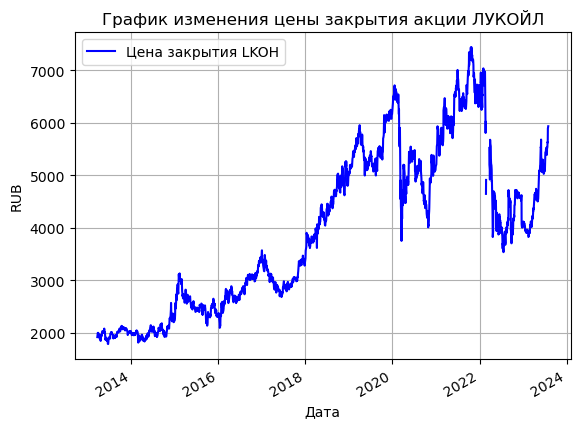

In [5]:
# Построение графика изменения цены закрытия
plt.figure(figsize=(20,15))
ax = df.plot(x='date', y='close', style='b-', grid=True)
ax.legend(['Цена закрытия ' + tick])
ax.set_xlabel('Дата')
ax.set_ylabel('RUB')
ax.set_title('График изменения цены закрытия акции ЛУКОЙЛ')
plt.show()

# Прогноз на заданный период с учетом выходных дней

In [6]:
# Подготовка датасета для использования Prophet
# Переименовываем признаки даты  в вы и цены закрытия в y - требование библиотеки Prophet
df_prophet = df[['date', 'close', 'volume']].rename(columns={'date':'ds', 'close':'y'})
df_prophet.dropna(axis=0, inplace=True) # удаляем строки с пропусками

# Выделение тестового датасета (последние дни текущего датасета в количестве F)
test = df_prophet[-F:]
# Выделение тренингового (включая валидационный) датасета
train = df_prophet[len(df_prophet) - F - train_size - cv * F: -F] 
print("Количество дней в датасете для обучения: {}".format(len(train)))
print("Количество дней в тестовом датасете: {}".format(len(test)))
y_true_test = df_prophet[-F:]['y']

Количество дней в датасете для обучения: 819
Количество дней в тестовом датасете: 21


In [7]:
# Обучение модели
model = Prophet().fit(train)

# Построение датасета с датами, на которые нужно выполнить прогноз 
# (берем с запасом в 2 раза, чтобы при отсечении выходных количество прогнозных дней было не меньше заданного)
future = model.make_future_dataframe(periods=2*F)

17:03:37 - cmdstanpy - INFO - Chain [1] start processing
17:03:37 - cmdstanpy - INFO - Chain [1] done processing


В силу того, что в выходные дни торговля на бирже не производится, даты выходных присутствовать в датасете не должны.

In [8]:
# Удаление дат выходных дней (но только в прогнозной части датасета)
future['day'] = future['ds'].dt.weekday
future_pred = future[len(train):]
future = pd.concat([future[:len(train)], future_pred[future_pred['day'] <= 4]])
# Ограничиваем датасет длиной len(train) + F
future = future[: len(train) + F]
display(future)

,ds,day
0,2020-03-10,1
1,2020-03-11,2
2,2020-03-12,3
3,2020-03-13,4
4,2020-03-16,0
...,...,...
843,2023-07-25,1
844,2023-07-26,2
845,2023-07-27,3
846,2023-07-28,4


In [9]:
# Прогноз
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
835,2023-07-25,4916.708313,4592.415041,5250.800262
836,2023-07-26,4932.181768,4567.607964,5284.242435
837,2023-07-27,4928.908713,4586.855152,5297.401385
838,2023-07-28,4919.726467,4564.672321,5256.844267
839,2023-07-31,4956.471720,4588.457707,5322.336251


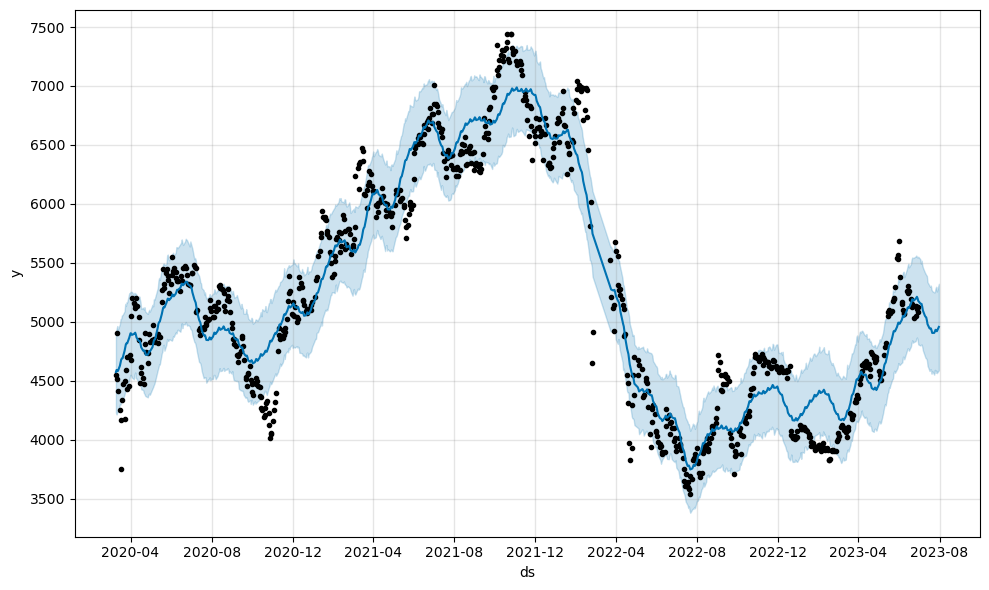

In [10]:
# Строим график
model.plot(forecast);

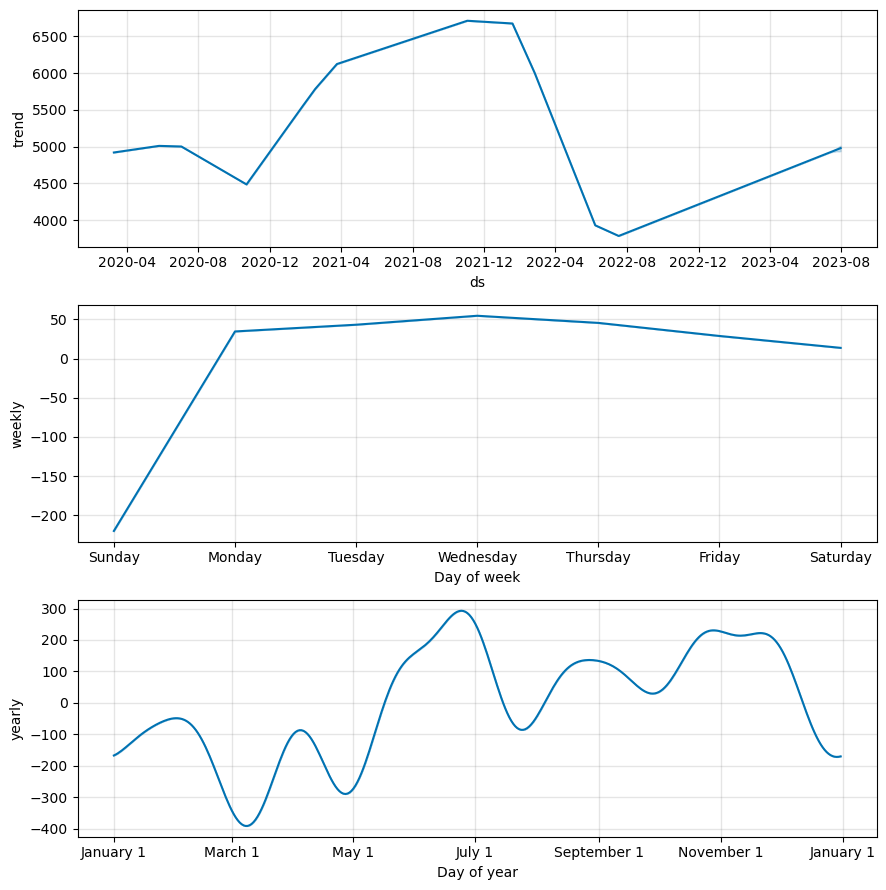

In [11]:
# Строим графики компонент
model.plot_components(forecast);

In [12]:
# Считаем метрики
y_pred_0 = forecast['yhat'][-F:]
mae_, rmse_, mape_ = metrics_bag(y_true_test, y_pred_0, print_flag=True)
results_total.loc[len(results_total.index)] = ['Prophet - без настройки параметров', mae_, rmse_, mape_] 

mae: 506.421
rmse: 563.935
mape: 9.066


Мы получи довольно большую ошибку более 9%. Будем пробовать её уменьшить.

# Прогноз с подбором гиперпараметра changepoint_prior_scale

Дальнейшие вычисления будем производить на выборке train с последующей оценкой модели на тестовой выборке.

In [13]:
# Поиск оптимальных гиперпараметров
start_time = time.time()

changepoint_opt, results = hyperparam_tune_chp(train, 
                                              changepoint_prior_scale_list, 
                                              F=F)
time_info(start_time)

  0%|          | 0/11 [00:00<?, ?it/s]

changepoint_prior_scale: 0.01


17:03:39 - cmdstanpy - INFO - Chain [1] start processing
17:03:39 - cmdstanpy - INFO - Chain [1] done processing
17:03:40 - cmdstanpy - INFO - Chain [1] start processing
17:03:40 - cmdstanpy - INFO - Chain [1] done processing
17:03:40 - cmdstanpy - INFO - Chain [1] start processing
17:03:40 - cmdstanpy - INFO - Chain [1] done processing


changepoint_prior_scale: 0.05


17:03:41 - cmdstanpy - INFO - Chain [1] start processing
17:03:41 - cmdstanpy - INFO - Chain [1] done processing
17:03:41 - cmdstanpy - INFO - Chain [1] start processing
17:03:41 - cmdstanpy - INFO - Chain [1] done processing
17:03:42 - cmdstanpy - INFO - Chain [1] start processing
17:03:42 - cmdstanpy - INFO - Chain [1] done processing


changepoint_prior_scale: 0.5


17:03:42 - cmdstanpy - INFO - Chain [1] start processing
17:03:43 - cmdstanpy - INFO - Chain [1] done processing
17:03:43 - cmdstanpy - INFO - Chain [1] start processing
17:03:43 - cmdstanpy - INFO - Chain [1] done processing
17:03:44 - cmdstanpy - INFO - Chain [1] start processing
17:03:44 - cmdstanpy - INFO - Chain [1] done processing


changepoint_prior_scale: 1.5


17:03:45 - cmdstanpy - INFO - Chain [1] start processing
17:03:45 - cmdstanpy - INFO - Chain [1] done processing
17:03:45 - cmdstanpy - INFO - Chain [1] start processing
17:03:46 - cmdstanpy - INFO - Chain [1] done processing
17:03:46 - cmdstanpy - INFO - Chain [1] start processing
17:03:47 - cmdstanpy - INFO - Chain [1] done processing


changepoint_prior_scale: 2


17:03:47 - cmdstanpy - INFO - Chain [1] start processing
17:03:48 - cmdstanpy - INFO - Chain [1] done processing
17:03:48 - cmdstanpy - INFO - Chain [1] start processing
17:03:48 - cmdstanpy - INFO - Chain [1] done processing
17:03:49 - cmdstanpy - INFO - Chain [1] start processing
17:03:49 - cmdstanpy - INFO - Chain [1] done processing


changepoint_prior_scale: 4


17:03:49 - cmdstanpy - INFO - Chain [1] start processing
17:03:50 - cmdstanpy - INFO - Chain [1] done processing
17:03:50 - cmdstanpy - INFO - Chain [1] start processing
17:03:51 - cmdstanpy - INFO - Chain [1] done processing
17:03:51 - cmdstanpy - INFO - Chain [1] start processing
17:03:52 - cmdstanpy - INFO - Chain [1] done processing


changepoint_prior_scale: 5


17:03:52 - cmdstanpy - INFO - Chain [1] start processing
17:03:52 - cmdstanpy - INFO - Chain [1] done processing
17:03:53 - cmdstanpy - INFO - Chain [1] start processing
17:03:53 - cmdstanpy - INFO - Chain [1] done processing
17:03:54 - cmdstanpy - INFO - Chain [1] start processing
17:03:54 - cmdstanpy - INFO - Chain [1] done processing


changepoint_prior_scale: 6


17:03:54 - cmdstanpy - INFO - Chain [1] start processing
17:03:55 - cmdstanpy - INFO - Chain [1] done processing
17:03:55 - cmdstanpy - INFO - Chain [1] start processing
17:03:56 - cmdstanpy - INFO - Chain [1] done processing
17:03:56 - cmdstanpy - INFO - Chain [1] start processing
17:03:57 - cmdstanpy - INFO - Chain [1] done processing


changepoint_prior_scale: 7


17:03:57 - cmdstanpy - INFO - Chain [1] start processing
17:03:57 - cmdstanpy - INFO - Chain [1] done processing
17:03:58 - cmdstanpy - INFO - Chain [1] start processing
17:03:58 - cmdstanpy - INFO - Chain [1] done processing
17:03:59 - cmdstanpy - INFO - Chain [1] start processing
17:03:59 - cmdstanpy - INFO - Chain [1] done processing


changepoint_prior_scale: 8


17:04:00 - cmdstanpy - INFO - Chain [1] start processing
17:04:00 - cmdstanpy - INFO - Chain [1] done processing
17:04:01 - cmdstanpy - INFO - Chain [1] start processing
17:04:01 - cmdstanpy - INFO - Chain [1] done processing
17:04:01 - cmdstanpy - INFO - Chain [1] start processing
17:04:02 - cmdstanpy - INFO - Chain [1] done processing


changepoint_prior_scale: 10


17:04:02 - cmdstanpy - INFO - Chain [1] start processing
17:04:03 - cmdstanpy - INFO - Chain [1] done processing
17:04:03 - cmdstanpy - INFO - Chain [1] start processing
17:04:04 - cmdstanpy - INFO - Chain [1] done processing
17:04:04 - cmdstanpy - INFO - Chain [1] start processing
17:04:05 - cmdstanpy - INFO - Chain [1] done processing


Процесс продолжался 0 минут 26 секунд.


In [14]:
print('Оптимальное значение параметра changepoint_prior_scale: {:.2f}'.format(changepoint_opt))
display(results)

Оптимальное значение параметра changepoint_prior_scale: 7.00


,changepoint_prior_scale,rmse,mape(%),mae
0,0.01,1486.034081,29.563428,1459.595092
1,0.05,650.444456,12.312921,601.080830
2,0.50,483.896058,9.152475,449.640916
3,1.50,484.707112,9.345214,461.500765
4,2.00,497.080176,9.584270,474.123027
5,4.00,472.968570,9.175292,453.932724
6,5.00,488.743425,9.470397,469.819884
7,6.00,522.212742,10.076521,500.646649
8,7.00,464.274390,9.007188,446.374254
9,8.00,498.785520,9.648930,479.416313


In [15]:
# Пробуем применить модель на тестовой выборке
y_pred_1 = get_prophet_prediction(train, valid=False, changepoint_prior_scale=changepoint_opt, F=F)
mae_, rmse_, mape_ = metrics_bag(y_true_test, y_pred_1, print_flag=True)
results_total.loc[len(results_total.index)] = \
['Prophet с настройкой changepoint (changepoint_prior_scale={:.4f})'.format(changepoint_opt), mae_, rmse_, mape_] 

17:04:05 - cmdstanpy - INFO - Chain [1] start processing
17:04:05 - cmdstanpy - INFO - Chain [1] done processing


mae: 964.662
rmse: 1046.138
mape: 17.314


Как видно, результаты на тестовой выборке сильно хуже, чем на валидационных данных, что говорит о переобучении модели. 
Попробуем подобрать другие параметры

# Прогноз с учетом настраиваемого гиперпараметра месячной сезоности fourier_order

In [16]:
# Подбор оптимальных гиперпараметров
start_time = time.time()
fourier_order_opt, results = hyperparam_tune_for(train,   
                                                fourier_order_list,
                                                F=F)                                               
time_info(start_time)

  0%|          | 0/10 [00:00<?, ?it/s]

fourier_order: None


17:04:06 - cmdstanpy - INFO - Chain [1] start processing
17:04:06 - cmdstanpy - INFO - Chain [1] done processing
17:04:06 - cmdstanpy - INFO - Chain [1] start processing
17:04:07 - cmdstanpy - INFO - Chain [1] done processing
17:04:07 - cmdstanpy - INFO - Chain [1] start processing
17:04:07 - cmdstanpy - INFO - Chain [1] done processing


fourier_order: 2


17:04:07 - cmdstanpy - INFO - Chain [1] start processing
17:04:08 - cmdstanpy - INFO - Chain [1] done processing
17:04:08 - cmdstanpy - INFO - Chain [1] start processing
17:04:08 - cmdstanpy - INFO - Chain [1] done processing
17:04:08 - cmdstanpy - INFO - Chain [1] start processing
17:04:09 - cmdstanpy - INFO - Chain [1] done processing


fourier_order: 4


17:04:09 - cmdstanpy - INFO - Chain [1] start processing
17:04:09 - cmdstanpy - INFO - Chain [1] done processing
17:04:09 - cmdstanpy - INFO - Chain [1] start processing
17:04:10 - cmdstanpy - INFO - Chain [1] done processing
17:04:10 - cmdstanpy - INFO - Chain [1] start processing
17:04:10 - cmdstanpy - INFO - Chain [1] done processing


fourier_order: 6


17:04:10 - cmdstanpy - INFO - Chain [1] start processing
17:04:11 - cmdstanpy - INFO - Chain [1] done processing
17:04:11 - cmdstanpy - INFO - Chain [1] start processing
17:04:11 - cmdstanpy - INFO - Chain [1] done processing
17:04:12 - cmdstanpy - INFO - Chain [1] start processing
17:04:12 - cmdstanpy - INFO - Chain [1] done processing


fourier_order: 7


17:04:12 - cmdstanpy - INFO - Chain [1] start processing
17:04:13 - cmdstanpy - INFO - Chain [1] done processing
17:04:13 - cmdstanpy - INFO - Chain [1] start processing
17:04:13 - cmdstanpy - INFO - Chain [1] done processing
17:04:14 - cmdstanpy - INFO - Chain [1] start processing
17:04:14 - cmdstanpy - INFO - Chain [1] done processing


fourier_order: 8


17:04:14 - cmdstanpy - INFO - Chain [1] start processing
17:04:14 - cmdstanpy - INFO - Chain [1] done processing
17:04:15 - cmdstanpy - INFO - Chain [1] start processing
17:04:15 - cmdstanpy - INFO - Chain [1] done processing
17:04:15 - cmdstanpy - INFO - Chain [1] start processing
17:04:15 - cmdstanpy - INFO - Chain [1] done processing


fourier_order: 9


17:04:16 - cmdstanpy - INFO - Chain [1] start processing
17:04:16 - cmdstanpy - INFO - Chain [1] done processing
17:04:16 - cmdstanpy - INFO - Chain [1] start processing
17:04:17 - cmdstanpy - INFO - Chain [1] done processing
17:04:17 - cmdstanpy - INFO - Chain [1] start processing
17:04:17 - cmdstanpy - INFO - Chain [1] done processing


fourier_order: 10


17:04:18 - cmdstanpy - INFO - Chain [1] start processing
17:04:18 - cmdstanpy - INFO - Chain [1] done processing
17:04:18 - cmdstanpy - INFO - Chain [1] start processing
17:04:18 - cmdstanpy - INFO - Chain [1] done processing
17:04:19 - cmdstanpy - INFO - Chain [1] start processing
17:04:19 - cmdstanpy - INFO - Chain [1] done processing


fourier_order: 11


17:04:19 - cmdstanpy - INFO - Chain [1] start processing
17:04:20 - cmdstanpy - INFO - Chain [1] done processing
17:04:20 - cmdstanpy - INFO - Chain [1] start processing
17:04:20 - cmdstanpy - INFO - Chain [1] done processing
17:04:21 - cmdstanpy - INFO - Chain [1] start processing
17:04:21 - cmdstanpy - INFO - Chain [1] done processing


fourier_order: 12


17:04:21 - cmdstanpy - INFO - Chain [1] start processing
17:04:21 - cmdstanpy - INFO - Chain [1] done processing
17:04:22 - cmdstanpy - INFO - Chain [1] start processing
17:04:22 - cmdstanpy - INFO - Chain [1] done processing
17:04:23 - cmdstanpy - INFO - Chain [1] start processing
17:04:23 - cmdstanpy - INFO - Chain [1] done processing


Процесс продолжался 0 минут 17 секунд.


In [17]:
print('fourier_order_opt: {}'.format(fourier_order_opt))
display(results)

fourier_order_opt: 8


,fourier_order,rmse,mape(%),mae
0,NaN,601.080830,650.444456,12.312921
1,2.0,600.546266,649.873994,12.302974
2,4.0,607.211139,656.945893,12.437386
3,6.0,609.042414,659.085734,12.478156
4,7.0,611.681493,660.055535,12.528659
5,8.0,595.500086,644.403406,12.189174
6,9.0,604.946498,655.082334,12.389531
7,10.0,602.934057,652.356340,12.349463
8,11.0,601.007682,649.808208,12.310090
9,12.0,603.195012,651.270509,12.362300


In [18]:
# Пробуем применить модель на тестовой выборке
y_pred_2 = get_prophet_prediction(train, valid=False, changepoint_prior_scale=changepoint_opt,
                                  F=F, fourier_order=fourier_order_opt)
mae_, rmse_, mape_ = metrics_bag(y_true_test, y_pred_2, print_flag=True)
results_total.loc[len(results_total.index)] = \
['Prophet с настройкой fourier order (fourier_order={:.4f})'.format(fourier_order_opt), mae_, rmse_, mape_] 

17:04:23 - cmdstanpy - INFO - Chain [1] start processing
17:04:24 - cmdstanpy - INFO - Chain [1] done processing


mae: 980.101
rmse: 1061.275
mape: 17.593


Видим, что результат в этот раз хуже, ошибки увеличились, а на валидационной выборке значения метрик хуже, чем на тестовой почти в 2 раза. Попробуем использовать праздничные дни и настроить гиперпараметр window.

# Прогноз с учетом настраиваемого гиперпараметра праздничных дней window

In [19]:
# Подбор оптимальных гиперпараметров
start_time = time.time()
window_opt, results = hyperparam_tune_win(train, window_list=window_list, F=F)     
time_info(start_time)

  0%|          | 0/7 [00:00<?, ?it/s]

window:None


17:04:25 - cmdstanpy - INFO - Chain [1] start processing
17:04:25 - cmdstanpy - INFO - Chain [1] done processing
17:04:25 - cmdstanpy - INFO - Chain [1] start processing
17:04:25 - cmdstanpy - INFO - Chain [1] done processing
17:04:26 - cmdstanpy - INFO - Chain [1] start processing
17:04:26 - cmdstanpy - INFO - Chain [1] done processing


window:0


17:04:26 - cmdstanpy - INFO - Chain [1] start processing
17:04:26 - cmdstanpy - INFO - Chain [1] done processing
17:04:27 - cmdstanpy - INFO - Chain [1] start processing
17:04:27 - cmdstanpy - INFO - Chain [1] done processing
17:04:28 - cmdstanpy - INFO - Chain [1] start processing
17:04:28 - cmdstanpy - INFO - Chain [1] done processing


window:1


17:04:28 - cmdstanpy - INFO - Chain [1] start processing
17:04:29 - cmdstanpy - INFO - Chain [1] done processing
17:04:29 - cmdstanpy - INFO - Chain [1] start processing
17:04:30 - cmdstanpy - INFO - Chain [1] done processing
17:04:31 - cmdstanpy - INFO - Chain [1] start processing
17:04:31 - cmdstanpy - INFO - Chain [1] done processing


window:2


17:04:32 - cmdstanpy - INFO - Chain [1] start processing
17:04:32 - cmdstanpy - INFO - Chain [1] done processing
17:04:33 - cmdstanpy - INFO - Chain [1] start processing
17:04:33 - cmdstanpy - INFO - Chain [1] done processing
17:04:35 - cmdstanpy - INFO - Chain [1] start processing
17:04:35 - cmdstanpy - INFO - Chain [1] done processing


window:3


17:04:36 - cmdstanpy - INFO - Chain [1] start processing
17:04:36 - cmdstanpy - INFO - Chain [1] done processing
17:04:38 - cmdstanpy - INFO - Chain [1] start processing
17:04:38 - cmdstanpy - INFO - Chain [1] done processing
17:04:40 - cmdstanpy - INFO - Chain [1] start processing
17:04:40 - cmdstanpy - INFO - Chain [1] done processing


window:4


17:04:42 - cmdstanpy - INFO - Chain [1] start processing
17:04:42 - cmdstanpy - INFO - Chain [1] done processing
17:04:44 - cmdstanpy - INFO - Chain [1] start processing
17:04:44 - cmdstanpy - INFO - Chain [1] done processing
17:04:46 - cmdstanpy - INFO - Chain [1] start processing
17:04:46 - cmdstanpy - INFO - Chain [1] done processing


window:5


17:04:48 - cmdstanpy - INFO - Chain [1] start processing
17:04:48 - cmdstanpy - INFO - Chain [1] done processing
17:04:51 - cmdstanpy - INFO - Chain [1] start processing
17:04:51 - cmdstanpy - INFO - Chain [1] done processing
17:04:53 - cmdstanpy - INFO - Chain [1] start processing
17:04:53 - cmdstanpy - INFO - Chain [1] done processing


Процесс продолжался 0 минут 30 секунд.


In [20]:
print('window_opt: {}'.format(window_opt))
display(results)

window_opt: 4


,window,rmse,mape(%),mae
0,NaN,601.080830,650.444456,12.312921
1,0.0,593.198874,644.036882,12.146833
2,1.0,602.608142,653.783223,12.347582
3,2.0,604.208155,655.486964,12.386601
4,3.0,589.693053,639.703907,12.080503
5,4.0,583.445927,635.398400,11.959646
6,5.0,587.026801,637.830260,12.018303


In [21]:
# Пробуем применить модель на тестовой выборке
if (window_opt is None) or (np.isnan(window_opt)):
    y_pred_3 = get_prophet_prediction(df=train, valid=False, F=F, holidays=None)
else:
    holidays['lower_window'] = -window_opt
    holidays['upper_window'] = window_opt
    y_pred_3 = get_prophet_prediction(df=train, valid=False, F=F, holidays=holidays)
mae_, rmse_, mape_ = metrics_bag(y_true_test, y_pred_3, print_flag=True)
results_total.loc[len(results_total.index)] = \
['Prophet с настройкой window (window={:.4f})'.format(window_opt), mae_, rmse_, mape_] 

17:04:56 - cmdstanpy - INFO - Chain [1] start processing
17:04:56 - cmdstanpy - INFO - Chain [1] done processing


mae: 362.134
rmse: 408.102
mape: 6.481


Праздничные дни оказывают влияение на прогнозирование с окном в 4 дня. Ошибка по прежнему великовата, но модель не переобучилась и на тестовой выборке показала результат лучше, чем на валидационной. Попробуем подобрать оптимальную комбинацию из рассмотренных гиперпараметров.

# Прогноз с учетом настраиваемых гиперпараметров changepoint, monthly seasonality, holidays

In [22]:
# Попробуем теперь рассмотреть различные вариации рассмотренных ранее гиперпараметров
start_time = time.time()
changepoint_prior_scale_opt, fourier_order_opt, window_opt, results = \
hyperparam_tune_combo(train, 
                      F=F, 
                      changepoint_prior_scale_list=changepoint_prior_scale_list,
                      fourier_order_list=fourier_order_list,
                      window_list=window_list,
                      holidays=holidays)
time_info(start_time)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

17:04:57 - cmdstanpy - INFO - Chain [1] start processing
17:04:57 - cmdstanpy - INFO - Chain [1] done processing
17:04:58 - cmdstanpy - INFO - Chain [1] start processing
17:04:58 - cmdstanpy - INFO - Chain [1] done processing
17:04:58 - cmdstanpy - INFO - Chain [1] start processing
17:04:58 - cmdstanpy - INFO - Chain [1] done processing
17:04:59 - cmdstanpy - INFO - Chain [1] start processing
17:04:59 - cmdstanpy - INFO - Chain [1] done processing
17:04:59 - cmdstanpy - INFO - Chain [1] start processing
17:04:59 - cmdstanpy - INFO - Chain [1] done processing
17:05:00 - cmdstanpy - INFO - Chain [1] start processing
17:05:00 - cmdstanpy - INFO - Chain [1] done processing
17:05:00 - cmdstanpy - INFO - Chain [1] start processing
17:05:01 - cmdstanpy - INFO - Chain [1] done processing
17:05:01 - cmdstanpy - INFO - Chain [1] start processing
17:05:01 - cmdstanpy - INFO - Chain [1] done processing
17:05:02 - cmdstanpy - INFO - Chain [1] start processing
17:05:02 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:05:24 - cmdstanpy - INFO - Chain [1] start processing
17:05:24 - cmdstanpy - INFO - Chain [1] done processing
17:05:25 - cmdstanpy - INFO - Chain [1] start processing
17:05:25 - cmdstanpy - INFO - Chain [1] done processing
17:05:25 - cmdstanpy - INFO - Chain [1] start processing
17:05:25 - cmdstanpy - INFO - Chain [1] done processing
17:05:26 - cmdstanpy - INFO - Chain [1] start processing
17:05:26 - cmdstanpy - INFO - Chain [1] done processing
17:05:26 - cmdstanpy - INFO - Chain [1] start processing
17:05:26 - cmdstanpy - INFO - Chain [1] done processing
17:05:27 - cmdstanpy - INFO - Chain [1] start processing
17:05:27 - cmdstanpy - INFO - Chain [1] done processing
17:05:27 - cmdstanpy - INFO - Chain [1] start processing
17:05:28 - cmdstanpy - INFO - Chain [1] done processing
17:05:28 - cmdstanpy - INFO - Chain [1] start processing
17:05:29 - cmdstanpy - INFO - Chain [1] done processing
17:05:29 - cmdstanpy - INFO - Chain [1] start processing
17:05:30 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:05:52 - cmdstanpy - INFO - Chain [1] start processing
17:05:52 - cmdstanpy - INFO - Chain [1] done processing
17:05:52 - cmdstanpy - INFO - Chain [1] start processing
17:05:52 - cmdstanpy - INFO - Chain [1] done processing
17:05:52 - cmdstanpy - INFO - Chain [1] start processing
17:05:53 - cmdstanpy - INFO - Chain [1] done processing
17:05:53 - cmdstanpy - INFO - Chain [1] start processing
17:05:53 - cmdstanpy - INFO - Chain [1] done processing
17:05:54 - cmdstanpy - INFO - Chain [1] start processing
17:05:54 - cmdstanpy - INFO - Chain [1] done processing
17:05:54 - cmdstanpy - INFO - Chain [1] start processing
17:05:54 - cmdstanpy - INFO - Chain [1] done processing
17:05:55 - cmdstanpy - INFO - Chain [1] start processing
17:05:55 - cmdstanpy - INFO - Chain [1] done processing
17:05:56 - cmdstanpy - INFO - Chain [1] start processing
17:05:56 - cmdstanpy - INFO - Chain [1] done processing
17:05:57 - cmdstanpy - INFO - Chain [1] start processing
17:05:57 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:06:19 - cmdstanpy - INFO - Chain [1] start processing
17:06:20 - cmdstanpy - INFO - Chain [1] done processing
17:06:20 - cmdstanpy - INFO - Chain [1] start processing
17:06:20 - cmdstanpy - INFO - Chain [1] done processing
17:06:20 - cmdstanpy - INFO - Chain [1] start processing
17:06:20 - cmdstanpy - INFO - Chain [1] done processing
17:06:21 - cmdstanpy - INFO - Chain [1] start processing
17:06:21 - cmdstanpy - INFO - Chain [1] done processing
17:06:21 - cmdstanpy - INFO - Chain [1] start processing
17:06:22 - cmdstanpy - INFO - Chain [1] done processing
17:06:22 - cmdstanpy - INFO - Chain [1] start processing
17:06:22 - cmdstanpy - INFO - Chain [1] done processing
17:06:23 - cmdstanpy - INFO - Chain [1] start processing
17:06:23 - cmdstanpy - INFO - Chain [1] done processing
17:06:24 - cmdstanpy - INFO - Chain [1] start processing
17:06:24 - cmdstanpy - INFO - Chain [1] done processing
17:06:25 - cmdstanpy - INFO - Chain [1] start processing
17:06:25 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:06:47 - cmdstanpy - INFO - Chain [1] start processing
17:06:47 - cmdstanpy - INFO - Chain [1] done processing
17:06:48 - cmdstanpy - INFO - Chain [1] start processing
17:06:48 - cmdstanpy - INFO - Chain [1] done processing
17:06:48 - cmdstanpy - INFO - Chain [1] start processing
17:06:48 - cmdstanpy - INFO - Chain [1] done processing
17:06:49 - cmdstanpy - INFO - Chain [1] start processing
17:06:49 - cmdstanpy - INFO - Chain [1] done processing
17:06:49 - cmdstanpy - INFO - Chain [1] start processing
17:06:49 - cmdstanpy - INFO - Chain [1] done processing
17:06:50 - cmdstanpy - INFO - Chain [1] start processing
17:06:50 - cmdstanpy - INFO - Chain [1] done processing
17:06:51 - cmdstanpy - INFO - Chain [1] start processing
17:06:51 - cmdstanpy - INFO - Chain [1] done processing
17:06:52 - cmdstanpy - INFO - Chain [1] start processing
17:06:52 - cmdstanpy - INFO - Chain [1] done processing
17:06:53 - cmdstanpy - INFO - Chain [1] start processing
17:06:53 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:07:15 - cmdstanpy - INFO - Chain [1] start processing
17:07:16 - cmdstanpy - INFO - Chain [1] done processing
17:07:16 - cmdstanpy - INFO - Chain [1] start processing
17:07:16 - cmdstanpy - INFO - Chain [1] done processing
17:07:16 - cmdstanpy - INFO - Chain [1] start processing
17:07:16 - cmdstanpy - INFO - Chain [1] done processing
17:07:17 - cmdstanpy - INFO - Chain [1] start processing
17:07:17 - cmdstanpy - INFO - Chain [1] done processing
17:07:18 - cmdstanpy - INFO - Chain [1] start processing
17:07:18 - cmdstanpy - INFO - Chain [1] done processing
17:07:18 - cmdstanpy - INFO - Chain [1] start processing
17:07:18 - cmdstanpy - INFO - Chain [1] done processing
17:07:19 - cmdstanpy - INFO - Chain [1] start processing
17:07:19 - cmdstanpy - INFO - Chain [1] done processing
17:07:20 - cmdstanpy - INFO - Chain [1] start processing
17:07:20 - cmdstanpy - INFO - Chain [1] done processing
17:07:21 - cmdstanpy - INFO - Chain [1] start processing
17:07:21 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:07:45 - cmdstanpy - INFO - Chain [1] start processing
17:07:45 - cmdstanpy - INFO - Chain [1] done processing
17:07:45 - cmdstanpy - INFO - Chain [1] start processing
17:07:45 - cmdstanpy - INFO - Chain [1] done processing
17:07:46 - cmdstanpy - INFO - Chain [1] start processing
17:07:46 - cmdstanpy - INFO - Chain [1] done processing
17:07:46 - cmdstanpy - INFO - Chain [1] start processing
17:07:46 - cmdstanpy - INFO - Chain [1] done processing
17:07:47 - cmdstanpy - INFO - Chain [1] start processing
17:07:47 - cmdstanpy - INFO - Chain [1] done processing
17:07:47 - cmdstanpy - INFO - Chain [1] start processing
17:07:48 - cmdstanpy - INFO - Chain [1] done processing
17:07:48 - cmdstanpy - INFO - Chain [1] start processing
17:07:48 - cmdstanpy - INFO - Chain [1] done processing
17:07:49 - cmdstanpy - INFO - Chain [1] start processing
17:07:49 - cmdstanpy - INFO - Chain [1] done processing
17:07:50 - cmdstanpy - INFO - Chain [1] start processing
17:07:50 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:08:13 - cmdstanpy - INFO - Chain [1] start processing
17:08:13 - cmdstanpy - INFO - Chain [1] done processing
17:08:14 - cmdstanpy - INFO - Chain [1] start processing
17:08:14 - cmdstanpy - INFO - Chain [1] done processing
17:08:14 - cmdstanpy - INFO - Chain [1] start processing
17:08:14 - cmdstanpy - INFO - Chain [1] done processing
17:08:15 - cmdstanpy - INFO - Chain [1] start processing
17:08:15 - cmdstanpy - INFO - Chain [1] done processing
17:08:15 - cmdstanpy - INFO - Chain [1] start processing
17:08:15 - cmdstanpy - INFO - Chain [1] done processing
17:08:16 - cmdstanpy - INFO - Chain [1] start processing
17:08:16 - cmdstanpy - INFO - Chain [1] done processing
17:08:17 - cmdstanpy - INFO - Chain [1] start processing
17:08:17 - cmdstanpy - INFO - Chain [1] done processing
17:08:18 - cmdstanpy - INFO - Chain [1] start processing
17:08:18 - cmdstanpy - INFO - Chain [1] done processing
17:08:19 - cmdstanpy - INFO - Chain [1] start processing
17:08:19 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:08:42 - cmdstanpy - INFO - Chain [1] start processing
17:08:42 - cmdstanpy - INFO - Chain [1] done processing
17:08:42 - cmdstanpy - INFO - Chain [1] start processing
17:08:42 - cmdstanpy - INFO - Chain [1] done processing
17:08:43 - cmdstanpy - INFO - Chain [1] start processing
17:08:43 - cmdstanpy - INFO - Chain [1] done processing
17:08:43 - cmdstanpy - INFO - Chain [1] start processing
17:08:43 - cmdstanpy - INFO - Chain [1] done processing
17:08:44 - cmdstanpy - INFO - Chain [1] start processing
17:08:44 - cmdstanpy - INFO - Chain [1] done processing
17:08:45 - cmdstanpy - INFO - Chain [1] start processing
17:08:45 - cmdstanpy - INFO - Chain [1] done processing
17:08:45 - cmdstanpy - INFO - Chain [1] start processing
17:08:46 - cmdstanpy - INFO - Chain [1] done processing
17:08:46 - cmdstanpy - INFO - Chain [1] start processing
17:08:47 - cmdstanpy - INFO - Chain [1] done processing
17:08:47 - cmdstanpy - INFO - Chain [1] start processing
17:08:48 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:09:10 - cmdstanpy - INFO - Chain [1] start processing
17:09:11 - cmdstanpy - INFO - Chain [1] done processing
17:09:11 - cmdstanpy - INFO - Chain [1] start processing
17:09:11 - cmdstanpy - INFO - Chain [1] done processing
17:09:11 - cmdstanpy - INFO - Chain [1] start processing
17:09:11 - cmdstanpy - INFO - Chain [1] done processing
17:09:12 - cmdstanpy - INFO - Chain [1] start processing
17:09:12 - cmdstanpy - INFO - Chain [1] done processing
17:09:13 - cmdstanpy - INFO - Chain [1] start processing
17:09:13 - cmdstanpy - INFO - Chain [1] done processing
17:09:13 - cmdstanpy - INFO - Chain [1] start processing
17:09:13 - cmdstanpy - INFO - Chain [1] done processing
17:09:14 - cmdstanpy - INFO - Chain [1] start processing
17:09:14 - cmdstanpy - INFO - Chain [1] done processing
17:09:15 - cmdstanpy - INFO - Chain [1] start processing
17:09:15 - cmdstanpy - INFO - Chain [1] done processing
17:09:16 - cmdstanpy - INFO - Chain [1] start processing
17:09:16 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

17:09:40 - cmdstanpy - INFO - Chain [1] start processing
17:09:40 - cmdstanpy - INFO - Chain [1] done processing
17:09:40 - cmdstanpy - INFO - Chain [1] start processing
17:09:41 - cmdstanpy - INFO - Chain [1] done processing
17:09:41 - cmdstanpy - INFO - Chain [1] start processing
17:09:41 - cmdstanpy - INFO - Chain [1] done processing
17:09:41 - cmdstanpy - INFO - Chain [1] start processing
17:09:42 - cmdstanpy - INFO - Chain [1] done processing
17:09:42 - cmdstanpy - INFO - Chain [1] start processing
17:09:42 - cmdstanpy - INFO - Chain [1] done processing
17:09:43 - cmdstanpy - INFO - Chain [1] start processing
17:09:43 - cmdstanpy - INFO - Chain [1] done processing
17:09:44 - cmdstanpy - INFO - Chain [1] start processing
17:09:44 - cmdstanpy - INFO - Chain [1] done processing
17:09:45 - cmdstanpy - INFO - Chain [1] start processing
17:09:45 - cmdstanpy - INFO - Chain [1] done processing
17:09:46 - cmdstanpy - INFO - Chain [1] start processing
17:09:46 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:10:10 - cmdstanpy - INFO - Chain [1] start processing
17:10:10 - cmdstanpy - INFO - Chain [1] done processing
17:10:11 - cmdstanpy - INFO - Chain [1] start processing
17:10:11 - cmdstanpy - INFO - Chain [1] done processing
17:10:11 - cmdstanpy - INFO - Chain [1] start processing
17:10:11 - cmdstanpy - INFO - Chain [1] done processing
17:10:12 - cmdstanpy - INFO - Chain [1] start processing
17:10:12 - cmdstanpy - INFO - Chain [1] done processing
17:10:12 - cmdstanpy - INFO - Chain [1] start processing
17:10:13 - cmdstanpy - INFO - Chain [1] done processing
17:10:13 - cmdstanpy - INFO - Chain [1] start processing
17:10:13 - cmdstanpy - INFO - Chain [1] done processing
17:10:14 - cmdstanpy - INFO - Chain [1] start processing
17:10:14 - cmdstanpy - INFO - Chain [1] done processing
17:10:15 - cmdstanpy - INFO - Chain [1] start processing
17:10:16 - cmdstanpy - INFO - Chain [1] done processing
17:10:16 - cmdstanpy - INFO - Chain [1] start processing
17:10:17 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:10:41 - cmdstanpy - INFO - Chain [1] start processing
17:10:41 - cmdstanpy - INFO - Chain [1] done processing
17:10:41 - cmdstanpy - INFO - Chain [1] start processing
17:10:42 - cmdstanpy - INFO - Chain [1] done processing
17:10:42 - cmdstanpy - INFO - Chain [1] start processing
17:10:42 - cmdstanpy - INFO - Chain [1] done processing
17:10:43 - cmdstanpy - INFO - Chain [1] start processing
17:10:43 - cmdstanpy - INFO - Chain [1] done processing
17:10:43 - cmdstanpy - INFO - Chain [1] start processing
17:10:44 - cmdstanpy - INFO - Chain [1] done processing
17:10:44 - cmdstanpy - INFO - Chain [1] start processing
17:10:44 - cmdstanpy - INFO - Chain [1] done processing
17:10:45 - cmdstanpy - INFO - Chain [1] start processing
17:10:45 - cmdstanpy - INFO - Chain [1] done processing
17:10:46 - cmdstanpy - INFO - Chain [1] start processing
17:10:46 - cmdstanpy - INFO - Chain [1] done processing
17:10:47 - cmdstanpy - INFO - Chain [1] start processing
17:10:47 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:11:12 - cmdstanpy - INFO - Chain [1] start processing
17:11:12 - cmdstanpy - INFO - Chain [1] done processing
17:11:13 - cmdstanpy - INFO - Chain [1] start processing
17:11:13 - cmdstanpy - INFO - Chain [1] done processing
17:11:13 - cmdstanpy - INFO - Chain [1] start processing
17:11:14 - cmdstanpy - INFO - Chain [1] done processing
17:11:14 - cmdstanpy - INFO - Chain [1] start processing
17:11:14 - cmdstanpy - INFO - Chain [1] done processing
17:11:15 - cmdstanpy - INFO - Chain [1] start processing
17:11:15 - cmdstanpy - INFO - Chain [1] done processing
17:11:16 - cmdstanpy - INFO - Chain [1] start processing
17:11:16 - cmdstanpy - INFO - Chain [1] done processing
17:11:16 - cmdstanpy - INFO - Chain [1] start processing
17:11:17 - cmdstanpy - INFO - Chain [1] done processing
17:11:18 - cmdstanpy - INFO - Chain [1] start processing
17:11:18 - cmdstanpy - INFO - Chain [1] done processing
17:11:19 - cmdstanpy - INFO - Chain [1] start processing
17:11:19 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:11:45 - cmdstanpy - INFO - Chain [1] start processing
17:11:45 - cmdstanpy - INFO - Chain [1] done processing
17:11:45 - cmdstanpy - INFO - Chain [1] start processing
17:11:46 - cmdstanpy - INFO - Chain [1] done processing
17:11:46 - cmdstanpy - INFO - Chain [1] start processing
17:11:46 - cmdstanpy - INFO - Chain [1] done processing
17:11:47 - cmdstanpy - INFO - Chain [1] start processing
17:11:47 - cmdstanpy - INFO - Chain [1] done processing
17:11:47 - cmdstanpy - INFO - Chain [1] start processing
17:11:48 - cmdstanpy - INFO - Chain [1] done processing
17:11:48 - cmdstanpy - INFO - Chain [1] start processing
17:11:48 - cmdstanpy - INFO - Chain [1] done processing
17:11:49 - cmdstanpy - INFO - Chain [1] start processing
17:11:49 - cmdstanpy - INFO - Chain [1] done processing
17:11:50 - cmdstanpy - INFO - Chain [1] start processing
17:11:51 - cmdstanpy - INFO - Chain [1] done processing
17:11:52 - cmdstanpy - INFO - Chain [1] start processing
17:11:52 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:12:16 - cmdstanpy - INFO - Chain [1] start processing
17:12:16 - cmdstanpy - INFO - Chain [1] done processing
17:12:17 - cmdstanpy - INFO - Chain [1] start processing
17:12:17 - cmdstanpy - INFO - Chain [1] done processing
17:12:17 - cmdstanpy - INFO - Chain [1] start processing
17:12:18 - cmdstanpy - INFO - Chain [1] done processing
17:12:18 - cmdstanpy - INFO - Chain [1] start processing
17:12:18 - cmdstanpy - INFO - Chain [1] done processing
17:12:19 - cmdstanpy - INFO - Chain [1] start processing
17:12:19 - cmdstanpy - INFO - Chain [1] done processing
17:12:20 - cmdstanpy - INFO - Chain [1] start processing
17:12:20 - cmdstanpy - INFO - Chain [1] done processing
17:12:21 - cmdstanpy - INFO - Chain [1] start processing
17:12:21 - cmdstanpy - INFO - Chain [1] done processing
17:12:22 - cmdstanpy - INFO - Chain [1] start processing
17:12:22 - cmdstanpy - INFO - Chain [1] done processing
17:12:23 - cmdstanpy - INFO - Chain [1] start processing
17:12:23 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:12:48 - cmdstanpy - INFO - Chain [1] start processing
17:12:48 - cmdstanpy - INFO - Chain [1] done processing
17:12:49 - cmdstanpy - INFO - Chain [1] start processing
17:12:49 - cmdstanpy - INFO - Chain [1] done processing
17:12:49 - cmdstanpy - INFO - Chain [1] start processing
17:12:49 - cmdstanpy - INFO - Chain [1] done processing
17:12:50 - cmdstanpy - INFO - Chain [1] start processing
17:12:50 - cmdstanpy - INFO - Chain [1] done processing
17:12:51 - cmdstanpy - INFO - Chain [1] start processing
17:12:51 - cmdstanpy - INFO - Chain [1] done processing
17:12:52 - cmdstanpy - INFO - Chain [1] start processing
17:12:52 - cmdstanpy - INFO - Chain [1] done processing
17:12:53 - cmdstanpy - INFO - Chain [1] start processing
17:12:53 - cmdstanpy - INFO - Chain [1] done processing
17:12:54 - cmdstanpy - INFO - Chain [1] start processing
17:12:54 - cmdstanpy - INFO - Chain [1] done processing
17:12:55 - cmdstanpy - INFO - Chain [1] start processing
17:12:55 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:13:21 - cmdstanpy - INFO - Chain [1] start processing
17:13:21 - cmdstanpy - INFO - Chain [1] done processing
17:13:21 - cmdstanpy - INFO - Chain [1] start processing
17:13:22 - cmdstanpy - INFO - Chain [1] done processing
17:13:22 - cmdstanpy - INFO - Chain [1] start processing
17:13:22 - cmdstanpy - INFO - Chain [1] done processing
17:13:23 - cmdstanpy - INFO - Chain [1] start processing
17:13:23 - cmdstanpy - INFO - Chain [1] done processing
17:13:24 - cmdstanpy - INFO - Chain [1] start processing
17:13:24 - cmdstanpy - INFO - Chain [1] done processing
17:13:24 - cmdstanpy - INFO - Chain [1] start processing
17:13:25 - cmdstanpy - INFO - Chain [1] done processing
17:13:25 - cmdstanpy - INFO - Chain [1] start processing
17:13:25 - cmdstanpy - INFO - Chain [1] done processing
17:13:26 - cmdstanpy - INFO - Chain [1] start processing
17:13:27 - cmdstanpy - INFO - Chain [1] done processing
17:13:28 - cmdstanpy - INFO - Chain [1] start processing
17:13:28 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:13:53 - cmdstanpy - INFO - Chain [1] start processing
17:13:54 - cmdstanpy - INFO - Chain [1] done processing
17:13:54 - cmdstanpy - INFO - Chain [1] start processing
17:13:54 - cmdstanpy - INFO - Chain [1] done processing
17:13:55 - cmdstanpy - INFO - Chain [1] start processing
17:13:55 - cmdstanpy - INFO - Chain [1] done processing
17:13:55 - cmdstanpy - INFO - Chain [1] start processing
17:13:55 - cmdstanpy - INFO - Chain [1] done processing
17:13:56 - cmdstanpy - INFO - Chain [1] start processing
17:13:56 - cmdstanpy - INFO - Chain [1] done processing
17:13:57 - cmdstanpy - INFO - Chain [1] start processing
17:13:57 - cmdstanpy - INFO - Chain [1] done processing
17:13:58 - cmdstanpy - INFO - Chain [1] start processing
17:13:58 - cmdstanpy - INFO - Chain [1] done processing
17:13:59 - cmdstanpy - INFO - Chain [1] start processing
17:13:59 - cmdstanpy - INFO - Chain [1] done processing
17:14:00 - cmdstanpy - INFO - Chain [1] start processing
17:14:01 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:14:26 - cmdstanpy - INFO - Chain [1] start processing
17:14:26 - cmdstanpy - INFO - Chain [1] done processing
17:14:27 - cmdstanpy - INFO - Chain [1] start processing
17:14:27 - cmdstanpy - INFO - Chain [1] done processing
17:14:27 - cmdstanpy - INFO - Chain [1] start processing
17:14:28 - cmdstanpy - INFO - Chain [1] done processing
17:14:28 - cmdstanpy - INFO - Chain [1] start processing
17:14:28 - cmdstanpy - INFO - Chain [1] done processing
17:14:29 - cmdstanpy - INFO - Chain [1] start processing
17:14:29 - cmdstanpy - INFO - Chain [1] done processing
17:14:30 - cmdstanpy - INFO - Chain [1] start processing
17:14:30 - cmdstanpy - INFO - Chain [1] done processing
17:14:31 - cmdstanpy - INFO - Chain [1] start processing
17:14:31 - cmdstanpy - INFO - Chain [1] done processing
17:14:32 - cmdstanpy - INFO - Chain [1] start processing
17:14:32 - cmdstanpy - INFO - Chain [1] done processing
17:14:33 - cmdstanpy - INFO - Chain [1] start processing
17:14:33 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

17:14:59 - cmdstanpy - INFO - Chain [1] start processing
17:15:00 - cmdstanpy - INFO - Chain [1] done processing
17:15:00 - cmdstanpy - INFO - Chain [1] start processing
17:15:00 - cmdstanpy - INFO - Chain [1] done processing
17:15:01 - cmdstanpy - INFO - Chain [1] start processing
17:15:01 - cmdstanpy - INFO - Chain [1] done processing
17:15:02 - cmdstanpy - INFO - Chain [1] start processing
17:15:02 - cmdstanpy - INFO - Chain [1] done processing
17:15:03 - cmdstanpy - INFO - Chain [1] start processing
17:15:03 - cmdstanpy - INFO - Chain [1] done processing
17:15:04 - cmdstanpy - INFO - Chain [1] start processing
17:15:04 - cmdstanpy - INFO - Chain [1] done processing
17:15:05 - cmdstanpy - INFO - Chain [1] start processing
17:15:06 - cmdstanpy - INFO - Chain [1] done processing
17:15:07 - cmdstanpy - INFO - Chain [1] start processing
17:15:07 - cmdstanpy - INFO - Chain [1] done processing
17:15:08 - cmdstanpy - INFO - Chain [1] start processing
17:15:09 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:15:41 - cmdstanpy - INFO - Chain [1] start processing
17:15:41 - cmdstanpy - INFO - Chain [1] done processing
17:15:42 - cmdstanpy - INFO - Chain [1] start processing
17:15:42 - cmdstanpy - INFO - Chain [1] done processing
17:15:43 - cmdstanpy - INFO - Chain [1] start processing
17:15:43 - cmdstanpy - INFO - Chain [1] done processing
17:15:44 - cmdstanpy - INFO - Chain [1] start processing
17:15:44 - cmdstanpy - INFO - Chain [1] done processing
17:15:45 - cmdstanpy - INFO - Chain [1] start processing
17:15:46 - cmdstanpy - INFO - Chain [1] done processing
17:15:46 - cmdstanpy - INFO - Chain [1] start processing
17:15:47 - cmdstanpy - INFO - Chain [1] done processing
17:15:47 - cmdstanpy - INFO - Chain [1] start processing
17:15:48 - cmdstanpy - INFO - Chain [1] done processing
17:15:49 - cmdstanpy - INFO - Chain [1] start processing
17:15:50 - cmdstanpy - INFO - Chain [1] done processing
17:15:51 - cmdstanpy - INFO - Chain [1] start processing
17:15:51 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:16:24 - cmdstanpy - INFO - Chain [1] start processing
17:16:25 - cmdstanpy - INFO - Chain [1] done processing
17:16:25 - cmdstanpy - INFO - Chain [1] start processing
17:16:26 - cmdstanpy - INFO - Chain [1] done processing
17:16:26 - cmdstanpy - INFO - Chain [1] start processing
17:16:27 - cmdstanpy - INFO - Chain [1] done processing
17:16:27 - cmdstanpy - INFO - Chain [1] start processing
17:16:28 - cmdstanpy - INFO - Chain [1] done processing
17:16:28 - cmdstanpy - INFO - Chain [1] start processing
17:16:29 - cmdstanpy - INFO - Chain [1] done processing
17:16:30 - cmdstanpy - INFO - Chain [1] start processing
17:16:30 - cmdstanpy - INFO - Chain [1] done processing
17:16:31 - cmdstanpy - INFO - Chain [1] start processing
17:16:32 - cmdstanpy - INFO - Chain [1] done processing
17:16:33 - cmdstanpy - INFO - Chain [1] start processing
17:16:33 - cmdstanpy - INFO - Chain [1] done processing
17:16:34 - cmdstanpy - INFO - Chain [1] start processing
17:16:35 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:17:10 - cmdstanpy - INFO - Chain [1] start processing
17:17:10 - cmdstanpy - INFO - Chain [1] done processing
17:17:11 - cmdstanpy - INFO - Chain [1] start processing
17:17:12 - cmdstanpy - INFO - Chain [1] done processing
17:17:12 - cmdstanpy - INFO - Chain [1] start processing
17:17:13 - cmdstanpy - INFO - Chain [1] done processing
17:17:13 - cmdstanpy - INFO - Chain [1] start processing
17:17:14 - cmdstanpy - INFO - Chain [1] done processing
17:17:14 - cmdstanpy - INFO - Chain [1] start processing
17:17:15 - cmdstanpy - INFO - Chain [1] done processing
17:17:16 - cmdstanpy - INFO - Chain [1] start processing
17:17:17 - cmdstanpy - INFO - Chain [1] done processing
17:17:17 - cmdstanpy - INFO - Chain [1] start processing
17:17:18 - cmdstanpy - INFO - Chain [1] done processing
17:17:19 - cmdstanpy - INFO - Chain [1] start processing
17:17:20 - cmdstanpy - INFO - Chain [1] done processing
17:17:21 - cmdstanpy - INFO - Chain [1] start processing
17:17:22 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:17:58 - cmdstanpy - INFO - Chain [1] start processing
17:17:59 - cmdstanpy - INFO - Chain [1] done processing
17:18:00 - cmdstanpy - INFO - Chain [1] start processing
17:18:01 - cmdstanpy - INFO - Chain [1] done processing
17:18:01 - cmdstanpy - INFO - Chain [1] start processing
17:18:01 - cmdstanpy - INFO - Chain [1] done processing
17:18:02 - cmdstanpy - INFO - Chain [1] start processing
17:18:03 - cmdstanpy - INFO - Chain [1] done processing
17:18:03 - cmdstanpy - INFO - Chain [1] start processing
17:18:04 - cmdstanpy - INFO - Chain [1] done processing
17:18:05 - cmdstanpy - INFO - Chain [1] start processing
17:18:05 - cmdstanpy - INFO - Chain [1] done processing
17:18:06 - cmdstanpy - INFO - Chain [1] start processing
17:18:07 - cmdstanpy - INFO - Chain [1] done processing
17:18:08 - cmdstanpy - INFO - Chain [1] start processing
17:18:09 - cmdstanpy - INFO - Chain [1] done processing
17:18:09 - cmdstanpy - INFO - Chain [1] start processing
17:18:10 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:18:46 - cmdstanpy - INFO - Chain [1] start processing
17:18:47 - cmdstanpy - INFO - Chain [1] done processing
17:18:47 - cmdstanpy - INFO - Chain [1] start processing
17:18:48 - cmdstanpy - INFO - Chain [1] done processing
17:18:49 - cmdstanpy - INFO - Chain [1] start processing
17:18:49 - cmdstanpy - INFO - Chain [1] done processing
17:18:50 - cmdstanpy - INFO - Chain [1] start processing
17:18:51 - cmdstanpy - INFO - Chain [1] done processing
17:18:51 - cmdstanpy - INFO - Chain [1] start processing
17:18:52 - cmdstanpy - INFO - Chain [1] done processing
17:18:52 - cmdstanpy - INFO - Chain [1] start processing
17:18:53 - cmdstanpy - INFO - Chain [1] done processing
17:18:54 - cmdstanpy - INFO - Chain [1] start processing
17:18:55 - cmdstanpy - INFO - Chain [1] done processing
17:18:56 - cmdstanpy - INFO - Chain [1] start processing
17:18:57 - cmdstanpy - INFO - Chain [1] done processing
17:18:58 - cmdstanpy - INFO - Chain [1] start processing
17:18:59 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:19:35 - cmdstanpy - INFO - Chain [1] start processing
17:19:36 - cmdstanpy - INFO - Chain [1] done processing
17:19:37 - cmdstanpy - INFO - Chain [1] start processing
17:19:37 - cmdstanpy - INFO - Chain [1] done processing
17:19:37 - cmdstanpy - INFO - Chain [1] start processing
17:19:38 - cmdstanpy - INFO - Chain [1] done processing
17:19:39 - cmdstanpy - INFO - Chain [1] start processing
17:19:39 - cmdstanpy - INFO - Chain [1] done processing
17:19:40 - cmdstanpy - INFO - Chain [1] start processing
17:19:41 - cmdstanpy - INFO - Chain [1] done processing
17:19:41 - cmdstanpy - INFO - Chain [1] start processing
17:19:42 - cmdstanpy - INFO - Chain [1] done processing
17:19:43 - cmdstanpy - INFO - Chain [1] start processing
17:19:44 - cmdstanpy - INFO - Chain [1] done processing
17:19:45 - cmdstanpy - INFO - Chain [1] start processing
17:19:46 - cmdstanpy - INFO - Chain [1] done processing
17:19:47 - cmdstanpy - INFO - Chain [1] start processing
17:19:48 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:20:25 - cmdstanpy - INFO - Chain [1] start processing
17:20:25 - cmdstanpy - INFO - Chain [1] done processing
17:20:26 - cmdstanpy - INFO - Chain [1] start processing
17:20:26 - cmdstanpy - INFO - Chain [1] done processing
17:20:27 - cmdstanpy - INFO - Chain [1] start processing
17:20:27 - cmdstanpy - INFO - Chain [1] done processing
17:20:28 - cmdstanpy - INFO - Chain [1] start processing
17:20:29 - cmdstanpy - INFO - Chain [1] done processing
17:20:29 - cmdstanpy - INFO - Chain [1] start processing
17:20:30 - cmdstanpy - INFO - Chain [1] done processing
17:20:31 - cmdstanpy - INFO - Chain [1] start processing
17:20:31 - cmdstanpy - INFO - Chain [1] done processing
17:20:32 - cmdstanpy - INFO - Chain [1] start processing
17:20:33 - cmdstanpy - INFO - Chain [1] done processing
17:20:34 - cmdstanpy - INFO - Chain [1] start processing
17:20:35 - cmdstanpy - INFO - Chain [1] done processing
17:20:36 - cmdstanpy - INFO - Chain [1] start processing
17:20:37 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:21:14 - cmdstanpy - INFO - Chain [1] start processing
17:21:14 - cmdstanpy - INFO - Chain [1] done processing
17:21:15 - cmdstanpy - INFO - Chain [1] start processing
17:21:16 - cmdstanpy - INFO - Chain [1] done processing
17:21:16 - cmdstanpy - INFO - Chain [1] start processing
17:21:17 - cmdstanpy - INFO - Chain [1] done processing
17:21:17 - cmdstanpy - INFO - Chain [1] start processing
17:21:18 - cmdstanpy - INFO - Chain [1] done processing
17:21:19 - cmdstanpy - INFO - Chain [1] start processing
17:21:20 - cmdstanpy - INFO - Chain [1] done processing
17:21:20 - cmdstanpy - INFO - Chain [1] start processing
17:21:21 - cmdstanpy - INFO - Chain [1] done processing
17:21:21 - cmdstanpy - INFO - Chain [1] start processing
17:21:22 - cmdstanpy - INFO - Chain [1] done processing
17:21:23 - cmdstanpy - INFO - Chain [1] start processing
17:21:24 - cmdstanpy - INFO - Chain [1] done processing
17:21:25 - cmdstanpy - INFO - Chain [1] start processing
17:21:26 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:22:04 - cmdstanpy - INFO - Chain [1] start processing
17:22:04 - cmdstanpy - INFO - Chain [1] done processing
17:22:05 - cmdstanpy - INFO - Chain [1] start processing
17:22:06 - cmdstanpy - INFO - Chain [1] done processing
17:22:06 - cmdstanpy - INFO - Chain [1] start processing
17:22:07 - cmdstanpy - INFO - Chain [1] done processing
17:22:07 - cmdstanpy - INFO - Chain [1] start processing
17:22:08 - cmdstanpy - INFO - Chain [1] done processing
17:22:09 - cmdstanpy - INFO - Chain [1] start processing
17:22:10 - cmdstanpy - INFO - Chain [1] done processing
17:22:10 - cmdstanpy - INFO - Chain [1] start processing
17:22:11 - cmdstanpy - INFO - Chain [1] done processing
17:22:12 - cmdstanpy - INFO - Chain [1] start processing
17:22:13 - cmdstanpy - INFO - Chain [1] done processing
17:22:14 - cmdstanpy - INFO - Chain [1] start processing
17:22:15 - cmdstanpy - INFO - Chain [1] done processing
17:22:16 - cmdstanpy - INFO - Chain [1] start processing
17:22:17 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

17:22:55 - cmdstanpy - INFO - Chain [1] start processing
17:22:56 - cmdstanpy - INFO - Chain [1] done processing
17:22:56 - cmdstanpy - INFO - Chain [1] start processing
17:22:56 - cmdstanpy - INFO - Chain [1] done processing
17:22:57 - cmdstanpy - INFO - Chain [1] start processing
17:22:57 - cmdstanpy - INFO - Chain [1] done processing
17:22:58 - cmdstanpy - INFO - Chain [1] start processing
17:22:58 - cmdstanpy - INFO - Chain [1] done processing
17:22:59 - cmdstanpy - INFO - Chain [1] start processing
17:23:00 - cmdstanpy - INFO - Chain [1] done processing
17:23:00 - cmdstanpy - INFO - Chain [1] start processing
17:23:01 - cmdstanpy - INFO - Chain [1] done processing
17:23:01 - cmdstanpy - INFO - Chain [1] start processing
17:23:02 - cmdstanpy - INFO - Chain [1] done processing
17:23:03 - cmdstanpy - INFO - Chain [1] start processing
17:23:03 - cmdstanpy - INFO - Chain [1] done processing
17:23:04 - cmdstanpy - INFO - Chain [1] start processing
17:23:05 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:23:37 - cmdstanpy - INFO - Chain [1] start processing
17:23:38 - cmdstanpy - INFO - Chain [1] done processing
17:23:38 - cmdstanpy - INFO - Chain [1] start processing
17:23:39 - cmdstanpy - INFO - Chain [1] done processing
17:23:39 - cmdstanpy - INFO - Chain [1] start processing
17:23:39 - cmdstanpy - INFO - Chain [1] done processing
17:23:40 - cmdstanpy - INFO - Chain [1] start processing
17:23:40 - cmdstanpy - INFO - Chain [1] done processing
17:23:41 - cmdstanpy - INFO - Chain [1] start processing
17:23:42 - cmdstanpy - INFO - Chain [1] done processing
17:23:42 - cmdstanpy - INFO - Chain [1] start processing
17:23:43 - cmdstanpy - INFO - Chain [1] done processing
17:23:43 - cmdstanpy - INFO - Chain [1] start processing
17:23:44 - cmdstanpy - INFO - Chain [1] done processing
17:23:45 - cmdstanpy - INFO - Chain [1] start processing
17:23:45 - cmdstanpy - INFO - Chain [1] done processing
17:23:46 - cmdstanpy - INFO - Chain [1] start processing
17:23:47 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:24:19 - cmdstanpy - INFO - Chain [1] start processing
17:24:20 - cmdstanpy - INFO - Chain [1] done processing
17:24:20 - cmdstanpy - INFO - Chain [1] start processing
17:24:21 - cmdstanpy - INFO - Chain [1] done processing
17:24:21 - cmdstanpy - INFO - Chain [1] start processing
17:24:22 - cmdstanpy - INFO - Chain [1] done processing
17:24:22 - cmdstanpy - INFO - Chain [1] start processing
17:24:23 - cmdstanpy - INFO - Chain [1] done processing
17:24:24 - cmdstanpy - INFO - Chain [1] start processing
17:24:24 - cmdstanpy - INFO - Chain [1] done processing
17:24:25 - cmdstanpy - INFO - Chain [1] start processing
17:24:26 - cmdstanpy - INFO - Chain [1] done processing
17:24:26 - cmdstanpy - INFO - Chain [1] start processing
17:24:27 - cmdstanpy - INFO - Chain [1] done processing
17:24:28 - cmdstanpy - INFO - Chain [1] start processing
17:24:29 - cmdstanpy - INFO - Chain [1] done processing
17:24:30 - cmdstanpy - INFO - Chain [1] start processing
17:24:31 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:25:06 - cmdstanpy - INFO - Chain [1] start processing
17:25:07 - cmdstanpy - INFO - Chain [1] done processing
17:25:08 - cmdstanpy - INFO - Chain [1] start processing
17:25:08 - cmdstanpy - INFO - Chain [1] done processing
17:25:09 - cmdstanpy - INFO - Chain [1] start processing
17:25:09 - cmdstanpy - INFO - Chain [1] done processing
17:25:10 - cmdstanpy - INFO - Chain [1] start processing
17:25:11 - cmdstanpy - INFO - Chain [1] done processing
17:25:11 - cmdstanpy - INFO - Chain [1] start processing
17:25:12 - cmdstanpy - INFO - Chain [1] done processing
17:25:12 - cmdstanpy - INFO - Chain [1] start processing
17:25:13 - cmdstanpy - INFO - Chain [1] done processing
17:25:14 - cmdstanpy - INFO - Chain [1] start processing
17:25:15 - cmdstanpy - INFO - Chain [1] done processing
17:25:16 - cmdstanpy - INFO - Chain [1] start processing
17:25:17 - cmdstanpy - INFO - Chain [1] done processing
17:25:17 - cmdstanpy - INFO - Chain [1] start processing
17:25:18 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:25:54 - cmdstanpy - INFO - Chain [1] start processing
17:25:55 - cmdstanpy - INFO - Chain [1] done processing
17:25:55 - cmdstanpy - INFO - Chain [1] start processing
17:25:56 - cmdstanpy - INFO - Chain [1] done processing
17:25:56 - cmdstanpy - INFO - Chain [1] start processing
17:25:57 - cmdstanpy - INFO - Chain [1] done processing
17:25:58 - cmdstanpy - INFO - Chain [1] start processing
17:25:58 - cmdstanpy - INFO - Chain [1] done processing
17:25:59 - cmdstanpy - INFO - Chain [1] start processing
17:26:00 - cmdstanpy - INFO - Chain [1] done processing
17:26:00 - cmdstanpy - INFO - Chain [1] start processing
17:26:01 - cmdstanpy - INFO - Chain [1] done processing
17:26:02 - cmdstanpy - INFO - Chain [1] start processing
17:26:02 - cmdstanpy - INFO - Chain [1] done processing
17:26:03 - cmdstanpy - INFO - Chain [1] start processing
17:26:04 - cmdstanpy - INFO - Chain [1] done processing
17:26:05 - cmdstanpy - INFO - Chain [1] start processing
17:26:06 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:26:42 - cmdstanpy - INFO - Chain [1] start processing
17:26:43 - cmdstanpy - INFO - Chain [1] done processing
17:26:43 - cmdstanpy - INFO - Chain [1] start processing
17:26:44 - cmdstanpy - INFO - Chain [1] done processing
17:26:44 - cmdstanpy - INFO - Chain [1] start processing
17:26:45 - cmdstanpy - INFO - Chain [1] done processing
17:26:45 - cmdstanpy - INFO - Chain [1] start processing
17:26:46 - cmdstanpy - INFO - Chain [1] done processing
17:26:46 - cmdstanpy - INFO - Chain [1] start processing
17:26:47 - cmdstanpy - INFO - Chain [1] done processing
17:26:48 - cmdstanpy - INFO - Chain [1] start processing
17:26:49 - cmdstanpy - INFO - Chain [1] done processing
17:26:49 - cmdstanpy - INFO - Chain [1] start processing
17:26:50 - cmdstanpy - INFO - Chain [1] done processing
17:26:51 - cmdstanpy - INFO - Chain [1] start processing
17:26:52 - cmdstanpy - INFO - Chain [1] done processing
17:26:53 - cmdstanpy - INFO - Chain [1] start processing
17:26:54 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:27:31 - cmdstanpy - INFO - Chain [1] start processing
17:27:32 - cmdstanpy - INFO - Chain [1] done processing
17:27:32 - cmdstanpy - INFO - Chain [1] start processing
17:27:33 - cmdstanpy - INFO - Chain [1] done processing
17:27:33 - cmdstanpy - INFO - Chain [1] start processing
17:27:34 - cmdstanpy - INFO - Chain [1] done processing
17:27:34 - cmdstanpy - INFO - Chain [1] start processing
17:27:35 - cmdstanpy - INFO - Chain [1] done processing
17:27:36 - cmdstanpy - INFO - Chain [1] start processing
17:27:36 - cmdstanpy - INFO - Chain [1] done processing
17:27:37 - cmdstanpy - INFO - Chain [1] start processing
17:27:38 - cmdstanpy - INFO - Chain [1] done processing
17:27:38 - cmdstanpy - INFO - Chain [1] start processing
17:27:39 - cmdstanpy - INFO - Chain [1] done processing
17:27:40 - cmdstanpy - INFO - Chain [1] start processing
17:27:41 - cmdstanpy - INFO - Chain [1] done processing
17:27:42 - cmdstanpy - INFO - Chain [1] start processing
17:27:43 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:28:20 - cmdstanpy - INFO - Chain [1] start processing
17:28:21 - cmdstanpy - INFO - Chain [1] done processing
17:28:21 - cmdstanpy - INFO - Chain [1] start processing
17:28:22 - cmdstanpy - INFO - Chain [1] done processing
17:28:22 - cmdstanpy - INFO - Chain [1] start processing
17:28:23 - cmdstanpy - INFO - Chain [1] done processing
17:28:24 - cmdstanpy - INFO - Chain [1] start processing
17:28:24 - cmdstanpy - INFO - Chain [1] done processing
17:28:25 - cmdstanpy - INFO - Chain [1] start processing
17:28:26 - cmdstanpy - INFO - Chain [1] done processing
17:28:26 - cmdstanpy - INFO - Chain [1] start processing
17:28:27 - cmdstanpy - INFO - Chain [1] done processing
17:28:28 - cmdstanpy - INFO - Chain [1] start processing
17:28:28 - cmdstanpy - INFO - Chain [1] done processing
17:28:29 - cmdstanpy - INFO - Chain [1] start processing
17:28:30 - cmdstanpy - INFO - Chain [1] done processing
17:28:31 - cmdstanpy - INFO - Chain [1] start processing
17:28:32 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:29:08 - cmdstanpy - INFO - Chain [1] start processing
17:29:09 - cmdstanpy - INFO - Chain [1] done processing
17:29:09 - cmdstanpy - INFO - Chain [1] start processing
17:29:10 - cmdstanpy - INFO - Chain [1] done processing
17:29:10 - cmdstanpy - INFO - Chain [1] start processing
17:29:11 - cmdstanpy - INFO - Chain [1] done processing
17:29:11 - cmdstanpy - INFO - Chain [1] start processing
17:29:12 - cmdstanpy - INFO - Chain [1] done processing
17:29:13 - cmdstanpy - INFO - Chain [1] start processing
17:29:14 - cmdstanpy - INFO - Chain [1] done processing
17:29:14 - cmdstanpy - INFO - Chain [1] start processing
17:29:15 - cmdstanpy - INFO - Chain [1] done processing
17:29:16 - cmdstanpy - INFO - Chain [1] start processing
17:29:17 - cmdstanpy - INFO - Chain [1] done processing
17:29:17 - cmdstanpy - INFO - Chain [1] start processing
17:29:19 - cmdstanpy - INFO - Chain [1] done processing
17:29:20 - cmdstanpy - INFO - Chain [1] start processing
17:29:21 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:29:57 - cmdstanpy - INFO - Chain [1] start processing
17:29:57 - cmdstanpy - INFO - Chain [1] done processing
17:29:58 - cmdstanpy - INFO - Chain [1] start processing
17:29:58 - cmdstanpy - INFO - Chain [1] done processing
17:29:59 - cmdstanpy - INFO - Chain [1] start processing
17:30:00 - cmdstanpy - INFO - Chain [1] done processing
17:30:00 - cmdstanpy - INFO - Chain [1] start processing
17:30:01 - cmdstanpy - INFO - Chain [1] done processing
17:30:02 - cmdstanpy - INFO - Chain [1] start processing
17:30:02 - cmdstanpy - INFO - Chain [1] done processing
17:30:03 - cmdstanpy - INFO - Chain [1] start processing
17:30:04 - cmdstanpy - INFO - Chain [1] done processing
17:30:05 - cmdstanpy - INFO - Chain [1] start processing
17:30:06 - cmdstanpy - INFO - Chain [1] done processing
17:30:07 - cmdstanpy - INFO - Chain [1] start processing
17:30:08 - cmdstanpy - INFO - Chain [1] done processing
17:30:09 - cmdstanpy - INFO - Chain [1] start processing
17:30:10 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

17:30:46 - cmdstanpy - INFO - Chain [1] start processing
17:30:47 - cmdstanpy - INFO - Chain [1] done processing
17:30:47 - cmdstanpy - INFO - Chain [1] start processing
17:30:48 - cmdstanpy - INFO - Chain [1] done processing
17:30:48 - cmdstanpy - INFO - Chain [1] start processing
17:30:49 - cmdstanpy - INFO - Chain [1] done processing
17:30:49 - cmdstanpy - INFO - Chain [1] start processing
17:30:49 - cmdstanpy - INFO - Chain [1] done processing
17:30:50 - cmdstanpy - INFO - Chain [1] start processing
17:30:51 - cmdstanpy - INFO - Chain [1] done processing
17:30:51 - cmdstanpy - INFO - Chain [1] start processing
17:30:52 - cmdstanpy - INFO - Chain [1] done processing
17:30:52 - cmdstanpy - INFO - Chain [1] start processing
17:30:53 - cmdstanpy - INFO - Chain [1] done processing
17:30:54 - cmdstanpy - INFO - Chain [1] start processing
17:30:55 - cmdstanpy - INFO - Chain [1] done processing
17:30:55 - cmdstanpy - INFO - Chain [1] start processing
17:30:56 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:31:30 - cmdstanpy - INFO - Chain [1] start processing
17:31:30 - cmdstanpy - INFO - Chain [1] done processing
17:31:30 - cmdstanpy - INFO - Chain [1] start processing
17:31:31 - cmdstanpy - INFO - Chain [1] done processing
17:31:31 - cmdstanpy - INFO - Chain [1] start processing
17:31:32 - cmdstanpy - INFO - Chain [1] done processing
17:31:32 - cmdstanpy - INFO - Chain [1] start processing
17:31:33 - cmdstanpy - INFO - Chain [1] done processing
17:31:34 - cmdstanpy - INFO - Chain [1] start processing
17:31:34 - cmdstanpy - INFO - Chain [1] done processing
17:31:35 - cmdstanpy - INFO - Chain [1] start processing
17:31:35 - cmdstanpy - INFO - Chain [1] done processing
17:31:36 - cmdstanpy - INFO - Chain [1] start processing
17:31:37 - cmdstanpy - INFO - Chain [1] done processing
17:31:38 - cmdstanpy - INFO - Chain [1] start processing
17:31:39 - cmdstanpy - INFO - Chain [1] done processing
17:31:39 - cmdstanpy - INFO - Chain [1] start processing
17:31:40 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:32:16 - cmdstanpy - INFO - Chain [1] start processing
17:32:17 - cmdstanpy - INFO - Chain [1] done processing
17:32:17 - cmdstanpy - INFO - Chain [1] start processing
17:32:17 - cmdstanpy - INFO - Chain [1] done processing
17:32:18 - cmdstanpy - INFO - Chain [1] start processing
17:32:18 - cmdstanpy - INFO - Chain [1] done processing
17:32:19 - cmdstanpy - INFO - Chain [1] start processing
17:32:19 - cmdstanpy - INFO - Chain [1] done processing
17:32:20 - cmdstanpy - INFO - Chain [1] start processing
17:32:21 - cmdstanpy - INFO - Chain [1] done processing
17:32:21 - cmdstanpy - INFO - Chain [1] start processing
17:32:22 - cmdstanpy - INFO - Chain [1] done processing
17:32:22 - cmdstanpy - INFO - Chain [1] start processing
17:32:23 - cmdstanpy - INFO - Chain [1] done processing
17:32:24 - cmdstanpy - INFO - Chain [1] start processing
17:32:25 - cmdstanpy - INFO - Chain [1] done processing
17:32:26 - cmdstanpy - INFO - Chain [1] start processing
17:32:27 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:33:04 - cmdstanpy - INFO - Chain [1] start processing
17:33:05 - cmdstanpy - INFO - Chain [1] done processing
17:33:05 - cmdstanpy - INFO - Chain [1] start processing
17:33:06 - cmdstanpy - INFO - Chain [1] done processing
17:33:06 - cmdstanpy - INFO - Chain [1] start processing
17:33:07 - cmdstanpy - INFO - Chain [1] done processing
17:33:07 - cmdstanpy - INFO - Chain [1] start processing
17:33:08 - cmdstanpy - INFO - Chain [1] done processing
17:33:09 - cmdstanpy - INFO - Chain [1] start processing
17:33:10 - cmdstanpy - INFO - Chain [1] done processing
17:33:10 - cmdstanpy - INFO - Chain [1] start processing
17:33:11 - cmdstanpy - INFO - Chain [1] done processing
17:33:11 - cmdstanpy - INFO - Chain [1] start processing
17:33:12 - cmdstanpy - INFO - Chain [1] done processing
17:33:13 - cmdstanpy - INFO - Chain [1] start processing
17:33:14 - cmdstanpy - INFO - Chain [1] done processing
17:33:15 - cmdstanpy - INFO - Chain [1] start processing
17:33:16 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:33:53 - cmdstanpy - INFO - Chain [1] start processing
17:33:53 - cmdstanpy - INFO - Chain [1] done processing
17:33:54 - cmdstanpy - INFO - Chain [1] start processing
17:33:54 - cmdstanpy - INFO - Chain [1] done processing
17:33:55 - cmdstanpy - INFO - Chain [1] start processing
17:33:55 - cmdstanpy - INFO - Chain [1] done processing
17:33:56 - cmdstanpy - INFO - Chain [1] start processing
17:33:57 - cmdstanpy - INFO - Chain [1] done processing
17:33:57 - cmdstanpy - INFO - Chain [1] start processing
17:33:58 - cmdstanpy - INFO - Chain [1] done processing
17:33:58 - cmdstanpy - INFO - Chain [1] start processing
17:33:59 - cmdstanpy - INFO - Chain [1] done processing
17:34:00 - cmdstanpy - INFO - Chain [1] start processing
17:34:01 - cmdstanpy - INFO - Chain [1] done processing
17:34:02 - cmdstanpy - INFO - Chain [1] start processing
17:34:03 - cmdstanpy - INFO - Chain [1] done processing
17:34:04 - cmdstanpy - INFO - Chain [1] start processing
17:34:04 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:34:40 - cmdstanpy - INFO - Chain [1] start processing
17:34:41 - cmdstanpy - INFO - Chain [1] done processing
17:34:42 - cmdstanpy - INFO - Chain [1] start processing
17:34:42 - cmdstanpy - INFO - Chain [1] done processing
17:34:43 - cmdstanpy - INFO - Chain [1] start processing
17:34:43 - cmdstanpy - INFO - Chain [1] done processing
17:34:44 - cmdstanpy - INFO - Chain [1] start processing
17:34:44 - cmdstanpy - INFO - Chain [1] done processing
17:34:45 - cmdstanpy - INFO - Chain [1] start processing
17:34:46 - cmdstanpy - INFO - Chain [1] done processing
17:34:46 - cmdstanpy - INFO - Chain [1] start processing
17:34:47 - cmdstanpy - INFO - Chain [1] done processing
17:34:48 - cmdstanpy - INFO - Chain [1] start processing
17:34:49 - cmdstanpy - INFO - Chain [1] done processing
17:34:50 - cmdstanpy - INFO - Chain [1] start processing
17:34:51 - cmdstanpy - INFO - Chain [1] done processing
17:34:52 - cmdstanpy - INFO - Chain [1] start processing
17:34:53 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:35:30 - cmdstanpy - INFO - Chain [1] start processing
17:35:30 - cmdstanpy - INFO - Chain [1] done processing
17:35:31 - cmdstanpy - INFO - Chain [1] start processing
17:35:31 - cmdstanpy - INFO - Chain [1] done processing
17:35:32 - cmdstanpy - INFO - Chain [1] start processing
17:35:32 - cmdstanpy - INFO - Chain [1] done processing
17:35:33 - cmdstanpy - INFO - Chain [1] start processing
17:35:34 - cmdstanpy - INFO - Chain [1] done processing
17:35:34 - cmdstanpy - INFO - Chain [1] start processing
17:35:35 - cmdstanpy - INFO - Chain [1] done processing
17:35:36 - cmdstanpy - INFO - Chain [1] start processing
17:35:36 - cmdstanpy - INFO - Chain [1] done processing
17:35:37 - cmdstanpy - INFO - Chain [1] start processing
17:35:38 - cmdstanpy - INFO - Chain [1] done processing
17:35:39 - cmdstanpy - INFO - Chain [1] start processing
17:35:40 - cmdstanpy - INFO - Chain [1] done processing
17:35:41 - cmdstanpy - INFO - Chain [1] start processing
17:35:42 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:36:20 - cmdstanpy - INFO - Chain [1] start processing
17:36:20 - cmdstanpy - INFO - Chain [1] done processing
17:36:21 - cmdstanpy - INFO - Chain [1] start processing
17:36:21 - cmdstanpy - INFO - Chain [1] done processing
17:36:22 - cmdstanpy - INFO - Chain [1] start processing
17:36:22 - cmdstanpy - INFO - Chain [1] done processing
17:36:23 - cmdstanpy - INFO - Chain [1] start processing
17:36:24 - cmdstanpy - INFO - Chain [1] done processing
17:36:24 - cmdstanpy - INFO - Chain [1] start processing
17:36:25 - cmdstanpy - INFO - Chain [1] done processing
17:36:26 - cmdstanpy - INFO - Chain [1] start processing
17:36:26 - cmdstanpy - INFO - Chain [1] done processing
17:36:27 - cmdstanpy - INFO - Chain [1] start processing
17:36:28 - cmdstanpy - INFO - Chain [1] done processing
17:36:29 - cmdstanpy - INFO - Chain [1] start processing
17:36:30 - cmdstanpy - INFO - Chain [1] done processing
17:36:31 - cmdstanpy - INFO - Chain [1] start processing
17:36:32 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:37:08 - cmdstanpy - INFO - Chain [1] start processing
17:37:09 - cmdstanpy - INFO - Chain [1] done processing
17:37:09 - cmdstanpy - INFO - Chain [1] start processing
17:37:10 - cmdstanpy - INFO - Chain [1] done processing
17:37:10 - cmdstanpy - INFO - Chain [1] start processing
17:37:11 - cmdstanpy - INFO - Chain [1] done processing
17:37:11 - cmdstanpy - INFO - Chain [1] start processing
17:37:12 - cmdstanpy - INFO - Chain [1] done processing
17:37:13 - cmdstanpy - INFO - Chain [1] start processing
17:37:14 - cmdstanpy - INFO - Chain [1] done processing
17:37:14 - cmdstanpy - INFO - Chain [1] start processing
17:37:15 - cmdstanpy - INFO - Chain [1] done processing
17:37:16 - cmdstanpy - INFO - Chain [1] start processing
17:37:17 - cmdstanpy - INFO - Chain [1] done processing
17:37:17 - cmdstanpy - INFO - Chain [1] start processing
17:37:18 - cmdstanpy - INFO - Chain [1] done processing
17:37:19 - cmdstanpy - INFO - Chain [1] start processing
17:37:20 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:37:58 - cmdstanpy - INFO - Chain [1] start processing
17:37:59 - cmdstanpy - INFO - Chain [1] done processing
17:37:59 - cmdstanpy - INFO - Chain [1] start processing
17:38:00 - cmdstanpy - INFO - Chain [1] done processing
17:38:00 - cmdstanpy - INFO - Chain [1] start processing
17:38:01 - cmdstanpy - INFO - Chain [1] done processing
17:38:01 - cmdstanpy - INFO - Chain [1] start processing
17:38:02 - cmdstanpy - INFO - Chain [1] done processing
17:38:03 - cmdstanpy - INFO - Chain [1] start processing
17:38:03 - cmdstanpy - INFO - Chain [1] done processing
17:38:04 - cmdstanpy - INFO - Chain [1] start processing
17:38:05 - cmdstanpy - INFO - Chain [1] done processing
17:38:05 - cmdstanpy - INFO - Chain [1] start processing
17:38:07 - cmdstanpy - INFO - Chain [1] done processing
17:38:08 - cmdstanpy - INFO - Chain [1] start processing
17:38:09 - cmdstanpy - INFO - Chain [1] done processing
17:38:10 - cmdstanpy - INFO - Chain [1] start processing
17:38:10 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

17:38:50 - cmdstanpy - INFO - Chain [1] start processing
17:38:50 - cmdstanpy - INFO - Chain [1] done processing
17:38:51 - cmdstanpy - INFO - Chain [1] start processing
17:38:51 - cmdstanpy - INFO - Chain [1] done processing
17:38:52 - cmdstanpy - INFO - Chain [1] start processing
17:38:52 - cmdstanpy - INFO - Chain [1] done processing
17:38:52 - cmdstanpy - INFO - Chain [1] start processing
17:38:53 - cmdstanpy - INFO - Chain [1] done processing
17:38:53 - cmdstanpy - INFO - Chain [1] start processing
17:38:54 - cmdstanpy - INFO - Chain [1] done processing
17:38:55 - cmdstanpy - INFO - Chain [1] start processing
17:38:55 - cmdstanpy - INFO - Chain [1] done processing
17:38:56 - cmdstanpy - INFO - Chain [1] start processing
17:38:57 - cmdstanpy - INFO - Chain [1] done processing
17:38:58 - cmdstanpy - INFO - Chain [1] start processing
17:38:58 - cmdstanpy - INFO - Chain [1] done processing
17:38:59 - cmdstanpy - INFO - Chain [1] start processing
17:39:00 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:39:35 - cmdstanpy - INFO - Chain [1] start processing
17:39:35 - cmdstanpy - INFO - Chain [1] done processing
17:39:35 - cmdstanpy - INFO - Chain [1] start processing
17:39:36 - cmdstanpy - INFO - Chain [1] done processing
17:39:36 - cmdstanpy - INFO - Chain [1] start processing
17:39:37 - cmdstanpy - INFO - Chain [1] done processing
17:39:37 - cmdstanpy - INFO - Chain [1] start processing
17:39:38 - cmdstanpy - INFO - Chain [1] done processing
17:39:38 - cmdstanpy - INFO - Chain [1] start processing
17:39:39 - cmdstanpy - INFO - Chain [1] done processing
17:39:40 - cmdstanpy - INFO - Chain [1] start processing
17:39:40 - cmdstanpy - INFO - Chain [1] done processing
17:39:41 - cmdstanpy - INFO - Chain [1] start processing
17:39:42 - cmdstanpy - INFO - Chain [1] done processing
17:39:43 - cmdstanpy - INFO - Chain [1] start processing
17:39:43 - cmdstanpy - INFO - Chain [1] done processing
17:39:44 - cmdstanpy - INFO - Chain [1] start processing
17:39:45 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:40:20 - cmdstanpy - INFO - Chain [1] start processing
17:40:20 - cmdstanpy - INFO - Chain [1] done processing
17:40:21 - cmdstanpy - INFO - Chain [1] start processing
17:40:21 - cmdstanpy - INFO - Chain [1] done processing
17:40:22 - cmdstanpy - INFO - Chain [1] start processing
17:40:22 - cmdstanpy - INFO - Chain [1] done processing
17:40:23 - cmdstanpy - INFO - Chain [1] start processing
17:40:23 - cmdstanpy - INFO - Chain [1] done processing
17:40:24 - cmdstanpy - INFO - Chain [1] start processing
17:40:25 - cmdstanpy - INFO - Chain [1] done processing
17:40:25 - cmdstanpy - INFO - Chain [1] start processing
17:40:26 - cmdstanpy - INFO - Chain [1] done processing
17:40:27 - cmdstanpy - INFO - Chain [1] start processing
17:40:28 - cmdstanpy - INFO - Chain [1] done processing
17:40:29 - cmdstanpy - INFO - Chain [1] start processing
17:40:30 - cmdstanpy - INFO - Chain [1] done processing
17:40:30 - cmdstanpy - INFO - Chain [1] start processing
17:40:31 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:41:08 - cmdstanpy - INFO - Chain [1] start processing
17:41:08 - cmdstanpy - INFO - Chain [1] done processing
17:41:09 - cmdstanpy - INFO - Chain [1] start processing
17:41:09 - cmdstanpy - INFO - Chain [1] done processing
17:41:10 - cmdstanpy - INFO - Chain [1] start processing
17:41:11 - cmdstanpy - INFO - Chain [1] done processing
17:41:11 - cmdstanpy - INFO - Chain [1] start processing
17:41:12 - cmdstanpy - INFO - Chain [1] done processing
17:41:12 - cmdstanpy - INFO - Chain [1] start processing
17:41:13 - cmdstanpy - INFO - Chain [1] done processing
17:41:14 - cmdstanpy - INFO - Chain [1] start processing
17:41:15 - cmdstanpy - INFO - Chain [1] done processing
17:41:15 - cmdstanpy - INFO - Chain [1] start processing
17:41:16 - cmdstanpy - INFO - Chain [1] done processing
17:41:17 - cmdstanpy - INFO - Chain [1] start processing
17:41:18 - cmdstanpy - INFO - Chain [1] done processing
17:41:19 - cmdstanpy - INFO - Chain [1] start processing
17:41:20 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:41:58 - cmdstanpy - INFO - Chain [1] start processing
17:41:59 - cmdstanpy - INFO - Chain [1] done processing
17:42:00 - cmdstanpy - INFO - Chain [1] start processing
17:42:01 - cmdstanpy - INFO - Chain [1] done processing
17:42:01 - cmdstanpy - INFO - Chain [1] start processing
17:42:02 - cmdstanpy - INFO - Chain [1] done processing
17:42:02 - cmdstanpy - INFO - Chain [1] start processing
17:42:03 - cmdstanpy - INFO - Chain [1] done processing
17:42:04 - cmdstanpy - INFO - Chain [1] start processing
17:42:04 - cmdstanpy - INFO - Chain [1] done processing
17:42:05 - cmdstanpy - INFO - Chain [1] start processing
17:42:06 - cmdstanpy - INFO - Chain [1] done processing
17:42:06 - cmdstanpy - INFO - Chain [1] start processing
17:42:07 - cmdstanpy - INFO - Chain [1] done processing
17:42:08 - cmdstanpy - INFO - Chain [1] start processing
17:42:09 - cmdstanpy - INFO - Chain [1] done processing
17:42:10 - cmdstanpy - INFO - Chain [1] start processing
17:42:11 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:42:48 - cmdstanpy - INFO - Chain [1] start processing
17:42:49 - cmdstanpy - INFO - Chain [1] done processing
17:42:49 - cmdstanpy - INFO - Chain [1] start processing
17:42:50 - cmdstanpy - INFO - Chain [1] done processing
17:42:50 - cmdstanpy - INFO - Chain [1] start processing
17:42:51 - cmdstanpy - INFO - Chain [1] done processing
17:42:51 - cmdstanpy - INFO - Chain [1] start processing
17:42:52 - cmdstanpy - INFO - Chain [1] done processing
17:42:53 - cmdstanpy - INFO - Chain [1] start processing
17:42:53 - cmdstanpy - INFO - Chain [1] done processing
17:42:54 - cmdstanpy - INFO - Chain [1] start processing
17:42:55 - cmdstanpy - INFO - Chain [1] done processing
17:42:55 - cmdstanpy - INFO - Chain [1] start processing
17:42:57 - cmdstanpy - INFO - Chain [1] done processing
17:42:58 - cmdstanpy - INFO - Chain [1] start processing
17:42:59 - cmdstanpy - INFO - Chain [1] done processing
17:42:59 - cmdstanpy - INFO - Chain [1] start processing
17:43:00 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:43:37 - cmdstanpy - INFO - Chain [1] start processing
17:43:38 - cmdstanpy - INFO - Chain [1] done processing
17:43:38 - cmdstanpy - INFO - Chain [1] start processing
17:43:39 - cmdstanpy - INFO - Chain [1] done processing
17:43:39 - cmdstanpy - INFO - Chain [1] start processing
17:43:40 - cmdstanpy - INFO - Chain [1] done processing
17:43:41 - cmdstanpy - INFO - Chain [1] start processing
17:43:41 - cmdstanpy - INFO - Chain [1] done processing
17:43:42 - cmdstanpy - INFO - Chain [1] start processing
17:43:43 - cmdstanpy - INFO - Chain [1] done processing
17:43:43 - cmdstanpy - INFO - Chain [1] start processing
17:43:44 - cmdstanpy - INFO - Chain [1] done processing
17:43:45 - cmdstanpy - INFO - Chain [1] start processing
17:43:46 - cmdstanpy - INFO - Chain [1] done processing
17:43:47 - cmdstanpy - INFO - Chain [1] start processing
17:43:48 - cmdstanpy - INFO - Chain [1] done processing
17:43:49 - cmdstanpy - INFO - Chain [1] start processing
17:43:50 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:44:29 - cmdstanpy - INFO - Chain [1] start processing
17:44:30 - cmdstanpy - INFO - Chain [1] done processing
17:44:30 - cmdstanpy - INFO - Chain [1] start processing
17:44:31 - cmdstanpy - INFO - Chain [1] done processing
17:44:31 - cmdstanpy - INFO - Chain [1] start processing
17:44:32 - cmdstanpy - INFO - Chain [1] done processing
17:44:32 - cmdstanpy - INFO - Chain [1] start processing
17:44:33 - cmdstanpy - INFO - Chain [1] done processing
17:44:34 - cmdstanpy - INFO - Chain [1] start processing
17:44:34 - cmdstanpy - INFO - Chain [1] done processing
17:44:35 - cmdstanpy - INFO - Chain [1] start processing
17:44:36 - cmdstanpy - INFO - Chain [1] done processing
17:44:36 - cmdstanpy - INFO - Chain [1] start processing
17:44:37 - cmdstanpy - INFO - Chain [1] done processing
17:44:38 - cmdstanpy - INFO - Chain [1] start processing
17:44:39 - cmdstanpy - INFO - Chain [1] done processing
17:44:40 - cmdstanpy - INFO - Chain [1] start processing
17:44:41 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:45:17 - cmdstanpy - INFO - Chain [1] start processing
17:45:18 - cmdstanpy - INFO - Chain [1] done processing
17:45:18 - cmdstanpy - INFO - Chain [1] start processing
17:45:19 - cmdstanpy - INFO - Chain [1] done processing
17:45:19 - cmdstanpy - INFO - Chain [1] start processing
17:45:20 - cmdstanpy - INFO - Chain [1] done processing
17:45:20 - cmdstanpy - INFO - Chain [1] start processing
17:45:21 - cmdstanpy - INFO - Chain [1] done processing
17:45:21 - cmdstanpy - INFO - Chain [1] start processing
17:45:22 - cmdstanpy - INFO - Chain [1] done processing
17:45:23 - cmdstanpy - INFO - Chain [1] start processing
17:45:24 - cmdstanpy - INFO - Chain [1] done processing
17:45:24 - cmdstanpy - INFO - Chain [1] start processing
17:45:25 - cmdstanpy - INFO - Chain [1] done processing
17:45:26 - cmdstanpy - INFO - Chain [1] start processing
17:45:27 - cmdstanpy - INFO - Chain [1] done processing
17:45:28 - cmdstanpy - INFO - Chain [1] start processing
17:45:29 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:46:06 - cmdstanpy - INFO - Chain [1] start processing
17:46:07 - cmdstanpy - INFO - Chain [1] done processing
17:46:07 - cmdstanpy - INFO - Chain [1] start processing
17:46:08 - cmdstanpy - INFO - Chain [1] done processing
17:46:08 - cmdstanpy - INFO - Chain [1] start processing
17:46:09 - cmdstanpy - INFO - Chain [1] done processing
17:46:10 - cmdstanpy - INFO - Chain [1] start processing
17:46:10 - cmdstanpy - INFO - Chain [1] done processing
17:46:11 - cmdstanpy - INFO - Chain [1] start processing
17:46:12 - cmdstanpy - INFO - Chain [1] done processing
17:46:13 - cmdstanpy - INFO - Chain [1] start processing
17:46:14 - cmdstanpy - INFO - Chain [1] done processing
17:46:14 - cmdstanpy - INFO - Chain [1] start processing
17:46:15 - cmdstanpy - INFO - Chain [1] done processing
17:46:16 - cmdstanpy - INFO - Chain [1] start processing
17:46:17 - cmdstanpy - INFO - Chain [1] done processing
17:46:18 - cmdstanpy - INFO - Chain [1] start processing
17:46:19 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

17:46:58 - cmdstanpy - INFO - Chain [1] start processing
17:46:59 - cmdstanpy - INFO - Chain [1] done processing
17:46:59 - cmdstanpy - INFO - Chain [1] start processing
17:47:00 - cmdstanpy - INFO - Chain [1] done processing
17:47:00 - cmdstanpy - INFO - Chain [1] start processing
17:47:01 - cmdstanpy - INFO - Chain [1] done processing
17:47:01 - cmdstanpy - INFO - Chain [1] start processing
17:47:01 - cmdstanpy - INFO - Chain [1] done processing
17:47:02 - cmdstanpy - INFO - Chain [1] start processing
17:47:03 - cmdstanpy - INFO - Chain [1] done processing
17:47:03 - cmdstanpy - INFO - Chain [1] start processing
17:47:04 - cmdstanpy - INFO - Chain [1] done processing
17:47:05 - cmdstanpy - INFO - Chain [1] start processing
17:47:05 - cmdstanpy - INFO - Chain [1] done processing
17:47:06 - cmdstanpy - INFO - Chain [1] start processing
17:47:07 - cmdstanpy - INFO - Chain [1] done processing
17:47:08 - cmdstanpy - INFO - Chain [1] start processing
17:47:09 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:47:43 - cmdstanpy - INFO - Chain [1] start processing
17:47:43 - cmdstanpy - INFO - Chain [1] done processing
17:47:43 - cmdstanpy - INFO - Chain [1] start processing
17:47:44 - cmdstanpy - INFO - Chain [1] done processing
17:47:44 - cmdstanpy - INFO - Chain [1] start processing
17:47:45 - cmdstanpy - INFO - Chain [1] done processing
17:47:45 - cmdstanpy - INFO - Chain [1] start processing
17:47:46 - cmdstanpy - INFO - Chain [1] done processing
17:47:46 - cmdstanpy - INFO - Chain [1] start processing
17:47:47 - cmdstanpy - INFO - Chain [1] done processing
17:47:48 - cmdstanpy - INFO - Chain [1] start processing
17:47:48 - cmdstanpy - INFO - Chain [1] done processing
17:47:49 - cmdstanpy - INFO - Chain [1] start processing
17:47:50 - cmdstanpy - INFO - Chain [1] done processing
17:47:51 - cmdstanpy - INFO - Chain [1] start processing
17:47:51 - cmdstanpy - INFO - Chain [1] done processing
17:47:52 - cmdstanpy - INFO - Chain [1] start processing
17:47:53 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:48:29 - cmdstanpy - INFO - Chain [1] start processing
17:48:30 - cmdstanpy - INFO - Chain [1] done processing
17:48:30 - cmdstanpy - INFO - Chain [1] start processing
17:48:31 - cmdstanpy - INFO - Chain [1] done processing
17:48:31 - cmdstanpy - INFO - Chain [1] start processing
17:48:32 - cmdstanpy - INFO - Chain [1] done processing
17:48:32 - cmdstanpy - INFO - Chain [1] start processing
17:48:33 - cmdstanpy - INFO - Chain [1] done processing
17:48:33 - cmdstanpy - INFO - Chain [1] start processing
17:48:34 - cmdstanpy - INFO - Chain [1] done processing
17:48:35 - cmdstanpy - INFO - Chain [1] start processing
17:48:35 - cmdstanpy - INFO - Chain [1] done processing
17:48:36 - cmdstanpy - INFO - Chain [1] start processing
17:48:37 - cmdstanpy - INFO - Chain [1] done processing
17:48:38 - cmdstanpy - INFO - Chain [1] start processing
17:48:39 - cmdstanpy - INFO - Chain [1] done processing
17:48:40 - cmdstanpy - INFO - Chain [1] start processing
17:48:41 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:49:18 - cmdstanpy - INFO - Chain [1] start processing
17:49:19 - cmdstanpy - INFO - Chain [1] done processing
17:49:19 - cmdstanpy - INFO - Chain [1] start processing
17:49:20 - cmdstanpy - INFO - Chain [1] done processing
17:49:20 - cmdstanpy - INFO - Chain [1] start processing
17:49:21 - cmdstanpy - INFO - Chain [1] done processing
17:49:21 - cmdstanpy - INFO - Chain [1] start processing
17:49:22 - cmdstanpy - INFO - Chain [1] done processing
17:49:23 - cmdstanpy - INFO - Chain [1] start processing
17:49:24 - cmdstanpy - INFO - Chain [1] done processing
17:49:24 - cmdstanpy - INFO - Chain [1] start processing
17:49:25 - cmdstanpy - INFO - Chain [1] done processing
17:49:26 - cmdstanpy - INFO - Chain [1] start processing
17:49:27 - cmdstanpy - INFO - Chain [1] done processing
17:49:28 - cmdstanpy - INFO - Chain [1] start processing
17:49:29 - cmdstanpy - INFO - Chain [1] done processing
17:49:30 - cmdstanpy - INFO - Chain [1] start processing
17:49:31 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:50:08 - cmdstanpy - INFO - Chain [1] start processing
17:50:09 - cmdstanpy - INFO - Chain [1] done processing
17:50:09 - cmdstanpy - INFO - Chain [1] start processing
17:50:10 - cmdstanpy - INFO - Chain [1] done processing
17:50:10 - cmdstanpy - INFO - Chain [1] start processing
17:50:10 - cmdstanpy - INFO - Chain [1] done processing
17:50:11 - cmdstanpy - INFO - Chain [1] start processing
17:50:12 - cmdstanpy - INFO - Chain [1] done processing
17:50:12 - cmdstanpy - INFO - Chain [1] start processing
17:50:13 - cmdstanpy - INFO - Chain [1] done processing
17:50:13 - cmdstanpy - INFO - Chain [1] start processing
17:50:14 - cmdstanpy - INFO - Chain [1] done processing
17:50:15 - cmdstanpy - INFO - Chain [1] start processing
17:50:16 - cmdstanpy - INFO - Chain [1] done processing
17:50:17 - cmdstanpy - INFO - Chain [1] start processing
17:50:18 - cmdstanpy - INFO - Chain [1] done processing
17:50:19 - cmdstanpy - INFO - Chain [1] start processing
17:50:20 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:50:57 - cmdstanpy - INFO - Chain [1] start processing
17:50:58 - cmdstanpy - INFO - Chain [1] done processing
17:50:58 - cmdstanpy - INFO - Chain [1] start processing
17:50:59 - cmdstanpy - INFO - Chain [1] done processing
17:50:59 - cmdstanpy - INFO - Chain [1] start processing
17:51:00 - cmdstanpy - INFO - Chain [1] done processing
17:51:00 - cmdstanpy - INFO - Chain [1] start processing
17:51:01 - cmdstanpy - INFO - Chain [1] done processing
17:51:02 - cmdstanpy - INFO - Chain [1] start processing
17:51:03 - cmdstanpy - INFO - Chain [1] done processing
17:51:03 - cmdstanpy - INFO - Chain [1] start processing
17:51:04 - cmdstanpy - INFO - Chain [1] done processing
17:51:05 - cmdstanpy - INFO - Chain [1] start processing
17:51:06 - cmdstanpy - INFO - Chain [1] done processing
17:51:07 - cmdstanpy - INFO - Chain [1] start processing
17:51:08 - cmdstanpy - INFO - Chain [1] done processing
17:51:09 - cmdstanpy - INFO - Chain [1] start processing
17:51:10 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:51:49 - cmdstanpy - INFO - Chain [1] start processing
17:51:50 - cmdstanpy - INFO - Chain [1] done processing
17:51:50 - cmdstanpy - INFO - Chain [1] start processing
17:51:51 - cmdstanpy - INFO - Chain [1] done processing
17:51:51 - cmdstanpy - INFO - Chain [1] start processing
17:51:52 - cmdstanpy - INFO - Chain [1] done processing
17:51:52 - cmdstanpy - INFO - Chain [1] start processing
17:51:53 - cmdstanpy - INFO - Chain [1] done processing
17:51:54 - cmdstanpy - INFO - Chain [1] start processing
17:51:54 - cmdstanpy - INFO - Chain [1] done processing
17:51:55 - cmdstanpy - INFO - Chain [1] start processing
17:51:56 - cmdstanpy - INFO - Chain [1] done processing
17:51:56 - cmdstanpy - INFO - Chain [1] start processing
17:51:57 - cmdstanpy - INFO - Chain [1] done processing
17:51:58 - cmdstanpy - INFO - Chain [1] start processing
17:52:00 - cmdstanpy - INFO - Chain [1] done processing
17:52:01 - cmdstanpy - INFO - Chain [1] start processing
17:52:02 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:52:40 - cmdstanpy - INFO - Chain [1] start processing
17:52:40 - cmdstanpy - INFO - Chain [1] done processing
17:52:41 - cmdstanpy - INFO - Chain [1] start processing
17:52:41 - cmdstanpy - INFO - Chain [1] done processing
17:52:42 - cmdstanpy - INFO - Chain [1] start processing
17:52:43 - cmdstanpy - INFO - Chain [1] done processing
17:52:43 - cmdstanpy - INFO - Chain [1] start processing
17:52:44 - cmdstanpy - INFO - Chain [1] done processing
17:52:44 - cmdstanpy - INFO - Chain [1] start processing
17:52:45 - cmdstanpy - INFO - Chain [1] done processing
17:52:46 - cmdstanpy - INFO - Chain [1] start processing
17:52:46 - cmdstanpy - INFO - Chain [1] done processing
17:52:47 - cmdstanpy - INFO - Chain [1] start processing
17:52:48 - cmdstanpy - INFO - Chain [1] done processing
17:52:49 - cmdstanpy - INFO - Chain [1] start processing
17:52:50 - cmdstanpy - INFO - Chain [1] done processing
17:52:51 - cmdstanpy - INFO - Chain [1] start processing
17:52:52 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:53:30 - cmdstanpy - INFO - Chain [1] start processing
17:53:30 - cmdstanpy - INFO - Chain [1] done processing
17:53:31 - cmdstanpy - INFO - Chain [1] start processing
17:53:31 - cmdstanpy - INFO - Chain [1] done processing
17:53:32 - cmdstanpy - INFO - Chain [1] start processing
17:53:32 - cmdstanpy - INFO - Chain [1] done processing
17:53:33 - cmdstanpy - INFO - Chain [1] start processing
17:53:33 - cmdstanpy - INFO - Chain [1] done processing
17:53:34 - cmdstanpy - INFO - Chain [1] start processing
17:53:35 - cmdstanpy - INFO - Chain [1] done processing
17:53:35 - cmdstanpy - INFO - Chain [1] start processing
17:53:36 - cmdstanpy - INFO - Chain [1] done processing
17:53:37 - cmdstanpy - INFO - Chain [1] start processing
17:53:38 - cmdstanpy - INFO - Chain [1] done processing
17:53:39 - cmdstanpy - INFO - Chain [1] start processing
17:53:40 - cmdstanpy - INFO - Chain [1] done processing
17:53:40 - cmdstanpy - INFO - Chain [1] start processing
17:53:41 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:54:19 - cmdstanpy - INFO - Chain [1] start processing
17:54:20 - cmdstanpy - INFO - Chain [1] done processing
17:54:20 - cmdstanpy - INFO - Chain [1] start processing
17:54:21 - cmdstanpy - INFO - Chain [1] done processing
17:54:21 - cmdstanpy - INFO - Chain [1] start processing
17:54:22 - cmdstanpy - INFO - Chain [1] done processing
17:54:23 - cmdstanpy - INFO - Chain [1] start processing
17:54:24 - cmdstanpy - INFO - Chain [1] done processing
17:54:24 - cmdstanpy - INFO - Chain [1] start processing
17:54:25 - cmdstanpy - INFO - Chain [1] done processing
17:54:26 - cmdstanpy - INFO - Chain [1] start processing
17:54:26 - cmdstanpy - INFO - Chain [1] done processing
17:54:27 - cmdstanpy - INFO - Chain [1] start processing
17:54:28 - cmdstanpy - INFO - Chain [1] done processing
17:54:29 - cmdstanpy - INFO - Chain [1] start processing
17:54:30 - cmdstanpy - INFO - Chain [1] done processing
17:54:31 - cmdstanpy - INFO - Chain [1] start processing
17:54:32 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

17:55:11 - cmdstanpy - INFO - Chain [1] start processing
17:55:12 - cmdstanpy - INFO - Chain [1] done processing
17:55:12 - cmdstanpy - INFO - Chain [1] start processing
17:55:13 - cmdstanpy - INFO - Chain [1] done processing
17:55:13 - cmdstanpy - INFO - Chain [1] start processing
17:55:13 - cmdstanpy - INFO - Chain [1] done processing
17:55:14 - cmdstanpy - INFO - Chain [1] start processing
17:55:14 - cmdstanpy - INFO - Chain [1] done processing
17:55:15 - cmdstanpy - INFO - Chain [1] start processing
17:55:15 - cmdstanpy - INFO - Chain [1] done processing
17:55:16 - cmdstanpy - INFO - Chain [1] start processing
17:55:17 - cmdstanpy - INFO - Chain [1] done processing
17:55:17 - cmdstanpy - INFO - Chain [1] start processing
17:55:18 - cmdstanpy - INFO - Chain [1] done processing
17:55:19 - cmdstanpy - INFO - Chain [1] start processing
17:55:20 - cmdstanpy - INFO - Chain [1] done processing
17:55:21 - cmdstanpy - INFO - Chain [1] start processing
17:55:21 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:55:55 - cmdstanpy - INFO - Chain [1] start processing
17:55:56 - cmdstanpy - INFO - Chain [1] done processing
17:55:56 - cmdstanpy - INFO - Chain [1] start processing
17:55:57 - cmdstanpy - INFO - Chain [1] done processing
17:55:57 - cmdstanpy - INFO - Chain [1] start processing
17:55:57 - cmdstanpy - INFO - Chain [1] done processing
17:55:58 - cmdstanpy - INFO - Chain [1] start processing
17:55:58 - cmdstanpy - INFO - Chain [1] done processing
17:55:59 - cmdstanpy - INFO - Chain [1] start processing
17:55:59 - cmdstanpy - INFO - Chain [1] done processing
17:56:00 - cmdstanpy - INFO - Chain [1] start processing
17:56:01 - cmdstanpy - INFO - Chain [1] done processing
17:56:01 - cmdstanpy - INFO - Chain [1] start processing
17:56:02 - cmdstanpy - INFO - Chain [1] done processing
17:56:03 - cmdstanpy - INFO - Chain [1] start processing
17:56:04 - cmdstanpy - INFO - Chain [1] done processing
17:56:05 - cmdstanpy - INFO - Chain [1] start processing
17:56:05 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:56:40 - cmdstanpy - INFO - Chain [1] start processing
17:56:40 - cmdstanpy - INFO - Chain [1] done processing
17:56:41 - cmdstanpy - INFO - Chain [1] start processing
17:56:41 - cmdstanpy - INFO - Chain [1] done processing
17:56:42 - cmdstanpy - INFO - Chain [1] start processing
17:56:42 - cmdstanpy - INFO - Chain [1] done processing
17:56:43 - cmdstanpy - INFO - Chain [1] start processing
17:56:43 - cmdstanpy - INFO - Chain [1] done processing
17:56:44 - cmdstanpy - INFO - Chain [1] start processing
17:56:45 - cmdstanpy - INFO - Chain [1] done processing
17:56:45 - cmdstanpy - INFO - Chain [1] start processing
17:56:46 - cmdstanpy - INFO - Chain [1] done processing
17:56:47 - cmdstanpy - INFO - Chain [1] start processing
17:56:48 - cmdstanpy - INFO - Chain [1] done processing
17:56:48 - cmdstanpy - INFO - Chain [1] start processing
17:56:49 - cmdstanpy - INFO - Chain [1] done processing
17:56:50 - cmdstanpy - INFO - Chain [1] start processing
17:56:51 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:57:29 - cmdstanpy - INFO - Chain [1] start processing
17:57:30 - cmdstanpy - INFO - Chain [1] done processing
17:57:30 - cmdstanpy - INFO - Chain [1] start processing
17:57:31 - cmdstanpy - INFO - Chain [1] done processing
17:57:31 - cmdstanpy - INFO - Chain [1] start processing
17:57:32 - cmdstanpy - INFO - Chain [1] done processing
17:57:32 - cmdstanpy - INFO - Chain [1] start processing
17:57:33 - cmdstanpy - INFO - Chain [1] done processing
17:57:33 - cmdstanpy - INFO - Chain [1] start processing
17:57:34 - cmdstanpy - INFO - Chain [1] done processing
17:57:35 - cmdstanpy - INFO - Chain [1] start processing
17:57:36 - cmdstanpy - INFO - Chain [1] done processing
17:57:36 - cmdstanpy - INFO - Chain [1] start processing
17:57:37 - cmdstanpy - INFO - Chain [1] done processing
17:57:38 - cmdstanpy - INFO - Chain [1] start processing
17:57:39 - cmdstanpy - INFO - Chain [1] done processing
17:57:40 - cmdstanpy - INFO - Chain [1] start processing
17:57:41 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:58:19 - cmdstanpy - INFO - Chain [1] start processing
17:58:20 - cmdstanpy - INFO - Chain [1] done processing
17:58:20 - cmdstanpy - INFO - Chain [1] start processing
17:58:21 - cmdstanpy - INFO - Chain [1] done processing
17:58:21 - cmdstanpy - INFO - Chain [1] start processing
17:58:22 - cmdstanpy - INFO - Chain [1] done processing
17:58:23 - cmdstanpy - INFO - Chain [1] start processing
17:58:23 - cmdstanpy - INFO - Chain [1] done processing
17:58:24 - cmdstanpy - INFO - Chain [1] start processing
17:58:25 - cmdstanpy - INFO - Chain [1] done processing
17:58:25 - cmdstanpy - INFO - Chain [1] start processing
17:58:26 - cmdstanpy - INFO - Chain [1] done processing
17:58:27 - cmdstanpy - INFO - Chain [1] start processing
17:58:27 - cmdstanpy - INFO - Chain [1] done processing
17:58:28 - cmdstanpy - INFO - Chain [1] start processing
17:58:29 - cmdstanpy - INFO - Chain [1] done processing
17:58:30 - cmdstanpy - INFO - Chain [1] start processing
17:58:31 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

17:59:07 - cmdstanpy - INFO - Chain [1] start processing
17:59:08 - cmdstanpy - INFO - Chain [1] done processing
17:59:09 - cmdstanpy - INFO - Chain [1] start processing
17:59:09 - cmdstanpy - INFO - Chain [1] done processing
17:59:10 - cmdstanpy - INFO - Chain [1] start processing
17:59:10 - cmdstanpy - INFO - Chain [1] done processing
17:59:11 - cmdstanpy - INFO - Chain [1] start processing
17:59:12 - cmdstanpy - INFO - Chain [1] done processing
17:59:12 - cmdstanpy - INFO - Chain [1] start processing
17:59:13 - cmdstanpy - INFO - Chain [1] done processing
17:59:14 - cmdstanpy - INFO - Chain [1] start processing
17:59:14 - cmdstanpy - INFO - Chain [1] done processing
17:59:15 - cmdstanpy - INFO - Chain [1] start processing
17:59:16 - cmdstanpy - INFO - Chain [1] done processing
17:59:17 - cmdstanpy - INFO - Chain [1] start processing
17:59:18 - cmdstanpy - INFO - Chain [1] done processing
17:59:19 - cmdstanpy - INFO - Chain [1] start processing
17:59:20 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

18:00:00 - cmdstanpy - INFO - Chain [1] start processing
18:00:00 - cmdstanpy - INFO - Chain [1] done processing
18:00:01 - cmdstanpy - INFO - Chain [1] start processing
18:00:02 - cmdstanpy - INFO - Chain [1] done processing
18:00:02 - cmdstanpy - INFO - Chain [1] start processing
18:00:03 - cmdstanpy - INFO - Chain [1] done processing
18:00:03 - cmdstanpy - INFO - Chain [1] start processing
18:00:04 - cmdstanpy - INFO - Chain [1] done processing
18:00:05 - cmdstanpy - INFO - Chain [1] start processing
18:00:05 - cmdstanpy - INFO - Chain [1] done processing
18:00:06 - cmdstanpy - INFO - Chain [1] start processing
18:00:07 - cmdstanpy - INFO - Chain [1] done processing
18:00:08 - cmdstanpy - INFO - Chain [1] start processing
18:00:08 - cmdstanpy - INFO - Chain [1] done processing
18:00:09 - cmdstanpy - INFO - Chain [1] start processing
18:00:10 - cmdstanpy - INFO - Chain [1] done processing
18:00:11 - cmdstanpy - INFO - Chain [1] start processing
18:00:13 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

18:00:52 - cmdstanpy - INFO - Chain [1] start processing
18:00:53 - cmdstanpy - INFO - Chain [1] done processing
18:00:53 - cmdstanpy - INFO - Chain [1] start processing
18:00:54 - cmdstanpy - INFO - Chain [1] done processing
18:00:54 - cmdstanpy - INFO - Chain [1] start processing
18:00:55 - cmdstanpy - INFO - Chain [1] done processing
18:00:55 - cmdstanpy - INFO - Chain [1] start processing
18:00:56 - cmdstanpy - INFO - Chain [1] done processing
18:00:56 - cmdstanpy - INFO - Chain [1] start processing
18:00:57 - cmdstanpy - INFO - Chain [1] done processing
18:00:58 - cmdstanpy - INFO - Chain [1] start processing
18:00:59 - cmdstanpy - INFO - Chain [1] done processing
18:00:59 - cmdstanpy - INFO - Chain [1] start processing
18:01:01 - cmdstanpy - INFO - Chain [1] done processing
18:01:01 - cmdstanpy - INFO - Chain [1] start processing
18:01:03 - cmdstanpy - INFO - Chain [1] done processing
18:01:03 - cmdstanpy - INFO - Chain [1] start processing
18:01:04 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

18:01:41 - cmdstanpy - INFO - Chain [1] start processing
18:01:42 - cmdstanpy - INFO - Chain [1] done processing
18:01:42 - cmdstanpy - INFO - Chain [1] start processing
18:01:43 - cmdstanpy - INFO - Chain [1] done processing
18:01:43 - cmdstanpy - INFO - Chain [1] start processing
18:01:44 - cmdstanpy - INFO - Chain [1] done processing
18:01:45 - cmdstanpy - INFO - Chain [1] start processing
18:01:45 - cmdstanpy - INFO - Chain [1] done processing
18:01:46 - cmdstanpy - INFO - Chain [1] start processing
18:01:47 - cmdstanpy - INFO - Chain [1] done processing
18:01:47 - cmdstanpy - INFO - Chain [1] start processing
18:01:48 - cmdstanpy - INFO - Chain [1] done processing
18:01:49 - cmdstanpy - INFO - Chain [1] start processing
18:01:50 - cmdstanpy - INFO - Chain [1] done processing
18:01:51 - cmdstanpy - INFO - Chain [1] start processing
18:01:52 - cmdstanpy - INFO - Chain [1] done processing
18:01:53 - cmdstanpy - INFO - Chain [1] start processing
18:01:54 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

18:02:34 - cmdstanpy - INFO - Chain [1] start processing
18:02:35 - cmdstanpy - INFO - Chain [1] done processing
18:02:35 - cmdstanpy - INFO - Chain [1] start processing
18:02:36 - cmdstanpy - INFO - Chain [1] done processing
18:02:36 - cmdstanpy - INFO - Chain [1] start processing
18:02:37 - cmdstanpy - INFO - Chain [1] done processing
18:02:38 - cmdstanpy - INFO - Chain [1] start processing
18:02:39 - cmdstanpy - INFO - Chain [1] done processing
18:02:39 - cmdstanpy - INFO - Chain [1] start processing
18:02:40 - cmdstanpy - INFO - Chain [1] done processing
18:02:41 - cmdstanpy - INFO - Chain [1] start processing
18:02:42 - cmdstanpy - INFO - Chain [1] done processing
18:02:42 - cmdstanpy - INFO - Chain [1] start processing
18:02:43 - cmdstanpy - INFO - Chain [1] done processing
18:02:44 - cmdstanpy - INFO - Chain [1] start processing
18:02:45 - cmdstanpy - INFO - Chain [1] done processing
18:02:46 - cmdstanpy - INFO - Chain [1] start processing
18:02:47 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

21:14:07 - cmdstanpy - INFO - Chain [1] start processing
21:14:08 - cmdstanpy - INFO - Chain [1] done processing
21:14:08 - cmdstanpy - INFO - Chain [1] start processing
21:14:09 - cmdstanpy - INFO - Chain [1] done processing
21:14:09 - cmdstanpy - INFO - Chain [1] start processing
21:14:10 - cmdstanpy - INFO - Chain [1] done processing
21:14:10 - cmdstanpy - INFO - Chain [1] start processing
21:14:11 - cmdstanpy - INFO - Chain [1] done processing
21:14:11 - cmdstanpy - INFO - Chain [1] start processing
21:14:12 - cmdstanpy - INFO - Chain [1] done processing
21:14:12 - cmdstanpy - INFO - Chain [1] start processing
21:14:13 - cmdstanpy - INFO - Chain [1] done processing
21:14:14 - cmdstanpy - INFO - Chain [1] start processing
21:14:15 - cmdstanpy - INFO - Chain [1] done processing
21:14:15 - cmdstanpy - INFO - Chain [1] start processing
21:14:16 - cmdstanpy - INFO - Chain [1] done processing
21:14:17 - cmdstanpy - INFO - Chain [1] start processing
21:14:18 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

21:14:54 - cmdstanpy - INFO - Chain [1] start processing
21:14:54 - cmdstanpy - INFO - Chain [1] done processing
21:14:54 - cmdstanpy - INFO - Chain [1] start processing
21:14:55 - cmdstanpy - INFO - Chain [1] done processing
21:14:55 - cmdstanpy - INFO - Chain [1] start processing
21:14:56 - cmdstanpy - INFO - Chain [1] done processing
21:14:56 - cmdstanpy - INFO - Chain [1] start processing
21:14:57 - cmdstanpy - INFO - Chain [1] done processing
21:14:57 - cmdstanpy - INFO - Chain [1] start processing
21:14:58 - cmdstanpy - INFO - Chain [1] done processing
21:14:58 - cmdstanpy - INFO - Chain [1] start processing
21:14:59 - cmdstanpy - INFO - Chain [1] done processing
21:15:00 - cmdstanpy - INFO - Chain [1] start processing
21:15:01 - cmdstanpy - INFO - Chain [1] done processing
21:15:02 - cmdstanpy - INFO - Chain [1] start processing
21:15:03 - cmdstanpy - INFO - Chain [1] done processing
21:15:03 - cmdstanpy - INFO - Chain [1] start processing
21:15:04 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

21:15:40 - cmdstanpy - INFO - Chain [1] start processing
21:15:40 - cmdstanpy - INFO - Chain [1] done processing
21:15:40 - cmdstanpy - INFO - Chain [1] start processing
21:15:41 - cmdstanpy - INFO - Chain [1] done processing
21:15:41 - cmdstanpy - INFO - Chain [1] start processing
21:15:42 - cmdstanpy - INFO - Chain [1] done processing
21:15:43 - cmdstanpy - INFO - Chain [1] start processing
21:15:43 - cmdstanpy - INFO - Chain [1] done processing
21:15:44 - cmdstanpy - INFO - Chain [1] start processing
21:15:45 - cmdstanpy - INFO - Chain [1] done processing
21:15:45 - cmdstanpy - INFO - Chain [1] start processing
21:15:46 - cmdstanpy - INFO - Chain [1] done processing
21:15:47 - cmdstanpy - INFO - Chain [1] start processing
21:15:48 - cmdstanpy - INFO - Chain [1] done processing
21:15:48 - cmdstanpy - INFO - Chain [1] start processing
21:15:49 - cmdstanpy - INFO - Chain [1] done processing
21:15:50 - cmdstanpy - INFO - Chain [1] start processing
21:15:51 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

21:16:29 - cmdstanpy - INFO - Chain [1] start processing
21:16:30 - cmdstanpy - INFO - Chain [1] done processing
21:16:30 - cmdstanpy - INFO - Chain [1] start processing
21:16:31 - cmdstanpy - INFO - Chain [1] done processing
21:16:31 - cmdstanpy - INFO - Chain [1] start processing
21:16:32 - cmdstanpy - INFO - Chain [1] done processing
21:16:32 - cmdstanpy - INFO - Chain [1] start processing
21:16:33 - cmdstanpy - INFO - Chain [1] done processing
21:16:34 - cmdstanpy - INFO - Chain [1] start processing
21:16:35 - cmdstanpy - INFO - Chain [1] done processing
21:16:35 - cmdstanpy - INFO - Chain [1] start processing
21:16:36 - cmdstanpy - INFO - Chain [1] done processing
21:16:37 - cmdstanpy - INFO - Chain [1] start processing
21:16:38 - cmdstanpy - INFO - Chain [1] done processing
21:16:39 - cmdstanpy - INFO - Chain [1] start processing
21:16:40 - cmdstanpy - INFO - Chain [1] done processing
21:16:41 - cmdstanpy - INFO - Chain [1] start processing
21:16:42 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

21:17:21 - cmdstanpy - INFO - Chain [1] start processing
21:17:22 - cmdstanpy - INFO - Chain [1] done processing
21:17:22 - cmdstanpy - INFO - Chain [1] start processing
21:17:23 - cmdstanpy - INFO - Chain [1] done processing
21:17:23 - cmdstanpy - INFO - Chain [1] start processing
21:17:24 - cmdstanpy - INFO - Chain [1] done processing
21:17:24 - cmdstanpy - INFO - Chain [1] start processing
21:17:25 - cmdstanpy - INFO - Chain [1] done processing
21:17:26 - cmdstanpy - INFO - Chain [1] start processing
21:17:26 - cmdstanpy - INFO - Chain [1] done processing
21:17:27 - cmdstanpy - INFO - Chain [1] start processing
21:17:28 - cmdstanpy - INFO - Chain [1] done processing
21:17:28 - cmdstanpy - INFO - Chain [1] start processing
21:17:29 - cmdstanpy - INFO - Chain [1] done processing
21:17:30 - cmdstanpy - INFO - Chain [1] start processing
21:17:31 - cmdstanpy - INFO - Chain [1] done processing
21:17:32 - cmdstanpy - INFO - Chain [1] start processing
21:17:33 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

21:18:10 - cmdstanpy - INFO - Chain [1] start processing
21:18:11 - cmdstanpy - INFO - Chain [1] done processing
21:18:12 - cmdstanpy - INFO - Chain [1] start processing
21:18:12 - cmdstanpy - INFO - Chain [1] done processing
21:18:13 - cmdstanpy - INFO - Chain [1] start processing
21:18:14 - cmdstanpy - INFO - Chain [1] done processing
21:18:14 - cmdstanpy - INFO - Chain [1] start processing
21:18:15 - cmdstanpy - INFO - Chain [1] done processing
21:18:15 - cmdstanpy - INFO - Chain [1] start processing
21:18:16 - cmdstanpy - INFO - Chain [1] done processing
21:18:17 - cmdstanpy - INFO - Chain [1] start processing
21:18:18 - cmdstanpy - INFO - Chain [1] done processing
21:18:19 - cmdstanpy - INFO - Chain [1] start processing
21:18:20 - cmdstanpy - INFO - Chain [1] done processing
21:18:21 - cmdstanpy - INFO - Chain [1] start processing
21:18:22 - cmdstanpy - INFO - Chain [1] done processing
21:18:23 - cmdstanpy - INFO - Chain [1] start processing
21:18:24 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

21:19:02 - cmdstanpy - INFO - Chain [1] start processing
21:19:03 - cmdstanpy - INFO - Chain [1] done processing
21:19:03 - cmdstanpy - INFO - Chain [1] start processing
21:19:04 - cmdstanpy - INFO - Chain [1] done processing
21:19:04 - cmdstanpy - INFO - Chain [1] start processing
21:19:05 - cmdstanpy - INFO - Chain [1] done processing
21:19:06 - cmdstanpy - INFO - Chain [1] start processing
21:19:06 - cmdstanpy - INFO - Chain [1] done processing
21:19:07 - cmdstanpy - INFO - Chain [1] start processing
21:19:08 - cmdstanpy - INFO - Chain [1] done processing
21:19:08 - cmdstanpy - INFO - Chain [1] start processing
21:19:09 - cmdstanpy - INFO - Chain [1] done processing
21:19:10 - cmdstanpy - INFO - Chain [1] start processing
21:19:11 - cmdstanpy - INFO - Chain [1] done processing
21:19:12 - cmdstanpy - INFO - Chain [1] start processing
21:19:13 - cmdstanpy - INFO - Chain [1] done processing
21:19:14 - cmdstanpy - INFO - Chain [1] start processing
21:19:15 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

21:19:54 - cmdstanpy - INFO - Chain [1] start processing
21:19:55 - cmdstanpy - INFO - Chain [1] done processing
21:19:55 - cmdstanpy - INFO - Chain [1] start processing
21:19:56 - cmdstanpy - INFO - Chain [1] done processing
21:19:56 - cmdstanpy - INFO - Chain [1] start processing
21:19:57 - cmdstanpy - INFO - Chain [1] done processing
21:19:58 - cmdstanpy - INFO - Chain [1] start processing
21:19:58 - cmdstanpy - INFO - Chain [1] done processing
21:19:59 - cmdstanpy - INFO - Chain [1] start processing
21:20:00 - cmdstanpy - INFO - Chain [1] done processing
21:20:00 - cmdstanpy - INFO - Chain [1] start processing
21:20:01 - cmdstanpy - INFO - Chain [1] done processing
21:20:02 - cmdstanpy - INFO - Chain [1] start processing
21:20:03 - cmdstanpy - INFO - Chain [1] done processing
21:20:04 - cmdstanpy - INFO - Chain [1] start processing
21:20:05 - cmdstanpy - INFO - Chain [1] done processing
21:20:06 - cmdstanpy - INFO - Chain [1] start processing
21:20:07 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

21:20:44 - cmdstanpy - INFO - Chain [1] start processing
21:20:45 - cmdstanpy - INFO - Chain [1] done processing
21:20:45 - cmdstanpy - INFO - Chain [1] start processing
21:20:46 - cmdstanpy - INFO - Chain [1] done processing
21:20:46 - cmdstanpy - INFO - Chain [1] start processing
21:20:47 - cmdstanpy - INFO - Chain [1] done processing
21:20:48 - cmdstanpy - INFO - Chain [1] start processing
21:20:48 - cmdstanpy - INFO - Chain [1] done processing
21:20:49 - cmdstanpy - INFO - Chain [1] start processing
21:20:50 - cmdstanpy - INFO - Chain [1] done processing
21:20:50 - cmdstanpy - INFO - Chain [1] start processing
21:20:51 - cmdstanpy - INFO - Chain [1] done processing
21:20:52 - cmdstanpy - INFO - Chain [1] start processing
21:20:53 - cmdstanpy - INFO - Chain [1] done processing
21:20:54 - cmdstanpy - INFO - Chain [1] start processing
21:20:55 - cmdstanpy - INFO - Chain [1] done processing
21:20:55 - cmdstanpy - INFO - Chain [1] start processing
21:20:56 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

21:21:35 - cmdstanpy - INFO - Chain [1] start processing
21:21:35 - cmdstanpy - INFO - Chain [1] done processing
21:21:36 - cmdstanpy - INFO - Chain [1] start processing
21:21:36 - cmdstanpy - INFO - Chain [1] done processing
21:21:37 - cmdstanpy - INFO - Chain [1] start processing
21:21:37 - cmdstanpy - INFO - Chain [1] done processing
21:21:38 - cmdstanpy - INFO - Chain [1] start processing
21:21:39 - cmdstanpy - INFO - Chain [1] done processing
21:21:39 - cmdstanpy - INFO - Chain [1] start processing
21:21:40 - cmdstanpy - INFO - Chain [1] done processing
21:21:41 - cmdstanpy - INFO - Chain [1] start processing
21:21:42 - cmdstanpy - INFO - Chain [1] done processing
21:21:42 - cmdstanpy - INFO - Chain [1] start processing
21:21:43 - cmdstanpy - INFO - Chain [1] done processing
21:21:44 - cmdstanpy - INFO - Chain [1] start processing
21:21:45 - cmdstanpy - INFO - Chain [1] done processing
21:21:46 - cmdstanpy - INFO - Chain [1] start processing
21:21:47 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

21:22:26 - cmdstanpy - INFO - Chain [1] start processing
21:22:27 - cmdstanpy - INFO - Chain [1] done processing
21:22:27 - cmdstanpy - INFO - Chain [1] start processing
21:22:28 - cmdstanpy - INFO - Chain [1] done processing
21:22:28 - cmdstanpy - INFO - Chain [1] start processing
21:22:29 - cmdstanpy - INFO - Chain [1] done processing
21:22:29 - cmdstanpy - INFO - Chain [1] start processing
21:22:30 - cmdstanpy - INFO - Chain [1] done processing
21:22:30 - cmdstanpy - INFO - Chain [1] start processing
21:22:31 - cmdstanpy - INFO - Chain [1] done processing
21:22:31 - cmdstanpy - INFO - Chain [1] start processing
21:22:32 - cmdstanpy - INFO - Chain [1] done processing
21:22:33 - cmdstanpy - INFO - Chain [1] start processing
21:22:33 - cmdstanpy - INFO - Chain [1] done processing
21:22:34 - cmdstanpy - INFO - Chain [1] start processing
21:22:35 - cmdstanpy - INFO - Chain [1] done processing
21:22:36 - cmdstanpy - INFO - Chain [1] start processing
21:22:37 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

21:23:11 - cmdstanpy - INFO - Chain [1] start processing
21:23:12 - cmdstanpy - INFO - Chain [1] done processing
21:23:12 - cmdstanpy - INFO - Chain [1] start processing
21:23:13 - cmdstanpy - INFO - Chain [1] done processing
21:23:13 - cmdstanpy - INFO - Chain [1] start processing
21:23:14 - cmdstanpy - INFO - Chain [1] done processing
21:23:14 - cmdstanpy - INFO - Chain [1] start processing
21:23:15 - cmdstanpy - INFO - Chain [1] done processing
21:23:15 - cmdstanpy - INFO - Chain [1] start processing
21:23:16 - cmdstanpy - INFO - Chain [1] done processing
21:23:16 - cmdstanpy - INFO - Chain [1] start processing
21:23:17 - cmdstanpy - INFO - Chain [1] done processing
21:23:18 - cmdstanpy - INFO - Chain [1] start processing
21:23:19 - cmdstanpy - INFO - Chain [1] done processing
21:23:19 - cmdstanpy - INFO - Chain [1] start processing
21:23:20 - cmdstanpy - INFO - Chain [1] done processing
21:23:21 - cmdstanpy - INFO - Chain [1] start processing
21:23:22 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

21:23:58 - cmdstanpy - INFO - Chain [1] start processing
21:23:59 - cmdstanpy - INFO - Chain [1] done processing
21:23:59 - cmdstanpy - INFO - Chain [1] start processing
21:24:00 - cmdstanpy - INFO - Chain [1] done processing
21:24:00 - cmdstanpy - INFO - Chain [1] start processing
21:24:01 - cmdstanpy - INFO - Chain [1] done processing
21:24:01 - cmdstanpy - INFO - Chain [1] start processing
21:24:02 - cmdstanpy - INFO - Chain [1] done processing
21:24:02 - cmdstanpy - INFO - Chain [1] start processing
21:24:03 - cmdstanpy - INFO - Chain [1] done processing
21:24:04 - cmdstanpy - INFO - Chain [1] start processing
21:24:05 - cmdstanpy - INFO - Chain [1] done processing
21:24:05 - cmdstanpy - INFO - Chain [1] start processing
21:24:06 - cmdstanpy - INFO - Chain [1] done processing
21:24:07 - cmdstanpy - INFO - Chain [1] start processing
21:24:08 - cmdstanpy - INFO - Chain [1] done processing
21:24:09 - cmdstanpy - INFO - Chain [1] start processing
21:24:11 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

21:24:48 - cmdstanpy - INFO - Chain [1] start processing
21:24:48 - cmdstanpy - INFO - Chain [1] done processing
21:24:49 - cmdstanpy - INFO - Chain [1] start processing
21:24:49 - cmdstanpy - INFO - Chain [1] done processing
21:24:50 - cmdstanpy - INFO - Chain [1] start processing
21:24:51 - cmdstanpy - INFO - Chain [1] done processing
21:24:51 - cmdstanpy - INFO - Chain [1] start processing
21:24:52 - cmdstanpy - INFO - Chain [1] done processing
21:24:52 - cmdstanpy - INFO - Chain [1] start processing
21:24:53 - cmdstanpy - INFO - Chain [1] done processing
21:24:54 - cmdstanpy - INFO - Chain [1] start processing
21:24:55 - cmdstanpy - INFO - Chain [1] done processing
21:24:56 - cmdstanpy - INFO - Chain [1] start processing
21:24:56 - cmdstanpy - INFO - Chain [1] done processing
21:24:57 - cmdstanpy - INFO - Chain [1] start processing
21:24:58 - cmdstanpy - INFO - Chain [1] done processing
21:24:59 - cmdstanpy - INFO - Chain [1] start processing
21:25:00 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

21:25:39 - cmdstanpy - INFO - Chain [1] start processing
21:25:40 - cmdstanpy - INFO - Chain [1] done processing
21:25:40 - cmdstanpy - INFO - Chain [1] start processing
21:25:41 - cmdstanpy - INFO - Chain [1] done processing
21:25:41 - cmdstanpy - INFO - Chain [1] start processing
21:25:42 - cmdstanpy - INFO - Chain [1] done processing
21:25:42 - cmdstanpy - INFO - Chain [1] start processing
21:25:43 - cmdstanpy - INFO - Chain [1] done processing
21:25:44 - cmdstanpy - INFO - Chain [1] start processing
21:25:44 - cmdstanpy - INFO - Chain [1] done processing
21:25:45 - cmdstanpy - INFO - Chain [1] start processing
21:25:46 - cmdstanpy - INFO - Chain [1] done processing
21:25:46 - cmdstanpy - INFO - Chain [1] start processing
21:25:47 - cmdstanpy - INFO - Chain [1] done processing
21:25:48 - cmdstanpy - INFO - Chain [1] start processing
21:25:49 - cmdstanpy - INFO - Chain [1] done processing
21:25:50 - cmdstanpy - INFO - Chain [1] start processing
21:25:51 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

21:26:28 - cmdstanpy - INFO - Chain [1] start processing
21:26:28 - cmdstanpy - INFO - Chain [1] done processing
21:26:29 - cmdstanpy - INFO - Chain [1] start processing
21:26:29 - cmdstanpy - INFO - Chain [1] done processing
21:26:30 - cmdstanpy - INFO - Chain [1] start processing
21:26:31 - cmdstanpy - INFO - Chain [1] done processing
21:26:31 - cmdstanpy - INFO - Chain [1] start processing
21:26:32 - cmdstanpy - INFO - Chain [1] done processing
21:26:33 - cmdstanpy - INFO - Chain [1] start processing
21:26:33 - cmdstanpy - INFO - Chain [1] done processing
21:26:34 - cmdstanpy - INFO - Chain [1] start processing
21:26:35 - cmdstanpy - INFO - Chain [1] done processing
21:26:35 - cmdstanpy - INFO - Chain [1] start processing
21:26:36 - cmdstanpy - INFO - Chain [1] done processing
21:26:37 - cmdstanpy - INFO - Chain [1] start processing
21:26:38 - cmdstanpy - INFO - Chain [1] done processing
21:26:39 - cmdstanpy - INFO - Chain [1] start processing
21:26:40 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

21:27:19 - cmdstanpy - INFO - Chain [1] start processing
21:27:20 - cmdstanpy - INFO - Chain [1] done processing
21:27:20 - cmdstanpy - INFO - Chain [1] start processing
21:27:21 - cmdstanpy - INFO - Chain [1] done processing
21:27:21 - cmdstanpy - INFO - Chain [1] start processing
21:27:22 - cmdstanpy - INFO - Chain [1] done processing
21:27:22 - cmdstanpy - INFO - Chain [1] start processing
21:27:23 - cmdstanpy - INFO - Chain [1] done processing
21:27:24 - cmdstanpy - INFO - Chain [1] start processing
21:27:25 - cmdstanpy - INFO - Chain [1] done processing
21:27:25 - cmdstanpy - INFO - Chain [1] start processing
21:27:26 - cmdstanpy - INFO - Chain [1] done processing
21:27:27 - cmdstanpy - INFO - Chain [1] start processing
21:27:28 - cmdstanpy - INFO - Chain [1] done processing
21:27:29 - cmdstanpy - INFO - Chain [1] start processing
21:27:30 - cmdstanpy - INFO - Chain [1] done processing
21:27:31 - cmdstanpy - INFO - Chain [1] start processing
21:27:32 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

21:28:11 - cmdstanpy - INFO - Chain [1] start processing
21:28:12 - cmdstanpy - INFO - Chain [1] done processing
21:28:12 - cmdstanpy - INFO - Chain [1] start processing
21:28:13 - cmdstanpy - INFO - Chain [1] done processing
21:28:13 - cmdstanpy - INFO - Chain [1] start processing
21:28:14 - cmdstanpy - INFO - Chain [1] done processing
21:28:14 - cmdstanpy - INFO - Chain [1] start processing
21:28:15 - cmdstanpy - INFO - Chain [1] done processing
21:28:16 - cmdstanpy - INFO - Chain [1] start processing
21:28:16 - cmdstanpy - INFO - Chain [1] done processing
21:28:17 - cmdstanpy - INFO - Chain [1] start processing
21:28:18 - cmdstanpy - INFO - Chain [1] done processing
21:28:19 - cmdstanpy - INFO - Chain [1] start processing
21:28:20 - cmdstanpy - INFO - Chain [1] done processing
21:28:21 - cmdstanpy - INFO - Chain [1] start processing
21:28:22 - cmdstanpy - INFO - Chain [1] done processing
21:28:22 - cmdstanpy - INFO - Chain [1] start processing
21:28:23 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

21:29:02 - cmdstanpy - INFO - Chain [1] start processing
21:29:03 - cmdstanpy - INFO - Chain [1] done processing
21:29:03 - cmdstanpy - INFO - Chain [1] start processing
21:29:04 - cmdstanpy - INFO - Chain [1] done processing
21:29:04 - cmdstanpy - INFO - Chain [1] start processing
21:29:05 - cmdstanpy - INFO - Chain [1] done processing
21:29:05 - cmdstanpy - INFO - Chain [1] start processing
21:29:06 - cmdstanpy - INFO - Chain [1] done processing
21:29:07 - cmdstanpy - INFO - Chain [1] start processing
21:29:08 - cmdstanpy - INFO - Chain [1] done processing
21:29:08 - cmdstanpy - INFO - Chain [1] start processing
21:29:09 - cmdstanpy - INFO - Chain [1] done processing
21:29:10 - cmdstanpy - INFO - Chain [1] start processing
21:29:11 - cmdstanpy - INFO - Chain [1] done processing
21:29:12 - cmdstanpy - INFO - Chain [1] start processing
21:29:13 - cmdstanpy - INFO - Chain [1] done processing
21:29:14 - cmdstanpy - INFO - Chain [1] start processing
21:29:15 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

21:29:54 - cmdstanpy - INFO - Chain [1] start processing
21:29:54 - cmdstanpy - INFO - Chain [1] done processing
21:29:55 - cmdstanpy - INFO - Chain [1] start processing
21:29:55 - cmdstanpy - INFO - Chain [1] done processing
21:29:56 - cmdstanpy - INFO - Chain [1] start processing
21:29:56 - cmdstanpy - INFO - Chain [1] done processing
21:29:57 - cmdstanpy - INFO - Chain [1] start processing
21:29:58 - cmdstanpy - INFO - Chain [1] done processing
21:29:58 - cmdstanpy - INFO - Chain [1] start processing
21:29:59 - cmdstanpy - INFO - Chain [1] done processing
21:30:00 - cmdstanpy - INFO - Chain [1] start processing
21:30:01 - cmdstanpy - INFO - Chain [1] done processing
21:30:01 - cmdstanpy - INFO - Chain [1] start processing
21:30:03 - cmdstanpy - INFO - Chain [1] done processing
21:30:04 - cmdstanpy - INFO - Chain [1] start processing
21:30:04 - cmdstanpy - INFO - Chain [1] done processing
21:30:06 - cmdstanpy - INFO - Chain [1] start processing
21:30:07 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

21:30:48 - cmdstanpy - INFO - Chain [1] start processing
21:30:49 - cmdstanpy - INFO - Chain [1] done processing
21:30:49 - cmdstanpy - INFO - Chain [1] start processing
21:30:49 - cmdstanpy - INFO - Chain [1] done processing
21:30:50 - cmdstanpy - INFO - Chain [1] start processing
21:30:50 - cmdstanpy - INFO - Chain [1] done processing
21:30:51 - cmdstanpy - INFO - Chain [1] start processing
21:30:51 - cmdstanpy - INFO - Chain [1] done processing
21:30:52 - cmdstanpy - INFO - Chain [1] start processing
21:30:52 - cmdstanpy - INFO - Chain [1] done processing
21:30:53 - cmdstanpy - INFO - Chain [1] start processing
21:30:54 - cmdstanpy - INFO - Chain [1] done processing
21:30:54 - cmdstanpy - INFO - Chain [1] start processing
21:30:55 - cmdstanpy - INFO - Chain [1] done processing
21:30:56 - cmdstanpy - INFO - Chain [1] start processing
21:30:57 - cmdstanpy - INFO - Chain [1] done processing
21:30:58 - cmdstanpy - INFO - Chain [1] start processing
21:30:59 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

21:31:35 - cmdstanpy - INFO - Chain [1] start processing
21:31:36 - cmdstanpy - INFO - Chain [1] done processing
21:31:36 - cmdstanpy - INFO - Chain [1] start processing
21:31:37 - cmdstanpy - INFO - Chain [1] done processing
21:31:37 - cmdstanpy - INFO - Chain [1] start processing
21:31:38 - cmdstanpy - INFO - Chain [1] done processing
21:31:38 - cmdstanpy - INFO - Chain [1] start processing
21:31:39 - cmdstanpy - INFO - Chain [1] done processing
21:31:39 - cmdstanpy - INFO - Chain [1] start processing
21:31:40 - cmdstanpy - INFO - Chain [1] done processing
21:31:41 - cmdstanpy - INFO - Chain [1] start processing
21:31:42 - cmdstanpy - INFO - Chain [1] done processing
21:31:42 - cmdstanpy - INFO - Chain [1] start processing
21:31:43 - cmdstanpy - INFO - Chain [1] done processing
21:31:44 - cmdstanpy - INFO - Chain [1] start processing
21:31:45 - cmdstanpy - INFO - Chain [1] done processing
21:31:46 - cmdstanpy - INFO - Chain [1] start processing
21:31:47 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

21:32:22 - cmdstanpy - INFO - Chain [1] start processing
21:32:22 - cmdstanpy - INFO - Chain [1] done processing
21:32:23 - cmdstanpy - INFO - Chain [1] start processing
21:32:23 - cmdstanpy - INFO - Chain [1] done processing
21:32:24 - cmdstanpy - INFO - Chain [1] start processing
21:32:24 - cmdstanpy - INFO - Chain [1] done processing
21:32:25 - cmdstanpy - INFO - Chain [1] start processing
21:32:26 - cmdstanpy - INFO - Chain [1] done processing
21:32:26 - cmdstanpy - INFO - Chain [1] start processing
21:32:27 - cmdstanpy - INFO - Chain [1] done processing
21:32:28 - cmdstanpy - INFO - Chain [1] start processing
21:32:29 - cmdstanpy - INFO - Chain [1] done processing
21:32:29 - cmdstanpy - INFO - Chain [1] start processing
21:32:30 - cmdstanpy - INFO - Chain [1] done processing
21:32:31 - cmdstanpy - INFO - Chain [1] start processing
21:32:32 - cmdstanpy - INFO - Chain [1] done processing
21:32:33 - cmdstanpy - INFO - Chain [1] start processing
21:32:34 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

21:33:13 - cmdstanpy - INFO - Chain [1] start processing
21:33:13 - cmdstanpy - INFO - Chain [1] done processing
21:33:14 - cmdstanpy - INFO - Chain [1] start processing
21:33:15 - cmdstanpy - INFO - Chain [1] done processing
21:33:15 - cmdstanpy - INFO - Chain [1] start processing
21:33:16 - cmdstanpy - INFO - Chain [1] done processing
21:33:16 - cmdstanpy - INFO - Chain [1] start processing
21:33:17 - cmdstanpy - INFO - Chain [1] done processing
21:33:18 - cmdstanpy - INFO - Chain [1] start processing
21:33:19 - cmdstanpy - INFO - Chain [1] done processing
21:33:19 - cmdstanpy - INFO - Chain [1] start processing
21:33:20 - cmdstanpy - INFO - Chain [1] done processing
21:33:21 - cmdstanpy - INFO - Chain [1] start processing
21:33:22 - cmdstanpy - INFO - Chain [1] done processing
21:33:23 - cmdstanpy - INFO - Chain [1] start processing
21:33:24 - cmdstanpy - INFO - Chain [1] done processing
21:33:25 - cmdstanpy - INFO - Chain [1] start processing
21:33:26 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

21:34:05 - cmdstanpy - INFO - Chain [1] start processing
21:34:06 - cmdstanpy - INFO - Chain [1] done processing
21:34:06 - cmdstanpy - INFO - Chain [1] start processing
21:34:07 - cmdstanpy - INFO - Chain [1] done processing
21:34:08 - cmdstanpy - INFO - Chain [1] start processing
21:34:08 - cmdstanpy - INFO - Chain [1] done processing
21:34:09 - cmdstanpy - INFO - Chain [1] start processing
21:34:09 - cmdstanpy - INFO - Chain [1] done processing
21:34:10 - cmdstanpy - INFO - Chain [1] start processing
21:34:11 - cmdstanpy - INFO - Chain [1] done processing
21:34:11 - cmdstanpy - INFO - Chain [1] start processing
21:34:12 - cmdstanpy - INFO - Chain [1] done processing
21:34:13 - cmdstanpy - INFO - Chain [1] start processing
21:34:14 - cmdstanpy - INFO - Chain [1] done processing
21:34:15 - cmdstanpy - INFO - Chain [1] start processing
21:34:16 - cmdstanpy - INFO - Chain [1] done processing
21:34:17 - cmdstanpy - INFO - Chain [1] start processing
21:34:18 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

21:34:56 - cmdstanpy - INFO - Chain [1] start processing
21:34:56 - cmdstanpy - INFO - Chain [1] done processing
21:34:57 - cmdstanpy - INFO - Chain [1] start processing
21:34:57 - cmdstanpy - INFO - Chain [1] done processing
21:34:58 - cmdstanpy - INFO - Chain [1] start processing
21:34:59 - cmdstanpy - INFO - Chain [1] done processing
21:34:59 - cmdstanpy - INFO - Chain [1] start processing
21:35:00 - cmdstanpy - INFO - Chain [1] done processing
21:35:00 - cmdstanpy - INFO - Chain [1] start processing
21:35:01 - cmdstanpy - INFO - Chain [1] done processing
21:35:02 - cmdstanpy - INFO - Chain [1] start processing
21:35:03 - cmdstanpy - INFO - Chain [1] done processing
21:35:03 - cmdstanpy - INFO - Chain [1] start processing
21:35:04 - cmdstanpy - INFO - Chain [1] done processing
21:35:05 - cmdstanpy - INFO - Chain [1] start processing
21:35:06 - cmdstanpy - INFO - Chain [1] done processing
21:35:07 - cmdstanpy - INFO - Chain [1] start processing
21:35:08 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

21:35:48 - cmdstanpy - INFO - Chain [1] start processing
21:35:49 - cmdstanpy - INFO - Chain [1] done processing
21:35:49 - cmdstanpy - INFO - Chain [1] start processing
21:35:50 - cmdstanpy - INFO - Chain [1] done processing
21:35:50 - cmdstanpy - INFO - Chain [1] start processing
21:35:51 - cmdstanpy - INFO - Chain [1] done processing
21:35:52 - cmdstanpy - INFO - Chain [1] start processing
21:35:53 - cmdstanpy - INFO - Chain [1] done processing
21:35:53 - cmdstanpy - INFO - Chain [1] start processing
21:35:54 - cmdstanpy - INFO - Chain [1] done processing
21:35:55 - cmdstanpy - INFO - Chain [1] start processing
21:35:56 - cmdstanpy - INFO - Chain [1] done processing
21:35:56 - cmdstanpy - INFO - Chain [1] start processing
21:35:57 - cmdstanpy - INFO - Chain [1] done processing
21:35:58 - cmdstanpy - INFO - Chain [1] start processing
21:35:59 - cmdstanpy - INFO - Chain [1] done processing
21:36:00 - cmdstanpy - INFO - Chain [1] start processing
21:36:01 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

21:36:41 - cmdstanpy - INFO - Chain [1] start processing
21:36:42 - cmdstanpy - INFO - Chain [1] done processing
21:36:42 - cmdstanpy - INFO - Chain [1] start processing
21:36:43 - cmdstanpy - INFO - Chain [1] done processing
21:36:43 - cmdstanpy - INFO - Chain [1] start processing
21:36:44 - cmdstanpy - INFO - Chain [1] done processing
21:36:45 - cmdstanpy - INFO - Chain [1] start processing
21:36:45 - cmdstanpy - INFO - Chain [1] done processing
21:36:46 - cmdstanpy - INFO - Chain [1] start processing
21:36:47 - cmdstanpy - INFO - Chain [1] done processing
21:36:47 - cmdstanpy - INFO - Chain [1] start processing
21:36:48 - cmdstanpy - INFO - Chain [1] done processing
21:36:49 - cmdstanpy - INFO - Chain [1] start processing
21:36:50 - cmdstanpy - INFO - Chain [1] done processing
21:36:51 - cmdstanpy - INFO - Chain [1] start processing
21:36:52 - cmdstanpy - INFO - Chain [1] done processing
21:36:53 - cmdstanpy - INFO - Chain [1] start processing
21:36:54 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

21:37:33 - cmdstanpy - INFO - Chain [1] start processing
21:37:34 - cmdstanpy - INFO - Chain [1] done processing
21:37:34 - cmdstanpy - INFO - Chain [1] start processing
21:37:35 - cmdstanpy - INFO - Chain [1] done processing
21:37:35 - cmdstanpy - INFO - Chain [1] start processing
21:37:36 - cmdstanpy - INFO - Chain [1] done processing
21:37:36 - cmdstanpy - INFO - Chain [1] start processing
21:37:37 - cmdstanpy - INFO - Chain [1] done processing
21:37:38 - cmdstanpy - INFO - Chain [1] start processing
21:37:39 - cmdstanpy - INFO - Chain [1] done processing
21:37:39 - cmdstanpy - INFO - Chain [1] start processing
21:37:40 - cmdstanpy - INFO - Chain [1] done processing
21:37:41 - cmdstanpy - INFO - Chain [1] start processing
21:37:42 - cmdstanpy - INFO - Chain [1] done processing
21:37:43 - cmdstanpy - INFO - Chain [1] start processing
21:37:44 - cmdstanpy - INFO - Chain [1] done processing
21:37:45 - cmdstanpy - INFO - Chain [1] start processing
21:37:46 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

21:38:25 - cmdstanpy - INFO - Chain [1] start processing
21:38:26 - cmdstanpy - INFO - Chain [1] done processing
21:38:27 - cmdstanpy - INFO - Chain [1] start processing
21:38:27 - cmdstanpy - INFO - Chain [1] done processing
21:38:28 - cmdstanpy - INFO - Chain [1] start processing
21:38:29 - cmdstanpy - INFO - Chain [1] done processing
21:38:29 - cmdstanpy - INFO - Chain [1] start processing
21:38:30 - cmdstanpy - INFO - Chain [1] done processing
21:38:30 - cmdstanpy - INFO - Chain [1] start processing
21:38:31 - cmdstanpy - INFO - Chain [1] done processing
21:38:32 - cmdstanpy - INFO - Chain [1] start processing
21:38:33 - cmdstanpy - INFO - Chain [1] done processing
21:38:34 - cmdstanpy - INFO - Chain [1] start processing
21:38:34 - cmdstanpy - INFO - Chain [1] done processing
21:38:35 - cmdstanpy - INFO - Chain [1] start processing
21:38:36 - cmdstanpy - INFO - Chain [1] done processing
21:38:37 - cmdstanpy - INFO - Chain [1] start processing
21:38:39 - cmdstanpy - INFO - Chain [1]

Процесс продолжался 274 минут 22 секунд.


In [23]:
print('Оптимальное значение параметра changepoint_prior_scale: {:.2f}'.format(changepoint_prior_scale_opt))
print('fourier_order_opt: {}'.format(fourier_order_opt))
print('window_opt:{}'.format(window_opt))
print('Значения метрик при оптимальных параметрах:')
display(results[(results['changepoint_prior_scale'] == changepoint_prior_scale_opt) &
      (results['fourier_order'] == fourier_order_opt) & 
      (results['window'].isna())])
print('\n')
print('Значения метрик для всех рассмотренных комбинаций параметров:')
display(results)

Оптимальное значение параметра changepoint_prior_scale: 10.00
fourier_order_opt: 8.0
window_opt:nan
Значения метрик при оптимальных параметрах:


,changepoint_prior_scale,fourier_order,window,rmse,mape(%),mae
735,10.0,8.0,NaN,423.315264,439.539604,8.516326




Значения метрик для всех рассмотренных комбинаций параметров:


,changepoint_prior_scale,fourier_order,window,rmse,mape(%),mae
0,0.01,NaN,NaN,1459.595092,1486.034081,29.563428
1,0.01,NaN,0.0,1492.267809,1518.345855,30.201211
2,0.01,NaN,1.0,1491.249777,1520.320133,30.165475
3,0.01,NaN,2.0,1457.810178,1489.596374,29.557782
4,0.01,NaN,3.0,1416.102932,1448.304630,28.719554
...,...,...,...,...,...,...
765,10.00,12.0,1.0,517.237557,540.884703,10.372923
766,10.00,12.0,2.0,480.463774,502.927002,9.700290
767,10.00,12.0,3.0,522.442973,552.290317,10.524278
768,10.00,12.0,4.0,529.120923,565.794732,10.662781


In [24]:
# Оцениваем полученные гиперпараметры на тестовой выборке
if (window_opt is None) or (np.isnan(window_opt)):
    y_pred_opt = get_prophet_prediction(df=train, 
                                        valid=False, 
                                        F=F, 
                                        changepoint_prior_scale=changepoint_prior_scale_opt, 
                                        fourier_order=fourier_order_opt, 
                                        holidays=None)
else:
    holidays['lower_window'] = -window_opt
    holidays['upper_window'] = window_opt
    y_pred_opt = get_prophet_prediction(df=train, 
                                        valid=False, 
                                        F=F, 
                                        changepoint_prior_scale=changepoint_prior_scale_opt, 
                                        fourier_order=fourier_order_opt, 
                                        holidays=holidays)
mae_, rmse_, mape_ = metrics_bag(y_true_test, y_pred_opt, print_flag=True)
results_total.loc[len(results_total.index)] = \
['Prophet с одновременным подбором changepoint, fourier order и window (changepoint_prior_scale={:.4f}, \
 fourier_order={:.4f}, window={:.4f})'.format(changepoint_prior_scale_opt, fourier_order_opt, window_opt), mae_, rmse_, mape_] 

21:39:19 - cmdstanpy - INFO - Chain [1] start processing
21:39:20 - cmdstanpy - INFO - Chain [1] done processing


mae: 1007.726
rmse: 1089.967
mape: 18.091


Снова наблюдаем ухудшение метрик на валидационной выборке и ухудшение результатов на тестовой выборке по сравнению с валидационной. 

# Прогноз с учетом добавления трейдинговых индикаторов

Попробуем дополнить данные техническими индикаторами. Сложность заключается в том, что обычно индикаторы рассчитываются на предыдущий временной момент для каждого текущего момента, если же необходимо предсказать сразу несколько дней, то классические индикаторы не подходят. Модифицируем их, сместив на количество дней пресдсказаний.

In [25]:
# Дополняем исходный датасет индикаторами со сдвигом на F дат
data_new = indicators(df_prophet, F)
# Разделяем датасеты на тренинговый и тестовый
train_new = data_new[:-F]
test_new = data_new[-F:]

In [26]:
# Попробуем теперь изучить влияние различных вариаций рассмотренных ранее гиперпараметров на модель, но с учетом новых признаков
# (регрессоров)
start_time = time.time()
changepoint_prior_scale_opt, fourier_order_opt, window_opt, results = \
hyperparam_tune_combo(train_new, 
                      F=F, 
                      changepoint_prior_scale_list=changepoint_prior_scale_list,
                      fourier_order_list=fourier_order_list,
                      window_list=window_list,
                      holidays=holidays,
                      regr=True)
time_info(start_time)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

21:39:21 - cmdstanpy - INFO - Chain [1] start processing
21:39:21 - cmdstanpy - INFO - Chain [1] done processing
21:39:21 - cmdstanpy - INFO - Chain [1] start processing
21:39:21 - cmdstanpy - INFO - Chain [1] done processing
21:39:22 - cmdstanpy - INFO - Chain [1] start processing
21:39:22 - cmdstanpy - INFO - Chain [1] done processing
21:39:22 - cmdstanpy - INFO - Chain [1] start processing
21:39:22 - cmdstanpy - INFO - Chain [1] done processing
21:39:23 - cmdstanpy - INFO - Chain [1] start processing
21:39:23 - cmdstanpy - INFO - Chain [1] done processing
21:39:23 - cmdstanpy - INFO - Chain [1] start processing
21:39:23 - cmdstanpy - INFO - Chain [1] done processing
21:39:24 - cmdstanpy - INFO - Chain [1] start processing
21:39:24 - cmdstanpy - INFO - Chain [1] done processing
21:39:25 - cmdstanpy - INFO - Chain [1] start processing
21:39:25 - cmdstanpy - INFO - Chain [1] done processing
21:39:26 - cmdstanpy - INFO - Chain [1] start processing
21:39:26 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

21:39:49 - cmdstanpy - INFO - Chain [1] start processing
21:39:49 - cmdstanpy - INFO - Chain [1] done processing
21:39:49 - cmdstanpy - INFO - Chain [1] start processing
21:39:49 - cmdstanpy - INFO - Chain [1] done processing
21:39:49 - cmdstanpy - INFO - Chain [1] start processing
21:39:50 - cmdstanpy - INFO - Chain [1] done processing
21:39:50 - cmdstanpy - INFO - Chain [1] start processing
21:39:50 - cmdstanpy - INFO - Chain [1] done processing
21:39:51 - cmdstanpy - INFO - Chain [1] start processing
21:39:51 - cmdstanpy - INFO - Chain [1] done processing
21:39:51 - cmdstanpy - INFO - Chain [1] start processing
21:39:51 - cmdstanpy - INFO - Chain [1] done processing
21:39:52 - cmdstanpy - INFO - Chain [1] start processing
21:39:52 - cmdstanpy - INFO - Chain [1] done processing
21:39:53 - cmdstanpy - INFO - Chain [1] start processing
21:39:53 - cmdstanpy - INFO - Chain [1] done processing
21:39:54 - cmdstanpy - INFO - Chain [1] start processing
21:39:54 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

21:40:17 - cmdstanpy - INFO - Chain [1] start processing
21:40:17 - cmdstanpy - INFO - Chain [1] done processing
21:40:17 - cmdstanpy - INFO - Chain [1] start processing
21:40:17 - cmdstanpy - INFO - Chain [1] done processing
21:40:17 - cmdstanpy - INFO - Chain [1] start processing
21:40:18 - cmdstanpy - INFO - Chain [1] done processing
21:40:18 - cmdstanpy - INFO - Chain [1] start processing
21:40:18 - cmdstanpy - INFO - Chain [1] done processing
21:40:19 - cmdstanpy - INFO - Chain [1] start processing
21:40:19 - cmdstanpy - INFO - Chain [1] done processing
21:40:19 - cmdstanpy - INFO - Chain [1] start processing
21:40:19 - cmdstanpy - INFO - Chain [1] done processing
21:40:20 - cmdstanpy - INFO - Chain [1] start processing
21:40:20 - cmdstanpy - INFO - Chain [1] done processing
21:40:21 - cmdstanpy - INFO - Chain [1] start processing
21:40:21 - cmdstanpy - INFO - Chain [1] done processing
21:40:22 - cmdstanpy - INFO - Chain [1] start processing
21:40:22 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

21:40:45 - cmdstanpy - INFO - Chain [1] start processing
21:40:45 - cmdstanpy - INFO - Chain [1] done processing
21:40:45 - cmdstanpy - INFO - Chain [1] start processing
21:40:45 - cmdstanpy - INFO - Chain [1] done processing
21:40:46 - cmdstanpy - INFO - Chain [1] start processing
21:40:46 - cmdstanpy - INFO - Chain [1] done processing
21:40:46 - cmdstanpy - INFO - Chain [1] start processing
21:40:46 - cmdstanpy - INFO - Chain [1] done processing
21:40:47 - cmdstanpy - INFO - Chain [1] start processing
21:40:47 - cmdstanpy - INFO - Chain [1] done processing
21:40:48 - cmdstanpy - INFO - Chain [1] start processing
21:40:48 - cmdstanpy - INFO - Chain [1] done processing
21:40:48 - cmdstanpy - INFO - Chain [1] start processing
21:40:48 - cmdstanpy - INFO - Chain [1] done processing
21:40:49 - cmdstanpy - INFO - Chain [1] start processing
21:40:49 - cmdstanpy - INFO - Chain [1] done processing
21:40:50 - cmdstanpy - INFO - Chain [1] start processing
21:40:50 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

21:41:13 - cmdstanpy - INFO - Chain [1] start processing
21:41:13 - cmdstanpy - INFO - Chain [1] done processing
21:41:14 - cmdstanpy - INFO - Chain [1] start processing
21:41:14 - cmdstanpy - INFO - Chain [1] done processing
21:41:14 - cmdstanpy - INFO - Chain [1] start processing
21:41:14 - cmdstanpy - INFO - Chain [1] done processing
21:41:15 - cmdstanpy - INFO - Chain [1] start processing
21:41:15 - cmdstanpy - INFO - Chain [1] done processing
21:41:16 - cmdstanpy - INFO - Chain [1] start processing
21:41:16 - cmdstanpy - INFO - Chain [1] done processing
21:41:16 - cmdstanpy - INFO - Chain [1] start processing
21:41:16 - cmdstanpy - INFO - Chain [1] done processing
21:41:17 - cmdstanpy - INFO - Chain [1] start processing
21:41:17 - cmdstanpy - INFO - Chain [1] done processing
21:41:18 - cmdstanpy - INFO - Chain [1] start processing
21:41:18 - cmdstanpy - INFO - Chain [1] done processing
21:41:19 - cmdstanpy - INFO - Chain [1] start processing
21:41:19 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

21:41:42 - cmdstanpy - INFO - Chain [1] start processing
21:41:42 - cmdstanpy - INFO - Chain [1] done processing
21:41:42 - cmdstanpy - INFO - Chain [1] start processing
21:41:42 - cmdstanpy - INFO - Chain [1] done processing
21:41:43 - cmdstanpy - INFO - Chain [1] start processing
21:41:43 - cmdstanpy - INFO - Chain [1] done processing
21:41:43 - cmdstanpy - INFO - Chain [1] start processing
21:41:43 - cmdstanpy - INFO - Chain [1] done processing
21:41:44 - cmdstanpy - INFO - Chain [1] start processing
21:41:44 - cmdstanpy - INFO - Chain [1] done processing
21:41:44 - cmdstanpy - INFO - Chain [1] start processing
21:41:45 - cmdstanpy - INFO - Chain [1] done processing
21:41:45 - cmdstanpy - INFO - Chain [1] start processing
21:41:45 - cmdstanpy - INFO - Chain [1] done processing
21:41:46 - cmdstanpy - INFO - Chain [1] start processing
21:41:46 - cmdstanpy - INFO - Chain [1] done processing
21:41:47 - cmdstanpy - INFO - Chain [1] start processing
21:41:47 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

21:42:10 - cmdstanpy - INFO - Chain [1] start processing
21:42:10 - cmdstanpy - INFO - Chain [1] done processing
21:42:11 - cmdstanpy - INFO - Chain [1] start processing
21:42:11 - cmdstanpy - INFO - Chain [1] done processing
21:42:11 - cmdstanpy - INFO - Chain [1] start processing
21:42:11 - cmdstanpy - INFO - Chain [1] done processing
21:42:12 - cmdstanpy - INFO - Chain [1] start processing
21:42:12 - cmdstanpy - INFO - Chain [1] done processing
21:42:12 - cmdstanpy - INFO - Chain [1] start processing
21:42:12 - cmdstanpy - INFO - Chain [1] done processing
21:42:13 - cmdstanpy - INFO - Chain [1] start processing
21:42:13 - cmdstanpy - INFO - Chain [1] done processing
21:42:14 - cmdstanpy - INFO - Chain [1] start processing
21:42:14 - cmdstanpy - INFO - Chain [1] done processing
21:42:15 - cmdstanpy - INFO - Chain [1] start processing
21:42:15 - cmdstanpy - INFO - Chain [1] done processing
21:42:16 - cmdstanpy - INFO - Chain [1] start processing
21:42:16 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

21:42:39 - cmdstanpy - INFO - Chain [1] start processing
21:42:39 - cmdstanpy - INFO - Chain [1] done processing
21:42:40 - cmdstanpy - INFO - Chain [1] start processing
21:42:40 - cmdstanpy - INFO - Chain [1] done processing
21:42:40 - cmdstanpy - INFO - Chain [1] start processing
21:42:40 - cmdstanpy - INFO - Chain [1] done processing
21:42:41 - cmdstanpy - INFO - Chain [1] start processing
21:42:41 - cmdstanpy - INFO - Chain [1] done processing
21:42:41 - cmdstanpy - INFO - Chain [1] start processing
21:42:42 - cmdstanpy - INFO - Chain [1] done processing
21:42:42 - cmdstanpy - INFO - Chain [1] start processing
21:42:42 - cmdstanpy - INFO - Chain [1] done processing
21:42:43 - cmdstanpy - INFO - Chain [1] start processing
21:42:43 - cmdstanpy - INFO - Chain [1] done processing
21:42:44 - cmdstanpy - INFO - Chain [1] start processing
21:42:44 - cmdstanpy - INFO - Chain [1] done processing
21:42:45 - cmdstanpy - INFO - Chain [1] start processing
21:42:45 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

21:43:08 - cmdstanpy - INFO - Chain [1] start processing
21:43:08 - cmdstanpy - INFO - Chain [1] done processing
21:43:08 - cmdstanpy - INFO - Chain [1] start processing
21:43:09 - cmdstanpy - INFO - Chain [1] done processing
21:43:09 - cmdstanpy - INFO - Chain [1] start processing
21:43:09 - cmdstanpy - INFO - Chain [1] done processing
21:43:09 - cmdstanpy - INFO - Chain [1] start processing
21:43:10 - cmdstanpy - INFO - Chain [1] done processing
21:43:10 - cmdstanpy - INFO - Chain [1] start processing
21:43:10 - cmdstanpy - INFO - Chain [1] done processing
21:43:11 - cmdstanpy - INFO - Chain [1] start processing
21:43:11 - cmdstanpy - INFO - Chain [1] done processing
21:43:12 - cmdstanpy - INFO - Chain [1] start processing
21:43:12 - cmdstanpy - INFO - Chain [1] done processing
21:43:13 - cmdstanpy - INFO - Chain [1] start processing
21:43:13 - cmdstanpy - INFO - Chain [1] done processing
21:43:14 - cmdstanpy - INFO - Chain [1] start processing
21:43:14 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

21:43:37 - cmdstanpy - INFO - Chain [1] start processing
21:43:37 - cmdstanpy - INFO - Chain [1] done processing
21:43:37 - cmdstanpy - INFO - Chain [1] start processing
21:43:37 - cmdstanpy - INFO - Chain [1] done processing
21:43:38 - cmdstanpy - INFO - Chain [1] start processing
21:43:38 - cmdstanpy - INFO - Chain [1] done processing
21:43:38 - cmdstanpy - INFO - Chain [1] start processing
21:43:38 - cmdstanpy - INFO - Chain [1] done processing
21:43:39 - cmdstanpy - INFO - Chain [1] start processing
21:43:39 - cmdstanpy - INFO - Chain [1] done processing
21:43:40 - cmdstanpy - INFO - Chain [1] start processing
21:43:40 - cmdstanpy - INFO - Chain [1] done processing
21:43:40 - cmdstanpy - INFO - Chain [1] start processing
21:43:41 - cmdstanpy - INFO - Chain [1] done processing
21:43:42 - cmdstanpy - INFO - Chain [1] start processing
21:43:42 - cmdstanpy - INFO - Chain [1] done processing
21:43:43 - cmdstanpy - INFO - Chain [1] start processing
21:43:43 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

21:44:06 - cmdstanpy - INFO - Chain [1] start processing
21:44:06 - cmdstanpy - INFO - Chain [1] done processing
21:44:07 - cmdstanpy - INFO - Chain [1] start processing
21:44:07 - cmdstanpy - INFO - Chain [1] done processing
21:44:07 - cmdstanpy - INFO - Chain [1] start processing
21:44:07 - cmdstanpy - INFO - Chain [1] done processing
21:44:08 - cmdstanpy - INFO - Chain [1] start processing
21:44:08 - cmdstanpy - INFO - Chain [1] done processing
21:44:09 - cmdstanpy - INFO - Chain [1] start processing
21:44:09 - cmdstanpy - INFO - Chain [1] done processing
21:44:09 - cmdstanpy - INFO - Chain [1] start processing
21:44:10 - cmdstanpy - INFO - Chain [1] done processing
21:44:10 - cmdstanpy - INFO - Chain [1] start processing
21:44:11 - cmdstanpy - INFO - Chain [1] done processing
21:44:12 - cmdstanpy - INFO - Chain [1] start processing
21:44:12 - cmdstanpy - INFO - Chain [1] done processing
21:44:13 - cmdstanpy - INFO - Chain [1] start processing
21:44:13 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

21:44:38 - cmdstanpy - INFO - Chain [1] start processing
21:44:38 - cmdstanpy - INFO - Chain [1] done processing
21:44:38 - cmdstanpy - INFO - Chain [1] start processing
21:44:38 - cmdstanpy - INFO - Chain [1] done processing
21:44:39 - cmdstanpy - INFO - Chain [1] start processing
21:44:39 - cmdstanpy - INFO - Chain [1] done processing
21:44:39 - cmdstanpy - INFO - Chain [1] start processing
21:44:40 - cmdstanpy - INFO - Chain [1] done processing
21:44:40 - cmdstanpy - INFO - Chain [1] start processing
21:44:40 - cmdstanpy - INFO - Chain [1] done processing
21:44:41 - cmdstanpy - INFO - Chain [1] start processing
21:44:41 - cmdstanpy - INFO - Chain [1] done processing
21:44:42 - cmdstanpy - INFO - Chain [1] start processing
21:44:42 - cmdstanpy - INFO - Chain [1] done processing
21:44:43 - cmdstanpy - INFO - Chain [1] start processing
21:44:43 - cmdstanpy - INFO - Chain [1] done processing
21:44:44 - cmdstanpy - INFO - Chain [1] start processing
21:44:45 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

21:45:10 - cmdstanpy - INFO - Chain [1] start processing
21:45:10 - cmdstanpy - INFO - Chain [1] done processing
21:45:10 - cmdstanpy - INFO - Chain [1] start processing
21:45:10 - cmdstanpy - INFO - Chain [1] done processing
21:45:11 - cmdstanpy - INFO - Chain [1] start processing
21:45:11 - cmdstanpy - INFO - Chain [1] done processing
21:45:12 - cmdstanpy - INFO - Chain [1] start processing
21:45:12 - cmdstanpy - INFO - Chain [1] done processing
21:45:12 - cmdstanpy - INFO - Chain [1] start processing
21:45:13 - cmdstanpy - INFO - Chain [1] done processing
21:45:13 - cmdstanpy - INFO - Chain [1] start processing
21:45:13 - cmdstanpy - INFO - Chain [1] done processing
21:45:14 - cmdstanpy - INFO - Chain [1] start processing
21:45:14 - cmdstanpy - INFO - Chain [1] done processing
21:45:15 - cmdstanpy - INFO - Chain [1] start processing
21:45:16 - cmdstanpy - INFO - Chain [1] done processing
21:45:17 - cmdstanpy - INFO - Chain [1] start processing
21:45:17 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

21:45:43 - cmdstanpy - INFO - Chain [1] start processing
21:45:43 - cmdstanpy - INFO - Chain [1] done processing
21:45:43 - cmdstanpy - INFO - Chain [1] start processing
21:45:43 - cmdstanpy - INFO - Chain [1] done processing
21:45:44 - cmdstanpy - INFO - Chain [1] start processing
21:45:44 - cmdstanpy - INFO - Chain [1] done processing
21:45:45 - cmdstanpy - INFO - Chain [1] start processing
21:45:45 - cmdstanpy - INFO - Chain [1] done processing
21:45:45 - cmdstanpy - INFO - Chain [1] start processing
21:45:46 - cmdstanpy - INFO - Chain [1] done processing
21:45:46 - cmdstanpy - INFO - Chain [1] start processing
21:45:46 - cmdstanpy - INFO - Chain [1] done processing
21:45:47 - cmdstanpy - INFO - Chain [1] start processing
21:45:47 - cmdstanpy - INFO - Chain [1] done processing
21:45:48 - cmdstanpy - INFO - Chain [1] start processing
21:45:49 - cmdstanpy - INFO - Chain [1] done processing
21:45:50 - cmdstanpy - INFO - Chain [1] start processing
21:45:50 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

21:46:16 - cmdstanpy - INFO - Chain [1] start processing
21:46:17 - cmdstanpy - INFO - Chain [1] done processing
21:46:17 - cmdstanpy - INFO - Chain [1] start processing
21:46:17 - cmdstanpy - INFO - Chain [1] done processing
21:46:18 - cmdstanpy - INFO - Chain [1] start processing
21:46:18 - cmdstanpy - INFO - Chain [1] done processing
21:46:18 - cmdstanpy - INFO - Chain [1] start processing
21:46:19 - cmdstanpy - INFO - Chain [1] done processing
21:46:19 - cmdstanpy - INFO - Chain [1] start processing
21:46:20 - cmdstanpy - INFO - Chain [1] done processing
21:46:20 - cmdstanpy - INFO - Chain [1] start processing
21:46:20 - cmdstanpy - INFO - Chain [1] done processing
21:46:21 - cmdstanpy - INFO - Chain [1] start processing
21:46:21 - cmdstanpy - INFO - Chain [1] done processing
21:46:22 - cmdstanpy - INFO - Chain [1] start processing
21:46:23 - cmdstanpy - INFO - Chain [1] done processing
21:46:23 - cmdstanpy - INFO - Chain [1] start processing
21:46:24 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

21:46:51 - cmdstanpy - INFO - Chain [1] start processing
21:46:51 - cmdstanpy - INFO - Chain [1] done processing
21:46:51 - cmdstanpy - INFO - Chain [1] start processing
21:46:52 - cmdstanpy - INFO - Chain [1] done processing
21:46:52 - cmdstanpy - INFO - Chain [1] start processing
21:46:52 - cmdstanpy - INFO - Chain [1] done processing
21:46:53 - cmdstanpy - INFO - Chain [1] start processing
21:46:53 - cmdstanpy - INFO - Chain [1] done processing
21:46:54 - cmdstanpy - INFO - Chain [1] start processing
21:46:54 - cmdstanpy - INFO - Chain [1] done processing
21:46:54 - cmdstanpy - INFO - Chain [1] start processing
21:46:55 - cmdstanpy - INFO - Chain [1] done processing
21:46:55 - cmdstanpy - INFO - Chain [1] start processing
21:46:56 - cmdstanpy - INFO - Chain [1] done processing
21:46:56 - cmdstanpy - INFO - Chain [1] start processing
21:46:57 - cmdstanpy - INFO - Chain [1] done processing
21:46:58 - cmdstanpy - INFO - Chain [1] start processing
21:46:58 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

21:47:24 - cmdstanpy - INFO - Chain [1] start processing
21:47:24 - cmdstanpy - INFO - Chain [1] done processing
21:47:25 - cmdstanpy - INFO - Chain [1] start processing
21:47:25 - cmdstanpy - INFO - Chain [1] done processing
21:47:25 - cmdstanpy - INFO - Chain [1] start processing
21:47:25 - cmdstanpy - INFO - Chain [1] done processing
21:47:26 - cmdstanpy - INFO - Chain [1] start processing
21:47:26 - cmdstanpy - INFO - Chain [1] done processing
21:47:27 - cmdstanpy - INFO - Chain [1] start processing
21:47:27 - cmdstanpy - INFO - Chain [1] done processing
21:47:28 - cmdstanpy - INFO - Chain [1] start processing
21:47:28 - cmdstanpy - INFO - Chain [1] done processing
21:47:28 - cmdstanpy - INFO - Chain [1] start processing
21:47:29 - cmdstanpy - INFO - Chain [1] done processing
21:47:30 - cmdstanpy - INFO - Chain [1] start processing
21:47:30 - cmdstanpy - INFO - Chain [1] done processing
21:47:31 - cmdstanpy - INFO - Chain [1] start processing
21:47:31 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

21:47:58 - cmdstanpy - INFO - Chain [1] start processing
21:47:58 - cmdstanpy - INFO - Chain [1] done processing
21:47:58 - cmdstanpy - INFO - Chain [1] start processing
21:47:59 - cmdstanpy - INFO - Chain [1] done processing
21:47:59 - cmdstanpy - INFO - Chain [1] start processing
21:47:59 - cmdstanpy - INFO - Chain [1] done processing
21:48:00 - cmdstanpy - INFO - Chain [1] start processing
21:48:00 - cmdstanpy - INFO - Chain [1] done processing
21:48:01 - cmdstanpy - INFO - Chain [1] start processing
21:48:01 - cmdstanpy - INFO - Chain [1] done processing
21:48:01 - cmdstanpy - INFO - Chain [1] start processing
21:48:02 - cmdstanpy - INFO - Chain [1] done processing
21:48:02 - cmdstanpy - INFO - Chain [1] start processing
21:48:03 - cmdstanpy - INFO - Chain [1] done processing
21:48:04 - cmdstanpy - INFO - Chain [1] start processing
21:48:04 - cmdstanpy - INFO - Chain [1] done processing
21:48:05 - cmdstanpy - INFO - Chain [1] start processing
21:48:05 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

21:48:32 - cmdstanpy - INFO - Chain [1] start processing
21:48:32 - cmdstanpy - INFO - Chain [1] done processing
21:48:32 - cmdstanpy - INFO - Chain [1] start processing
21:48:33 - cmdstanpy - INFO - Chain [1] done processing
21:48:33 - cmdstanpy - INFO - Chain [1] start processing
21:48:33 - cmdstanpy - INFO - Chain [1] done processing
21:48:34 - cmdstanpy - INFO - Chain [1] start processing
21:48:34 - cmdstanpy - INFO - Chain [1] done processing
21:48:35 - cmdstanpy - INFO - Chain [1] start processing
21:48:35 - cmdstanpy - INFO - Chain [1] done processing
21:48:36 - cmdstanpy - INFO - Chain [1] start processing
21:48:36 - cmdstanpy - INFO - Chain [1] done processing
21:48:37 - cmdstanpy - INFO - Chain [1] start processing
21:48:37 - cmdstanpy - INFO - Chain [1] done processing
21:48:38 - cmdstanpy - INFO - Chain [1] start processing
21:48:38 - cmdstanpy - INFO - Chain [1] done processing
21:48:39 - cmdstanpy - INFO - Chain [1] start processing
21:48:39 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

21:49:06 - cmdstanpy - INFO - Chain [1] start processing
21:49:06 - cmdstanpy - INFO - Chain [1] done processing
21:49:07 - cmdstanpy - INFO - Chain [1] start processing
21:49:07 - cmdstanpy - INFO - Chain [1] done processing
21:49:08 - cmdstanpy - INFO - Chain [1] start processing
21:49:08 - cmdstanpy - INFO - Chain [1] done processing
21:49:08 - cmdstanpy - INFO - Chain [1] start processing
21:49:09 - cmdstanpy - INFO - Chain [1] done processing
21:49:09 - cmdstanpy - INFO - Chain [1] start processing
21:49:10 - cmdstanpy - INFO - Chain [1] done processing
21:49:10 - cmdstanpy - INFO - Chain [1] start processing
21:49:10 - cmdstanpy - INFO - Chain [1] done processing
21:49:11 - cmdstanpy - INFO - Chain [1] start processing
21:49:11 - cmdstanpy - INFO - Chain [1] done processing
21:49:12 - cmdstanpy - INFO - Chain [1] start processing
21:49:13 - cmdstanpy - INFO - Chain [1] done processing
21:49:14 - cmdstanpy - INFO - Chain [1] start processing
21:49:14 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

21:49:41 - cmdstanpy - INFO - Chain [1] start processing
21:49:42 - cmdstanpy - INFO - Chain [1] done processing
21:49:42 - cmdstanpy - INFO - Chain [1] start processing
21:49:43 - cmdstanpy - INFO - Chain [1] done processing
21:49:43 - cmdstanpy - INFO - Chain [1] start processing
21:49:44 - cmdstanpy - INFO - Chain [1] done processing
21:49:44 - cmdstanpy - INFO - Chain [1] start processing
21:49:45 - cmdstanpy - INFO - Chain [1] done processing
21:49:46 - cmdstanpy - INFO - Chain [1] start processing
21:49:47 - cmdstanpy - INFO - Chain [1] done processing
21:49:47 - cmdstanpy - INFO - Chain [1] start processing
21:49:48 - cmdstanpy - INFO - Chain [1] done processing
21:49:49 - cmdstanpy - INFO - Chain [1] start processing
21:49:50 - cmdstanpy - INFO - Chain [1] done processing
21:49:50 - cmdstanpy - INFO - Chain [1] start processing
21:49:52 - cmdstanpy - INFO - Chain [1] done processing
21:49:52 - cmdstanpy - INFO - Chain [1] start processing
21:49:53 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

21:50:31 - cmdstanpy - INFO - Chain [1] start processing
21:50:32 - cmdstanpy - INFO - Chain [1] done processing
21:50:33 - cmdstanpy - INFO - Chain [1] start processing
21:50:33 - cmdstanpy - INFO - Chain [1] done processing
21:50:34 - cmdstanpy - INFO - Chain [1] start processing
21:50:35 - cmdstanpy - INFO - Chain [1] done processing
21:50:35 - cmdstanpy - INFO - Chain [1] start processing
21:50:36 - cmdstanpy - INFO - Chain [1] done processing
21:50:36 - cmdstanpy - INFO - Chain [1] start processing
21:50:37 - cmdstanpy - INFO - Chain [1] done processing
21:50:38 - cmdstanpy - INFO - Chain [1] start processing
21:50:39 - cmdstanpy - INFO - Chain [1] done processing
21:50:39 - cmdstanpy - INFO - Chain [1] start processing
21:50:40 - cmdstanpy - INFO - Chain [1] done processing
21:50:41 - cmdstanpy - INFO - Chain [1] start processing
21:50:42 - cmdstanpy - INFO - Chain [1] done processing
21:50:43 - cmdstanpy - INFO - Chain [1] start processing
21:50:44 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

21:51:22 - cmdstanpy - INFO - Chain [1] start processing
21:51:23 - cmdstanpy - INFO - Chain [1] done processing
21:51:23 - cmdstanpy - INFO - Chain [1] start processing
21:51:24 - cmdstanpy - INFO - Chain [1] done processing
21:51:25 - cmdstanpy - INFO - Chain [1] start processing
21:51:25 - cmdstanpy - INFO - Chain [1] done processing
21:51:26 - cmdstanpy - INFO - Chain [1] start processing
21:51:27 - cmdstanpy - INFO - Chain [1] done processing
21:51:27 - cmdstanpy - INFO - Chain [1] start processing
21:51:28 - cmdstanpy - INFO - Chain [1] done processing
21:51:29 - cmdstanpy - INFO - Chain [1] start processing
21:51:30 - cmdstanpy - INFO - Chain [1] done processing
21:51:31 - cmdstanpy - INFO - Chain [1] start processing
21:51:32 - cmdstanpy - INFO - Chain [1] done processing
21:51:33 - cmdstanpy - INFO - Chain [1] start processing
21:51:34 - cmdstanpy - INFO - Chain [1] done processing
21:51:35 - cmdstanpy - INFO - Chain [1] start processing
21:51:36 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

21:52:15 - cmdstanpy - INFO - Chain [1] start processing
21:52:15 - cmdstanpy - INFO - Chain [1] done processing
21:52:16 - cmdstanpy - INFO - Chain [1] start processing
21:52:17 - cmdstanpy - INFO - Chain [1] done processing
21:52:17 - cmdstanpy - INFO - Chain [1] start processing
21:52:18 - cmdstanpy - INFO - Chain [1] done processing
21:52:18 - cmdstanpy - INFO - Chain [1] start processing
21:52:19 - cmdstanpy - INFO - Chain [1] done processing
21:52:20 - cmdstanpy - INFO - Chain [1] start processing
21:52:21 - cmdstanpy - INFO - Chain [1] done processing
21:52:21 - cmdstanpy - INFO - Chain [1] start processing
21:52:22 - cmdstanpy - INFO - Chain [1] done processing
21:52:23 - cmdstanpy - INFO - Chain [1] start processing
21:52:24 - cmdstanpy - INFO - Chain [1] done processing
21:52:24 - cmdstanpy - INFO - Chain [1] start processing
21:52:26 - cmdstanpy - INFO - Chain [1] done processing
21:52:27 - cmdstanpy - INFO - Chain [1] start processing
21:52:28 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

21:53:09 - cmdstanpy - INFO - Chain [1] start processing
21:53:10 - cmdstanpy - INFO - Chain [1] done processing
21:53:10 - cmdstanpy - INFO - Chain [1] start processing
21:53:11 - cmdstanpy - INFO - Chain [1] done processing
21:53:11 - cmdstanpy - INFO - Chain [1] start processing
21:53:12 - cmdstanpy - INFO - Chain [1] done processing
21:53:12 - cmdstanpy - INFO - Chain [1] start processing
21:53:13 - cmdstanpy - INFO - Chain [1] done processing
21:53:14 - cmdstanpy - INFO - Chain [1] start processing
21:53:15 - cmdstanpy - INFO - Chain [1] done processing
21:53:15 - cmdstanpy - INFO - Chain [1] start processing
21:53:16 - cmdstanpy - INFO - Chain [1] done processing
21:53:17 - cmdstanpy - INFO - Chain [1] start processing
21:53:18 - cmdstanpy - INFO - Chain [1] done processing
21:53:19 - cmdstanpy - INFO - Chain [1] start processing
21:53:20 - cmdstanpy - INFO - Chain [1] done processing
21:53:21 - cmdstanpy - INFO - Chain [1] start processing
21:53:22 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

21:54:02 - cmdstanpy - INFO - Chain [1] start processing
21:54:03 - cmdstanpy - INFO - Chain [1] done processing
21:54:04 - cmdstanpy - INFO - Chain [1] start processing
21:54:05 - cmdstanpy - INFO - Chain [1] done processing
21:54:05 - cmdstanpy - INFO - Chain [1] start processing
21:54:06 - cmdstanpy - INFO - Chain [1] done processing
21:54:06 - cmdstanpy - INFO - Chain [1] start processing
21:54:07 - cmdstanpy - INFO - Chain [1] done processing
21:54:08 - cmdstanpy - INFO - Chain [1] start processing
21:54:09 - cmdstanpy - INFO - Chain [1] done processing
21:54:09 - cmdstanpy - INFO - Chain [1] start processing
21:54:10 - cmdstanpy - INFO - Chain [1] done processing
21:54:11 - cmdstanpy - INFO - Chain [1] start processing
21:54:12 - cmdstanpy - INFO - Chain [1] done processing
21:54:13 - cmdstanpy - INFO - Chain [1] start processing
21:54:14 - cmdstanpy - INFO - Chain [1] done processing
21:54:15 - cmdstanpy - INFO - Chain [1] start processing
21:54:16 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

21:54:56 - cmdstanpy - INFO - Chain [1] start processing
21:54:57 - cmdstanpy - INFO - Chain [1] done processing
21:54:58 - cmdstanpy - INFO - Chain [1] start processing
21:54:58 - cmdstanpy - INFO - Chain [1] done processing
21:54:59 - cmdstanpy - INFO - Chain [1] start processing
21:55:00 - cmdstanpy - INFO - Chain [1] done processing
21:55:00 - cmdstanpy - INFO - Chain [1] start processing
21:55:01 - cmdstanpy - INFO - Chain [1] done processing
21:55:02 - cmdstanpy - INFO - Chain [1] start processing
21:55:03 - cmdstanpy - INFO - Chain [1] done processing
21:55:04 - cmdstanpy - INFO - Chain [1] start processing
21:55:04 - cmdstanpy - INFO - Chain [1] done processing
21:55:05 - cmdstanpy - INFO - Chain [1] start processing
21:55:06 - cmdstanpy - INFO - Chain [1] done processing
21:55:07 - cmdstanpy - INFO - Chain [1] start processing
21:55:09 - cmdstanpy - INFO - Chain [1] done processing
21:55:10 - cmdstanpy - INFO - Chain [1] start processing
21:55:11 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

21:55:50 - cmdstanpy - INFO - Chain [1] start processing
21:55:51 - cmdstanpy - INFO - Chain [1] done processing
21:55:52 - cmdstanpy - INFO - Chain [1] start processing
21:55:53 - cmdstanpy - INFO - Chain [1] done processing
21:55:53 - cmdstanpy - INFO - Chain [1] start processing
21:55:54 - cmdstanpy - INFO - Chain [1] done processing
21:55:54 - cmdstanpy - INFO - Chain [1] start processing
21:55:55 - cmdstanpy - INFO - Chain [1] done processing
21:55:56 - cmdstanpy - INFO - Chain [1] start processing
21:55:57 - cmdstanpy - INFO - Chain [1] done processing
21:55:58 - cmdstanpy - INFO - Chain [1] start processing
21:55:59 - cmdstanpy - INFO - Chain [1] done processing
21:55:59 - cmdstanpy - INFO - Chain [1] start processing
21:56:00 - cmdstanpy - INFO - Chain [1] done processing
21:56:01 - cmdstanpy - INFO - Chain [1] start processing
21:56:02 - cmdstanpy - INFO - Chain [1] done processing
21:56:03 - cmdstanpy - INFO - Chain [1] start processing
21:56:05 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

21:56:47 - cmdstanpy - INFO - Chain [1] start processing
21:56:48 - cmdstanpy - INFO - Chain [1] done processing
21:56:49 - cmdstanpy - INFO - Chain [1] start processing
21:56:50 - cmdstanpy - INFO - Chain [1] done processing
21:56:50 - cmdstanpy - INFO - Chain [1] start processing
21:56:51 - cmdstanpy - INFO - Chain [1] done processing
21:56:52 - cmdstanpy - INFO - Chain [1] start processing
21:56:53 - cmdstanpy - INFO - Chain [1] done processing
21:56:54 - cmdstanpy - INFO - Chain [1] start processing
21:56:55 - cmdstanpy - INFO - Chain [1] done processing
21:56:55 - cmdstanpy - INFO - Chain [1] start processing
21:56:56 - cmdstanpy - INFO - Chain [1] done processing
21:56:57 - cmdstanpy - INFO - Chain [1] start processing
21:56:58 - cmdstanpy - INFO - Chain [1] done processing
21:56:59 - cmdstanpy - INFO - Chain [1] start processing
21:57:00 - cmdstanpy - INFO - Chain [1] done processing
21:57:01 - cmdstanpy - INFO - Chain [1] start processing
21:57:03 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

21:57:45 - cmdstanpy - INFO - Chain [1] start processing
21:57:46 - cmdstanpy - INFO - Chain [1] done processing
21:57:47 - cmdstanpy - INFO - Chain [1] start processing
21:57:48 - cmdstanpy - INFO - Chain [1] done processing
21:57:48 - cmdstanpy - INFO - Chain [1] start processing
21:57:50 - cmdstanpy - INFO - Chain [1] done processing
21:57:50 - cmdstanpy - INFO - Chain [1] start processing
21:57:51 - cmdstanpy - INFO - Chain [1] done processing
21:57:52 - cmdstanpy - INFO - Chain [1] start processing
21:57:53 - cmdstanpy - INFO - Chain [1] done processing
21:57:54 - cmdstanpy - INFO - Chain [1] start processing
21:57:55 - cmdstanpy - INFO - Chain [1] done processing
21:57:56 - cmdstanpy - INFO - Chain [1] start processing
21:57:57 - cmdstanpy - INFO - Chain [1] done processing
21:57:58 - cmdstanpy - INFO - Chain [1] start processing
21:57:59 - cmdstanpy - INFO - Chain [1] done processing
21:58:00 - cmdstanpy - INFO - Chain [1] start processing
21:58:02 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

21:58:45 - cmdstanpy - INFO - Chain [1] start processing
21:58:46 - cmdstanpy - INFO - Chain [1] done processing
21:58:46 - cmdstanpy - INFO - Chain [1] start processing
21:58:47 - cmdstanpy - INFO - Chain [1] done processing
21:58:47 - cmdstanpy - INFO - Chain [1] start processing
21:58:48 - cmdstanpy - INFO - Chain [1] done processing
21:58:49 - cmdstanpy - INFO - Chain [1] start processing
21:58:50 - cmdstanpy - INFO - Chain [1] done processing
21:58:50 - cmdstanpy - INFO - Chain [1] start processing
21:58:51 - cmdstanpy - INFO - Chain [1] done processing
21:58:51 - cmdstanpy - INFO - Chain [1] start processing
21:58:52 - cmdstanpy - INFO - Chain [1] done processing
21:58:53 - cmdstanpy - INFO - Chain [1] start processing
21:58:54 - cmdstanpy - INFO - Chain [1] done processing
21:58:55 - cmdstanpy - INFO - Chain [1] start processing
21:58:56 - cmdstanpy - INFO - Chain [1] done processing
21:58:57 - cmdstanpy - INFO - Chain [1] start processing
21:58:58 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

21:59:39 - cmdstanpy - INFO - Chain [1] start processing
21:59:40 - cmdstanpy - INFO - Chain [1] done processing
21:59:40 - cmdstanpy - INFO - Chain [1] start processing
21:59:41 - cmdstanpy - INFO - Chain [1] done processing
21:59:41 - cmdstanpy - INFO - Chain [1] start processing
21:59:42 - cmdstanpy - INFO - Chain [1] done processing
21:59:43 - cmdstanpy - INFO - Chain [1] start processing
21:59:44 - cmdstanpy - INFO - Chain [1] done processing
21:59:44 - cmdstanpy - INFO - Chain [1] start processing
21:59:45 - cmdstanpy - INFO - Chain [1] done processing
21:59:46 - cmdstanpy - INFO - Chain [1] start processing
21:59:47 - cmdstanpy - INFO - Chain [1] done processing
21:59:47 - cmdstanpy - INFO - Chain [1] start processing
21:59:48 - cmdstanpy - INFO - Chain [1] done processing
21:59:49 - cmdstanpy - INFO - Chain [1] start processing
21:59:50 - cmdstanpy - INFO - Chain [1] done processing
21:59:51 - cmdstanpy - INFO - Chain [1] start processing
21:59:52 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

22:00:32 - cmdstanpy - INFO - Chain [1] start processing
22:00:33 - cmdstanpy - INFO - Chain [1] done processing
22:00:33 - cmdstanpy - INFO - Chain [1] start processing
22:00:34 - cmdstanpy - INFO - Chain [1] done processing
22:00:34 - cmdstanpy - INFO - Chain [1] start processing
22:00:35 - cmdstanpy - INFO - Chain [1] done processing
22:00:35 - cmdstanpy - INFO - Chain [1] start processing
22:00:36 - cmdstanpy - INFO - Chain [1] done processing
22:00:37 - cmdstanpy - INFO - Chain [1] start processing
22:00:38 - cmdstanpy - INFO - Chain [1] done processing
22:00:39 - cmdstanpy - INFO - Chain [1] start processing
22:00:40 - cmdstanpy - INFO - Chain [1] done processing
22:00:40 - cmdstanpy - INFO - Chain [1] start processing
22:00:41 - cmdstanpy - INFO - Chain [1] done processing
22:00:42 - cmdstanpy - INFO - Chain [1] start processing
22:00:43 - cmdstanpy - INFO - Chain [1] done processing
22:00:44 - cmdstanpy - INFO - Chain [1] start processing
22:00:45 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

22:01:26 - cmdstanpy - INFO - Chain [1] start processing
22:01:27 - cmdstanpy - INFO - Chain [1] done processing
22:01:28 - cmdstanpy - INFO - Chain [1] start processing
22:01:29 - cmdstanpy - INFO - Chain [1] done processing
22:01:29 - cmdstanpy - INFO - Chain [1] start processing
22:01:30 - cmdstanpy - INFO - Chain [1] done processing
22:01:31 - cmdstanpy - INFO - Chain [1] start processing
22:01:32 - cmdstanpy - INFO - Chain [1] done processing
22:01:33 - cmdstanpy - INFO - Chain [1] start processing
22:01:34 - cmdstanpy - INFO - Chain [1] done processing
22:01:34 - cmdstanpy - INFO - Chain [1] start processing
22:01:35 - cmdstanpy - INFO - Chain [1] done processing
22:01:36 - cmdstanpy - INFO - Chain [1] start processing
22:01:37 - cmdstanpy - INFO - Chain [1] done processing
22:01:38 - cmdstanpy - INFO - Chain [1] start processing
22:01:39 - cmdstanpy - INFO - Chain [1] done processing
22:01:40 - cmdstanpy - INFO - Chain [1] start processing
22:01:42 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

22:02:24 - cmdstanpy - INFO - Chain [1] start processing
22:02:25 - cmdstanpy - INFO - Chain [1] done processing
22:02:26 - cmdstanpy - INFO - Chain [1] start processing
22:02:27 - cmdstanpy - INFO - Chain [1] done processing
22:02:27 - cmdstanpy - INFO - Chain [1] start processing
22:02:28 - cmdstanpy - INFO - Chain [1] done processing
22:02:29 - cmdstanpy - INFO - Chain [1] start processing
22:02:30 - cmdstanpy - INFO - Chain [1] done processing
22:02:30 - cmdstanpy - INFO - Chain [1] start processing
22:02:32 - cmdstanpy - INFO - Chain [1] done processing
22:02:32 - cmdstanpy - INFO - Chain [1] start processing
22:02:33 - cmdstanpy - INFO - Chain [1] done processing
22:02:34 - cmdstanpy - INFO - Chain [1] start processing
22:02:35 - cmdstanpy - INFO - Chain [1] done processing
22:02:36 - cmdstanpy - INFO - Chain [1] start processing
22:02:38 - cmdstanpy - INFO - Chain [1] done processing
22:02:39 - cmdstanpy - INFO - Chain [1] start processing
22:02:40 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

22:03:22 - cmdstanpy - INFO - Chain [1] start processing
22:03:23 - cmdstanpy - INFO - Chain [1] done processing
22:03:23 - cmdstanpy - INFO - Chain [1] start processing
22:03:25 - cmdstanpy - INFO - Chain [1] done processing
22:03:25 - cmdstanpy - INFO - Chain [1] start processing
22:03:26 - cmdstanpy - INFO - Chain [1] done processing
22:03:26 - cmdstanpy - INFO - Chain [1] start processing
22:03:27 - cmdstanpy - INFO - Chain [1] done processing
22:03:28 - cmdstanpy - INFO - Chain [1] start processing
22:03:29 - cmdstanpy - INFO - Chain [1] done processing
22:03:30 - cmdstanpy - INFO - Chain [1] start processing
22:03:31 - cmdstanpy - INFO - Chain [1] done processing
22:03:32 - cmdstanpy - INFO - Chain [1] start processing
22:03:33 - cmdstanpy - INFO - Chain [1] done processing
22:03:35 - cmdstanpy - INFO - Chain [1] start processing
22:03:36 - cmdstanpy - INFO - Chain [1] done processing
22:03:37 - cmdstanpy - INFO - Chain [1] start processing
22:03:38 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

22:04:24 - cmdstanpy - INFO - Chain [1] start processing
22:04:25 - cmdstanpy - INFO - Chain [1] done processing
22:04:26 - cmdstanpy - INFO - Chain [1] start processing
22:04:27 - cmdstanpy - INFO - Chain [1] done processing
22:04:27 - cmdstanpy - INFO - Chain [1] start processing
22:04:28 - cmdstanpy - INFO - Chain [1] done processing
22:04:29 - cmdstanpy - INFO - Chain [1] start processing
22:04:30 - cmdstanpy - INFO - Chain [1] done processing
22:04:30 - cmdstanpy - INFO - Chain [1] start processing
22:04:32 - cmdstanpy - INFO - Chain [1] done processing
22:04:32 - cmdstanpy - INFO - Chain [1] start processing
22:04:33 - cmdstanpy - INFO - Chain [1] done processing
22:04:34 - cmdstanpy - INFO - Chain [1] start processing
22:04:35 - cmdstanpy - INFO - Chain [1] done processing
22:04:36 - cmdstanpy - INFO - Chain [1] start processing
22:04:38 - cmdstanpy - INFO - Chain [1] done processing
22:04:39 - cmdstanpy - INFO - Chain [1] start processing
22:04:40 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

22:05:23 - cmdstanpy - INFO - Chain [1] start processing
22:05:24 - cmdstanpy - INFO - Chain [1] done processing
22:05:24 - cmdstanpy - INFO - Chain [1] start processing
22:05:25 - cmdstanpy - INFO - Chain [1] done processing
22:05:26 - cmdstanpy - INFO - Chain [1] start processing
22:05:26 - cmdstanpy - INFO - Chain [1] done processing
22:05:27 - cmdstanpy - INFO - Chain [1] start processing
22:05:28 - cmdstanpy - INFO - Chain [1] done processing
22:05:28 - cmdstanpy - INFO - Chain [1] start processing
22:05:30 - cmdstanpy - INFO - Chain [1] done processing
22:05:30 - cmdstanpy - INFO - Chain [1] start processing
22:05:31 - cmdstanpy - INFO - Chain [1] done processing
22:05:32 - cmdstanpy - INFO - Chain [1] start processing
22:05:33 - cmdstanpy - INFO - Chain [1] done processing
22:05:34 - cmdstanpy - INFO - Chain [1] start processing
22:05:36 - cmdstanpy - INFO - Chain [1] done processing
22:05:37 - cmdstanpy - INFO - Chain [1] start processing
22:05:38 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

22:06:21 - cmdstanpy - INFO - Chain [1] start processing
22:06:22 - cmdstanpy - INFO - Chain [1] done processing
22:06:23 - cmdstanpy - INFO - Chain [1] start processing
22:06:24 - cmdstanpy - INFO - Chain [1] done processing
22:06:24 - cmdstanpy - INFO - Chain [1] start processing
22:06:25 - cmdstanpy - INFO - Chain [1] done processing
22:06:26 - cmdstanpy - INFO - Chain [1] start processing
22:06:27 - cmdstanpy - INFO - Chain [1] done processing
22:06:27 - cmdstanpy - INFO - Chain [1] start processing
22:06:28 - cmdstanpy - INFO - Chain [1] done processing
22:06:29 - cmdstanpy - INFO - Chain [1] start processing
22:06:30 - cmdstanpy - INFO - Chain [1] done processing
22:06:31 - cmdstanpy - INFO - Chain [1] start processing
22:06:32 - cmdstanpy - INFO - Chain [1] done processing
22:06:33 - cmdstanpy - INFO - Chain [1] start processing
22:06:35 - cmdstanpy - INFO - Chain [1] done processing
22:06:36 - cmdstanpy - INFO - Chain [1] start processing
22:06:37 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

22:07:21 - cmdstanpy - INFO - Chain [1] start processing
22:07:22 - cmdstanpy - INFO - Chain [1] done processing
22:07:22 - cmdstanpy - INFO - Chain [1] start processing
22:07:23 - cmdstanpy - INFO - Chain [1] done processing
22:07:24 - cmdstanpy - INFO - Chain [1] start processing
22:07:25 - cmdstanpy - INFO - Chain [1] done processing
22:07:25 - cmdstanpy - INFO - Chain [1] start processing
22:07:26 - cmdstanpy - INFO - Chain [1] done processing
22:07:27 - cmdstanpy - INFO - Chain [1] start processing
22:07:28 - cmdstanpy - INFO - Chain [1] done processing
22:07:29 - cmdstanpy - INFO - Chain [1] start processing
22:07:30 - cmdstanpy - INFO - Chain [1] done processing
22:07:31 - cmdstanpy - INFO - Chain [1] start processing
22:07:32 - cmdstanpy - INFO - Chain [1] done processing
22:07:33 - cmdstanpy - INFO - Chain [1] start processing
22:07:35 - cmdstanpy - INFO - Chain [1] done processing
22:07:36 - cmdstanpy - INFO - Chain [1] start processing
22:07:37 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

22:08:21 - cmdstanpy - INFO - Chain [1] start processing
22:08:22 - cmdstanpy - INFO - Chain [1] done processing
22:08:22 - cmdstanpy - INFO - Chain [1] start processing
22:08:23 - cmdstanpy - INFO - Chain [1] done processing
22:08:23 - cmdstanpy - INFO - Chain [1] start processing
22:08:24 - cmdstanpy - INFO - Chain [1] done processing
22:08:24 - cmdstanpy - INFO - Chain [1] start processing
22:08:25 - cmdstanpy - INFO - Chain [1] done processing
22:08:26 - cmdstanpy - INFO - Chain [1] start processing
22:08:27 - cmdstanpy - INFO - Chain [1] done processing
22:08:27 - cmdstanpy - INFO - Chain [1] start processing
22:08:29 - cmdstanpy - INFO - Chain [1] done processing
22:08:29 - cmdstanpy - INFO - Chain [1] start processing
22:08:30 - cmdstanpy - INFO - Chain [1] done processing
22:08:31 - cmdstanpy - INFO - Chain [1] start processing
22:08:32 - cmdstanpy - INFO - Chain [1] done processing
22:08:33 - cmdstanpy - INFO - Chain [1] start processing
22:08:34 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

22:09:15 - cmdstanpy - INFO - Chain [1] start processing
22:09:15 - cmdstanpy - INFO - Chain [1] done processing
22:09:16 - cmdstanpy - INFO - Chain [1] start processing
22:09:16 - cmdstanpy - INFO - Chain [1] done processing
22:09:17 - cmdstanpy - INFO - Chain [1] start processing
22:09:17 - cmdstanpy - INFO - Chain [1] done processing
22:09:18 - cmdstanpy - INFO - Chain [1] start processing
22:09:19 - cmdstanpy - INFO - Chain [1] done processing
22:09:19 - cmdstanpy - INFO - Chain [1] start processing
22:09:20 - cmdstanpy - INFO - Chain [1] done processing
22:09:21 - cmdstanpy - INFO - Chain [1] start processing
22:09:21 - cmdstanpy - INFO - Chain [1] done processing
22:09:22 - cmdstanpy - INFO - Chain [1] start processing
22:09:23 - cmdstanpy - INFO - Chain [1] done processing
22:09:24 - cmdstanpy - INFO - Chain [1] start processing
22:09:25 - cmdstanpy - INFO - Chain [1] done processing
22:09:26 - cmdstanpy - INFO - Chain [1] start processing
22:09:27 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

22:10:06 - cmdstanpy - INFO - Chain [1] start processing
22:10:07 - cmdstanpy - INFO - Chain [1] done processing
22:10:08 - cmdstanpy - INFO - Chain [1] start processing
22:10:08 - cmdstanpy - INFO - Chain [1] done processing
22:10:09 - cmdstanpy - INFO - Chain [1] start processing
22:10:10 - cmdstanpy - INFO - Chain [1] done processing
22:10:10 - cmdstanpy - INFO - Chain [1] start processing
22:10:11 - cmdstanpy - INFO - Chain [1] done processing
22:10:12 - cmdstanpy - INFO - Chain [1] start processing
22:10:13 - cmdstanpy - INFO - Chain [1] done processing
22:10:14 - cmdstanpy - INFO - Chain [1] start processing
22:10:14 - cmdstanpy - INFO - Chain [1] done processing
22:10:15 - cmdstanpy - INFO - Chain [1] start processing
22:10:17 - cmdstanpy - INFO - Chain [1] done processing
22:10:17 - cmdstanpy - INFO - Chain [1] start processing
22:10:19 - cmdstanpy - INFO - Chain [1] done processing
22:10:19 - cmdstanpy - INFO - Chain [1] start processing
22:10:21 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

22:11:02 - cmdstanpy - INFO - Chain [1] start processing
22:11:03 - cmdstanpy - INFO - Chain [1] done processing
22:11:03 - cmdstanpy - INFO - Chain [1] start processing
22:11:04 - cmdstanpy - INFO - Chain [1] done processing
22:11:05 - cmdstanpy - INFO - Chain [1] start processing
22:11:06 - cmdstanpy - INFO - Chain [1] done processing
22:11:06 - cmdstanpy - INFO - Chain [1] start processing
22:11:08 - cmdstanpy - INFO - Chain [1] done processing
22:11:08 - cmdstanpy - INFO - Chain [1] start processing
22:11:09 - cmdstanpy - INFO - Chain [1] done processing
22:11:10 - cmdstanpy - INFO - Chain [1] start processing
22:11:11 - cmdstanpy - INFO - Chain [1] done processing
22:11:12 - cmdstanpy - INFO - Chain [1] start processing
22:11:13 - cmdstanpy - INFO - Chain [1] done processing
22:11:14 - cmdstanpy - INFO - Chain [1] start processing
22:11:15 - cmdstanpy - INFO - Chain [1] done processing
22:11:16 - cmdstanpy - INFO - Chain [1] start processing
22:11:17 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

22:11:59 - cmdstanpy - INFO - Chain [1] start processing
22:12:00 - cmdstanpy - INFO - Chain [1] done processing
22:12:00 - cmdstanpy - INFO - Chain [1] start processing
22:12:01 - cmdstanpy - INFO - Chain [1] done processing
22:12:02 - cmdstanpy - INFO - Chain [1] start processing
22:12:03 - cmdstanpy - INFO - Chain [1] done processing
22:12:03 - cmdstanpy - INFO - Chain [1] start processing
22:12:04 - cmdstanpy - INFO - Chain [1] done processing
22:12:05 - cmdstanpy - INFO - Chain [1] start processing
22:12:06 - cmdstanpy - INFO - Chain [1] done processing
22:12:06 - cmdstanpy - INFO - Chain [1] start processing
22:12:07 - cmdstanpy - INFO - Chain [1] done processing
22:12:08 - cmdstanpy - INFO - Chain [1] start processing
22:12:09 - cmdstanpy - INFO - Chain [1] done processing
22:12:10 - cmdstanpy - INFO - Chain [1] start processing
22:12:11 - cmdstanpy - INFO - Chain [1] done processing
22:12:12 - cmdstanpy - INFO - Chain [1] start processing
22:12:13 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

22:12:55 - cmdstanpy - INFO - Chain [1] start processing
22:12:56 - cmdstanpy - INFO - Chain [1] done processing
22:12:57 - cmdstanpy - INFO - Chain [1] start processing
22:12:58 - cmdstanpy - INFO - Chain [1] done processing
22:12:58 - cmdstanpy - INFO - Chain [1] start processing
22:12:59 - cmdstanpy - INFO - Chain [1] done processing
22:12:59 - cmdstanpy - INFO - Chain [1] start processing
22:13:00 - cmdstanpy - INFO - Chain [1] done processing
22:13:01 - cmdstanpy - INFO - Chain [1] start processing
22:13:02 - cmdstanpy - INFO - Chain [1] done processing
22:13:02 - cmdstanpy - INFO - Chain [1] start processing
22:13:04 - cmdstanpy - INFO - Chain [1] done processing
22:13:04 - cmdstanpy - INFO - Chain [1] start processing
22:13:06 - cmdstanpy - INFO - Chain [1] done processing
22:13:07 - cmdstanpy - INFO - Chain [1] start processing
22:13:08 - cmdstanpy - INFO - Chain [1] done processing
22:13:09 - cmdstanpy - INFO - Chain [1] start processing
22:13:10 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

22:13:52 - cmdstanpy - INFO - Chain [1] start processing
22:13:53 - cmdstanpy - INFO - Chain [1] done processing
22:13:53 - cmdstanpy - INFO - Chain [1] start processing
22:13:55 - cmdstanpy - INFO - Chain [1] done processing
22:13:55 - cmdstanpy - INFO - Chain [1] start processing
22:13:56 - cmdstanpy - INFO - Chain [1] done processing
22:13:56 - cmdstanpy - INFO - Chain [1] start processing
22:13:58 - cmdstanpy - INFO - Chain [1] done processing
22:13:58 - cmdstanpy - INFO - Chain [1] start processing
22:13:59 - cmdstanpy - INFO - Chain [1] done processing
22:14:00 - cmdstanpy - INFO - Chain [1] start processing
22:14:01 - cmdstanpy - INFO - Chain [1] done processing
22:14:02 - cmdstanpy - INFO - Chain [1] start processing
22:14:03 - cmdstanpy - INFO - Chain [1] done processing
22:14:04 - cmdstanpy - INFO - Chain [1] start processing
22:14:06 - cmdstanpy - INFO - Chain [1] done processing
22:14:07 - cmdstanpy - INFO - Chain [1] start processing
22:14:08 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

22:14:51 - cmdstanpy - INFO - Chain [1] start processing
22:14:52 - cmdstanpy - INFO - Chain [1] done processing
22:14:52 - cmdstanpy - INFO - Chain [1] start processing
22:14:54 - cmdstanpy - INFO - Chain [1] done processing
22:14:54 - cmdstanpy - INFO - Chain [1] start processing
22:14:55 - cmdstanpy - INFO - Chain [1] done processing
22:14:55 - cmdstanpy - INFO - Chain [1] start processing
22:14:56 - cmdstanpy - INFO - Chain [1] done processing
22:14:57 - cmdstanpy - INFO - Chain [1] start processing
22:14:58 - cmdstanpy - INFO - Chain [1] done processing
22:14:59 - cmdstanpy - INFO - Chain [1] start processing
22:15:00 - cmdstanpy - INFO - Chain [1] done processing
22:15:00 - cmdstanpy - INFO - Chain [1] start processing
22:15:02 - cmdstanpy - INFO - Chain [1] done processing
22:15:03 - cmdstanpy - INFO - Chain [1] start processing
22:15:04 - cmdstanpy - INFO - Chain [1] done processing
22:15:05 - cmdstanpy - INFO - Chain [1] start processing
22:15:06 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

22:15:48 - cmdstanpy - INFO - Chain [1] start processing
22:15:49 - cmdstanpy - INFO - Chain [1] done processing
22:15:49 - cmdstanpy - INFO - Chain [1] start processing
22:15:50 - cmdstanpy - INFO - Chain [1] done processing
22:15:50 - cmdstanpy - INFO - Chain [1] start processing
22:15:51 - cmdstanpy - INFO - Chain [1] done processing
22:15:52 - cmdstanpy - INFO - Chain [1] start processing
22:15:53 - cmdstanpy - INFO - Chain [1] done processing
22:15:54 - cmdstanpy - INFO - Chain [1] start processing
22:15:55 - cmdstanpy - INFO - Chain [1] done processing
22:15:55 - cmdstanpy - INFO - Chain [1] start processing
22:15:56 - cmdstanpy - INFO - Chain [1] done processing
22:15:57 - cmdstanpy - INFO - Chain [1] start processing
22:15:58 - cmdstanpy - INFO - Chain [1] done processing
22:15:59 - cmdstanpy - INFO - Chain [1] start processing
22:16:01 - cmdstanpy - INFO - Chain [1] done processing
22:16:02 - cmdstanpy - INFO - Chain [1] start processing
22:16:03 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

22:16:45 - cmdstanpy - INFO - Chain [1] start processing
22:16:47 - cmdstanpy - INFO - Chain [1] done processing
22:16:47 - cmdstanpy - INFO - Chain [1] start processing
22:16:48 - cmdstanpy - INFO - Chain [1] done processing
22:16:48 - cmdstanpy - INFO - Chain [1] start processing
22:16:49 - cmdstanpy - INFO - Chain [1] done processing
22:16:50 - cmdstanpy - INFO - Chain [1] start processing
22:16:51 - cmdstanpy - INFO - Chain [1] done processing
22:16:52 - cmdstanpy - INFO - Chain [1] start processing
22:16:53 - cmdstanpy - INFO - Chain [1] done processing
22:16:54 - cmdstanpy - INFO - Chain [1] start processing
22:16:55 - cmdstanpy - INFO - Chain [1] done processing
22:16:55 - cmdstanpy - INFO - Chain [1] start processing
22:16:57 - cmdstanpy - INFO - Chain [1] done processing
22:16:58 - cmdstanpy - INFO - Chain [1] start processing
22:16:59 - cmdstanpy - INFO - Chain [1] done processing
22:17:00 - cmdstanpy - INFO - Chain [1] start processing
22:17:01 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

22:17:44 - cmdstanpy - INFO - Chain [1] start processing
22:17:45 - cmdstanpy - INFO - Chain [1] done processing
22:17:45 - cmdstanpy - INFO - Chain [1] start processing
22:17:46 - cmdstanpy - INFO - Chain [1] done processing
22:17:46 - cmdstanpy - INFO - Chain [1] start processing
22:17:47 - cmdstanpy - INFO - Chain [1] done processing
22:17:48 - cmdstanpy - INFO - Chain [1] start processing
22:17:48 - cmdstanpy - INFO - Chain [1] done processing
22:17:49 - cmdstanpy - INFO - Chain [1] start processing
22:17:50 - cmdstanpy - INFO - Chain [1] done processing
22:17:50 - cmdstanpy - INFO - Chain [1] start processing
22:17:51 - cmdstanpy - INFO - Chain [1] done processing
22:17:52 - cmdstanpy - INFO - Chain [1] start processing
22:17:53 - cmdstanpy - INFO - Chain [1] done processing
22:17:54 - cmdstanpy - INFO - Chain [1] start processing
22:17:55 - cmdstanpy - INFO - Chain [1] done processing
22:17:56 - cmdstanpy - INFO - Chain [1] start processing
22:17:57 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

22:18:36 - cmdstanpy - INFO - Chain [1] start processing
22:18:37 - cmdstanpy - INFO - Chain [1] done processing
22:18:37 - cmdstanpy - INFO - Chain [1] start processing
22:18:38 - cmdstanpy - INFO - Chain [1] done processing
22:18:38 - cmdstanpy - INFO - Chain [1] start processing
22:18:39 - cmdstanpy - INFO - Chain [1] done processing
22:18:40 - cmdstanpy - INFO - Chain [1] start processing
22:18:40 - cmdstanpy - INFO - Chain [1] done processing
22:18:41 - cmdstanpy - INFO - Chain [1] start processing
22:18:42 - cmdstanpy - INFO - Chain [1] done processing
22:18:42 - cmdstanpy - INFO - Chain [1] start processing
22:18:43 - cmdstanpy - INFO - Chain [1] done processing
22:18:44 - cmdstanpy - INFO - Chain [1] start processing
22:18:45 - cmdstanpy - INFO - Chain [1] done processing
22:18:46 - cmdstanpy - INFO - Chain [1] start processing
22:18:47 - cmdstanpy - INFO - Chain [1] done processing
22:18:48 - cmdstanpy - INFO - Chain [1] start processing
22:18:49 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

22:19:29 - cmdstanpy - INFO - Chain [1] start processing
22:19:30 - cmdstanpy - INFO - Chain [1] done processing
22:19:30 - cmdstanpy - INFO - Chain [1] start processing
22:19:31 - cmdstanpy - INFO - Chain [1] done processing
22:19:31 - cmdstanpy - INFO - Chain [1] start processing
22:19:32 - cmdstanpy - INFO - Chain [1] done processing
22:19:32 - cmdstanpy - INFO - Chain [1] start processing
22:19:33 - cmdstanpy - INFO - Chain [1] done processing
22:19:34 - cmdstanpy - INFO - Chain [1] start processing
22:19:35 - cmdstanpy - INFO - Chain [1] done processing
22:19:36 - cmdstanpy - INFO - Chain [1] start processing
22:19:37 - cmdstanpy - INFO - Chain [1] done processing
22:19:37 - cmdstanpy - INFO - Chain [1] start processing
22:19:39 - cmdstanpy - INFO - Chain [1] done processing
22:19:40 - cmdstanpy - INFO - Chain [1] start processing
22:19:41 - cmdstanpy - INFO - Chain [1] done processing
22:19:42 - cmdstanpy - INFO - Chain [1] start processing
22:19:43 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

22:20:24 - cmdstanpy - INFO - Chain [1] start processing
22:20:25 - cmdstanpy - INFO - Chain [1] done processing
22:20:25 - cmdstanpy - INFO - Chain [1] start processing
22:20:26 - cmdstanpy - INFO - Chain [1] done processing
22:20:26 - cmdstanpy - INFO - Chain [1] start processing
22:20:27 - cmdstanpy - INFO - Chain [1] done processing
22:20:28 - cmdstanpy - INFO - Chain [1] start processing
22:20:29 - cmdstanpy - INFO - Chain [1] done processing
22:20:30 - cmdstanpy - INFO - Chain [1] start processing
22:20:30 - cmdstanpy - INFO - Chain [1] done processing
22:20:31 - cmdstanpy - INFO - Chain [1] start processing
22:20:32 - cmdstanpy - INFO - Chain [1] done processing
22:20:33 - cmdstanpy - INFO - Chain [1] start processing
22:20:34 - cmdstanpy - INFO - Chain [1] done processing
22:20:35 - cmdstanpy - INFO - Chain [1] start processing
22:20:36 - cmdstanpy - INFO - Chain [1] done processing
22:20:37 - cmdstanpy - INFO - Chain [1] start processing
22:20:38 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

22:21:20 - cmdstanpy - INFO - Chain [1] start processing
22:21:21 - cmdstanpy - INFO - Chain [1] done processing
22:21:21 - cmdstanpy - INFO - Chain [1] start processing
22:21:22 - cmdstanpy - INFO - Chain [1] done processing
22:21:22 - cmdstanpy - INFO - Chain [1] start processing
22:21:23 - cmdstanpy - INFO - Chain [1] done processing
22:21:23 - cmdstanpy - INFO - Chain [1] start processing
22:21:25 - cmdstanpy - INFO - Chain [1] done processing
22:21:25 - cmdstanpy - INFO - Chain [1] start processing
22:21:26 - cmdstanpy - INFO - Chain [1] done processing
22:21:27 - cmdstanpy - INFO - Chain [1] start processing
22:21:28 - cmdstanpy - INFO - Chain [1] done processing
22:21:29 - cmdstanpy - INFO - Chain [1] start processing
22:21:30 - cmdstanpy - INFO - Chain [1] done processing
22:21:31 - cmdstanpy - INFO - Chain [1] start processing
22:21:32 - cmdstanpy - INFO - Chain [1] done processing
22:21:33 - cmdstanpy - INFO - Chain [1] start processing
22:21:34 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

22:22:15 - cmdstanpy - INFO - Chain [1] start processing
22:22:16 - cmdstanpy - INFO - Chain [1] done processing
22:22:17 - cmdstanpy - INFO - Chain [1] start processing
22:22:18 - cmdstanpy - INFO - Chain [1] done processing
22:22:18 - cmdstanpy - INFO - Chain [1] start processing
22:22:19 - cmdstanpy - INFO - Chain [1] done processing
22:22:19 - cmdstanpy - INFO - Chain [1] start processing
22:22:20 - cmdstanpy - INFO - Chain [1] done processing
22:22:21 - cmdstanpy - INFO - Chain [1] start processing
22:22:22 - cmdstanpy - INFO - Chain [1] done processing
22:22:23 - cmdstanpy - INFO - Chain [1] start processing
22:22:23 - cmdstanpy - INFO - Chain [1] done processing
22:22:24 - cmdstanpy - INFO - Chain [1] start processing
22:22:25 - cmdstanpy - INFO - Chain [1] done processing
22:22:26 - cmdstanpy - INFO - Chain [1] start processing
22:22:28 - cmdstanpy - INFO - Chain [1] done processing
22:22:29 - cmdstanpy - INFO - Chain [1] start processing
22:22:30 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

22:23:13 - cmdstanpy - INFO - Chain [1] start processing
22:23:13 - cmdstanpy - INFO - Chain [1] done processing
22:23:14 - cmdstanpy - INFO - Chain [1] start processing
22:23:15 - cmdstanpy - INFO - Chain [1] done processing
22:23:15 - cmdstanpy - INFO - Chain [1] start processing
22:23:16 - cmdstanpy - INFO - Chain [1] done processing
22:23:17 - cmdstanpy - INFO - Chain [1] start processing
22:23:18 - cmdstanpy - INFO - Chain [1] done processing
22:23:18 - cmdstanpy - INFO - Chain [1] start processing
22:23:19 - cmdstanpy - INFO - Chain [1] done processing
22:23:20 - cmdstanpy - INFO - Chain [1] start processing
22:23:21 - cmdstanpy - INFO - Chain [1] done processing
22:23:22 - cmdstanpy - INFO - Chain [1] start processing
22:23:23 - cmdstanpy - INFO - Chain [1] done processing
22:23:24 - cmdstanpy - INFO - Chain [1] start processing
22:23:25 - cmdstanpy - INFO - Chain [1] done processing
22:23:26 - cmdstanpy - INFO - Chain [1] start processing
22:23:27 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

22:24:09 - cmdstanpy - INFO - Chain [1] start processing
22:24:10 - cmdstanpy - INFO - Chain [1] done processing
22:24:10 - cmdstanpy - INFO - Chain [1] start processing
22:24:11 - cmdstanpy - INFO - Chain [1] done processing
22:24:12 - cmdstanpy - INFO - Chain [1] start processing
22:24:12 - cmdstanpy - INFO - Chain [1] done processing
22:24:13 - cmdstanpy - INFO - Chain [1] start processing
22:24:14 - cmdstanpy - INFO - Chain [1] done processing
22:24:15 - cmdstanpy - INFO - Chain [1] start processing
22:24:16 - cmdstanpy - INFO - Chain [1] done processing
22:24:16 - cmdstanpy - INFO - Chain [1] start processing
22:24:17 - cmdstanpy - INFO - Chain [1] done processing
22:24:18 - cmdstanpy - INFO - Chain [1] start processing
22:24:19 - cmdstanpy - INFO - Chain [1] done processing
22:24:20 - cmdstanpy - INFO - Chain [1] start processing
22:24:21 - cmdstanpy - INFO - Chain [1] done processing
22:24:22 - cmdstanpy - INFO - Chain [1] start processing
22:24:23 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

22:25:05 - cmdstanpy - INFO - Chain [1] start processing
22:25:06 - cmdstanpy - INFO - Chain [1] done processing
22:25:06 - cmdstanpy - INFO - Chain [1] start processing
22:25:07 - cmdstanpy - INFO - Chain [1] done processing
22:25:07 - cmdstanpy - INFO - Chain [1] start processing
22:25:08 - cmdstanpy - INFO - Chain [1] done processing
22:25:09 - cmdstanpy - INFO - Chain [1] start processing
22:25:09 - cmdstanpy - INFO - Chain [1] done processing
22:25:10 - cmdstanpy - INFO - Chain [1] start processing
22:25:11 - cmdstanpy - INFO - Chain [1] done processing
22:25:12 - cmdstanpy - INFO - Chain [1] start processing
22:25:13 - cmdstanpy - INFO - Chain [1] done processing
22:25:13 - cmdstanpy - INFO - Chain [1] start processing
22:25:14 - cmdstanpy - INFO - Chain [1] done processing
22:25:15 - cmdstanpy - INFO - Chain [1] start processing
22:25:17 - cmdstanpy - INFO - Chain [1] done processing
22:25:18 - cmdstanpy - INFO - Chain [1] start processing
22:25:19 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

22:26:01 - cmdstanpy - INFO - Chain [1] start processing
22:26:02 - cmdstanpy - INFO - Chain [1] done processing
22:26:03 - cmdstanpy - INFO - Chain [1] start processing
22:26:04 - cmdstanpy - INFO - Chain [1] done processing
22:26:04 - cmdstanpy - INFO - Chain [1] start processing
22:26:05 - cmdstanpy - INFO - Chain [1] done processing
22:26:05 - cmdstanpy - INFO - Chain [1] start processing
22:26:06 - cmdstanpy - INFO - Chain [1] done processing
22:26:07 - cmdstanpy - INFO - Chain [1] start processing
22:26:08 - cmdstanpy - INFO - Chain [1] done processing
22:26:09 - cmdstanpy - INFO - Chain [1] start processing
22:26:10 - cmdstanpy - INFO - Chain [1] done processing
22:26:10 - cmdstanpy - INFO - Chain [1] start processing
22:26:12 - cmdstanpy - INFO - Chain [1] done processing
22:26:13 - cmdstanpy - INFO - Chain [1] start processing
22:26:14 - cmdstanpy - INFO - Chain [1] done processing
22:26:15 - cmdstanpy - INFO - Chain [1] start processing
22:26:16 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

22:26:58 - cmdstanpy - INFO - Chain [1] start processing
22:26:59 - cmdstanpy - INFO - Chain [1] done processing
22:26:59 - cmdstanpy - INFO - Chain [1] start processing
22:27:00 - cmdstanpy - INFO - Chain [1] done processing
22:27:00 - cmdstanpy - INFO - Chain [1] start processing
22:27:01 - cmdstanpy - INFO - Chain [1] done processing
22:27:02 - cmdstanpy - INFO - Chain [1] start processing
22:27:03 - cmdstanpy - INFO - Chain [1] done processing
22:27:03 - cmdstanpy - INFO - Chain [1] start processing
22:27:04 - cmdstanpy - INFO - Chain [1] done processing
22:27:05 - cmdstanpy - INFO - Chain [1] start processing
22:27:05 - cmdstanpy - INFO - Chain [1] done processing
22:27:06 - cmdstanpy - INFO - Chain [1] start processing
22:27:07 - cmdstanpy - INFO - Chain [1] done processing
22:27:08 - cmdstanpy - INFO - Chain [1] start processing
22:27:09 - cmdstanpy - INFO - Chain [1] done processing
22:27:10 - cmdstanpy - INFO - Chain [1] start processing
22:27:11 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

22:27:50 - cmdstanpy - INFO - Chain [1] start processing
22:27:51 - cmdstanpy - INFO - Chain [1] done processing
22:27:51 - cmdstanpy - INFO - Chain [1] start processing
22:27:52 - cmdstanpy - INFO - Chain [1] done processing
22:27:52 - cmdstanpy - INFO - Chain [1] start processing
22:27:53 - cmdstanpy - INFO - Chain [1] done processing
22:27:54 - cmdstanpy - INFO - Chain [1] start processing
22:27:54 - cmdstanpy - INFO - Chain [1] done processing
22:27:55 - cmdstanpy - INFO - Chain [1] start processing
22:27:56 - cmdstanpy - INFO - Chain [1] done processing
22:27:57 - cmdstanpy - INFO - Chain [1] start processing
22:27:57 - cmdstanpy - INFO - Chain [1] done processing
22:27:58 - cmdstanpy - INFO - Chain [1] start processing
22:27:59 - cmdstanpy - INFO - Chain [1] done processing
22:28:00 - cmdstanpy - INFO - Chain [1] start processing
22:28:01 - cmdstanpy - INFO - Chain [1] done processing
22:28:02 - cmdstanpy - INFO - Chain [1] start processing
22:28:03 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

22:28:43 - cmdstanpy - INFO - Chain [1] start processing
22:28:44 - cmdstanpy - INFO - Chain [1] done processing
22:28:45 - cmdstanpy - INFO - Chain [1] start processing
22:28:45 - cmdstanpy - INFO - Chain [1] done processing
22:28:46 - cmdstanpy - INFO - Chain [1] start processing
22:28:46 - cmdstanpy - INFO - Chain [1] done processing
22:28:47 - cmdstanpy - INFO - Chain [1] start processing
22:28:48 - cmdstanpy - INFO - Chain [1] done processing
22:28:49 - cmdstanpy - INFO - Chain [1] start processing
22:28:49 - cmdstanpy - INFO - Chain [1] done processing
22:28:50 - cmdstanpy - INFO - Chain [1] start processing
22:28:51 - cmdstanpy - INFO - Chain [1] done processing
22:28:52 - cmdstanpy - INFO - Chain [1] start processing
22:28:53 - cmdstanpy - INFO - Chain [1] done processing
22:28:54 - cmdstanpy - INFO - Chain [1] start processing
22:28:55 - cmdstanpy - INFO - Chain [1] done processing
22:28:56 - cmdstanpy - INFO - Chain [1] start processing
22:28:57 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

22:29:38 - cmdstanpy - INFO - Chain [1] start processing
22:29:39 - cmdstanpy - INFO - Chain [1] done processing
22:29:39 - cmdstanpy - INFO - Chain [1] start processing
22:29:40 - cmdstanpy - INFO - Chain [1] done processing
22:29:41 - cmdstanpy - INFO - Chain [1] start processing
22:29:42 - cmdstanpy - INFO - Chain [1] done processing
22:29:42 - cmdstanpy - INFO - Chain [1] start processing
22:29:44 - cmdstanpy - INFO - Chain [1] done processing
22:29:44 - cmdstanpy - INFO - Chain [1] start processing
22:29:45 - cmdstanpy - INFO - Chain [1] done processing
22:29:46 - cmdstanpy - INFO - Chain [1] start processing
22:29:47 - cmdstanpy - INFO - Chain [1] done processing
22:29:47 - cmdstanpy - INFO - Chain [1] start processing
22:29:49 - cmdstanpy - INFO - Chain [1] done processing
22:29:50 - cmdstanpy - INFO - Chain [1] start processing
22:29:51 - cmdstanpy - INFO - Chain [1] done processing
22:29:52 - cmdstanpy - INFO - Chain [1] start processing
22:29:53 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

22:30:35 - cmdstanpy - INFO - Chain [1] start processing
22:30:36 - cmdstanpy - INFO - Chain [1] done processing
22:30:36 - cmdstanpy - INFO - Chain [1] start processing
22:30:37 - cmdstanpy - INFO - Chain [1] done processing
22:30:38 - cmdstanpy - INFO - Chain [1] start processing
22:30:38 - cmdstanpy - INFO - Chain [1] done processing
22:30:39 - cmdstanpy - INFO - Chain [1] start processing
22:30:40 - cmdstanpy - INFO - Chain [1] done processing
22:30:40 - cmdstanpy - INFO - Chain [1] start processing
22:30:41 - cmdstanpy - INFO - Chain [1] done processing
22:30:42 - cmdstanpy - INFO - Chain [1] start processing
22:30:43 - cmdstanpy - INFO - Chain [1] done processing
22:30:44 - cmdstanpy - INFO - Chain [1] start processing
22:30:45 - cmdstanpy - INFO - Chain [1] done processing
22:30:46 - cmdstanpy - INFO - Chain [1] start processing
22:30:48 - cmdstanpy - INFO - Chain [1] done processing
22:30:48 - cmdstanpy - INFO - Chain [1] start processing
22:30:50 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

22:31:32 - cmdstanpy - INFO - Chain [1] start processing
22:31:32 - cmdstanpy - INFO - Chain [1] done processing
22:31:33 - cmdstanpy - INFO - Chain [1] start processing
22:31:34 - cmdstanpy - INFO - Chain [1] done processing
22:31:34 - cmdstanpy - INFO - Chain [1] start processing
22:31:35 - cmdstanpy - INFO - Chain [1] done processing
22:31:35 - cmdstanpy - INFO - Chain [1] start processing
22:31:36 - cmdstanpy - INFO - Chain [1] done processing
22:31:37 - cmdstanpy - INFO - Chain [1] start processing
22:31:38 - cmdstanpy - INFO - Chain [1] done processing
22:31:39 - cmdstanpy - INFO - Chain [1] start processing
22:31:40 - cmdstanpy - INFO - Chain [1] done processing
22:31:40 - cmdstanpy - INFO - Chain [1] start processing
22:31:42 - cmdstanpy - INFO - Chain [1] done processing
22:31:43 - cmdstanpy - INFO - Chain [1] start processing
22:31:44 - cmdstanpy - INFO - Chain [1] done processing
22:31:45 - cmdstanpy - INFO - Chain [1] start processing
22:31:46 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

22:32:28 - cmdstanpy - INFO - Chain [1] start processing
22:32:29 - cmdstanpy - INFO - Chain [1] done processing
22:32:29 - cmdstanpy - INFO - Chain [1] start processing
22:32:30 - cmdstanpy - INFO - Chain [1] done processing
22:32:30 - cmdstanpy - INFO - Chain [1] start processing
22:32:31 - cmdstanpy - INFO - Chain [1] done processing
22:32:32 - cmdstanpy - INFO - Chain [1] start processing
22:32:33 - cmdstanpy - INFO - Chain [1] done processing
22:32:33 - cmdstanpy - INFO - Chain [1] start processing
22:32:34 - cmdstanpy - INFO - Chain [1] done processing
22:32:35 - cmdstanpy - INFO - Chain [1] start processing
22:32:36 - cmdstanpy - INFO - Chain [1] done processing
22:32:37 - cmdstanpy - INFO - Chain [1] start processing
22:32:38 - cmdstanpy - INFO - Chain [1] done processing
22:32:39 - cmdstanpy - INFO - Chain [1] start processing
22:32:40 - cmdstanpy - INFO - Chain [1] done processing
22:32:41 - cmdstanpy - INFO - Chain [1] start processing
22:32:42 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

22:33:25 - cmdstanpy - INFO - Chain [1] start processing
22:33:26 - cmdstanpy - INFO - Chain [1] done processing
22:33:26 - cmdstanpy - INFO - Chain [1] start processing
22:33:27 - cmdstanpy - INFO - Chain [1] done processing
22:33:28 - cmdstanpy - INFO - Chain [1] start processing
22:33:29 - cmdstanpy - INFO - Chain [1] done processing
22:33:29 - cmdstanpy - INFO - Chain [1] start processing
22:33:30 - cmdstanpy - INFO - Chain [1] done processing
22:33:31 - cmdstanpy - INFO - Chain [1] start processing
22:33:32 - cmdstanpy - INFO - Chain [1] done processing
22:33:33 - cmdstanpy - INFO - Chain [1] start processing
22:33:34 - cmdstanpy - INFO - Chain [1] done processing
22:33:34 - cmdstanpy - INFO - Chain [1] start processing
22:33:36 - cmdstanpy - INFO - Chain [1] done processing
22:33:37 - cmdstanpy - INFO - Chain [1] start processing
22:33:38 - cmdstanpy - INFO - Chain [1] done processing
22:33:39 - cmdstanpy - INFO - Chain [1] start processing
22:33:41 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

22:34:23 - cmdstanpy - INFO - Chain [1] start processing
22:34:24 - cmdstanpy - INFO - Chain [1] done processing
22:34:24 - cmdstanpy - INFO - Chain [1] start processing
22:34:25 - cmdstanpy - INFO - Chain [1] done processing
22:34:25 - cmdstanpy - INFO - Chain [1] start processing
22:34:26 - cmdstanpy - INFO - Chain [1] done processing
22:34:27 - cmdstanpy - INFO - Chain [1] start processing
22:34:28 - cmdstanpy - INFO - Chain [1] done processing
22:34:28 - cmdstanpy - INFO - Chain [1] start processing
22:34:29 - cmdstanpy - INFO - Chain [1] done processing
22:34:30 - cmdstanpy - INFO - Chain [1] start processing
22:34:31 - cmdstanpy - INFO - Chain [1] done processing
22:34:32 - cmdstanpy - INFO - Chain [1] start processing
22:34:33 - cmdstanpy - INFO - Chain [1] done processing
22:34:34 - cmdstanpy - INFO - Chain [1] start processing
22:34:36 - cmdstanpy - INFO - Chain [1] done processing
22:34:37 - cmdstanpy - INFO - Chain [1] start processing
22:34:38 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

22:35:20 - cmdstanpy - INFO - Chain [1] start processing
22:35:21 - cmdstanpy - INFO - Chain [1] done processing
22:35:21 - cmdstanpy - INFO - Chain [1] start processing
22:35:22 - cmdstanpy - INFO - Chain [1] done processing
22:35:23 - cmdstanpy - INFO - Chain [1] start processing
22:35:24 - cmdstanpy - INFO - Chain [1] done processing
22:35:24 - cmdstanpy - INFO - Chain [1] start processing
22:35:25 - cmdstanpy - INFO - Chain [1] done processing
22:35:26 - cmdstanpy - INFO - Chain [1] start processing
22:35:27 - cmdstanpy - INFO - Chain [1] done processing
22:35:28 - cmdstanpy - INFO - Chain [1] start processing
22:35:29 - cmdstanpy - INFO - Chain [1] done processing
22:35:29 - cmdstanpy - INFO - Chain [1] start processing
22:35:31 - cmdstanpy - INFO - Chain [1] done processing
22:35:31 - cmdstanpy - INFO - Chain [1] start processing
22:35:33 - cmdstanpy - INFO - Chain [1] done processing
22:35:34 - cmdstanpy - INFO - Chain [1] start processing
22:35:35 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

22:36:18 - cmdstanpy - INFO - Chain [1] start processing
22:36:19 - cmdstanpy - INFO - Chain [1] done processing
22:36:19 - cmdstanpy - INFO - Chain [1] start processing
22:36:20 - cmdstanpy - INFO - Chain [1] done processing
22:36:20 - cmdstanpy - INFO - Chain [1] start processing
22:36:21 - cmdstanpy - INFO - Chain [1] done processing
22:36:22 - cmdstanpy - INFO - Chain [1] start processing
22:36:22 - cmdstanpy - INFO - Chain [1] done processing
22:36:23 - cmdstanpy - INFO - Chain [1] start processing
22:36:24 - cmdstanpy - INFO - Chain [1] done processing
22:36:24 - cmdstanpy - INFO - Chain [1] start processing
22:36:26 - cmdstanpy - INFO - Chain [1] done processing
22:36:26 - cmdstanpy - INFO - Chain [1] start processing
22:36:27 - cmdstanpy - INFO - Chain [1] done processing
22:36:28 - cmdstanpy - INFO - Chain [1] start processing
22:36:29 - cmdstanpy - INFO - Chain [1] done processing
22:36:30 - cmdstanpy - INFO - Chain [1] start processing
22:36:31 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

22:37:09 - cmdstanpy - INFO - Chain [1] start processing
22:37:10 - cmdstanpy - INFO - Chain [1] done processing
22:37:11 - cmdstanpy - INFO - Chain [1] start processing
22:37:11 - cmdstanpy - INFO - Chain [1] done processing
22:37:12 - cmdstanpy - INFO - Chain [1] start processing
22:37:13 - cmdstanpy - INFO - Chain [1] done processing
22:37:13 - cmdstanpy - INFO - Chain [1] start processing
22:37:14 - cmdstanpy - INFO - Chain [1] done processing
22:37:14 - cmdstanpy - INFO - Chain [1] start processing
22:37:15 - cmdstanpy - INFO - Chain [1] done processing
22:37:16 - cmdstanpy - INFO - Chain [1] start processing
22:37:17 - cmdstanpy - INFO - Chain [1] done processing
22:37:17 - cmdstanpy - INFO - Chain [1] start processing
22:37:19 - cmdstanpy - INFO - Chain [1] done processing
22:37:20 - cmdstanpy - INFO - Chain [1] start processing
22:37:21 - cmdstanpy - INFO - Chain [1] done processing
22:37:21 - cmdstanpy - INFO - Chain [1] start processing
22:37:23 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

22:38:02 - cmdstanpy - INFO - Chain [1] start processing
22:38:04 - cmdstanpy - INFO - Chain [1] done processing
22:38:04 - cmdstanpy - INFO - Chain [1] start processing
22:38:05 - cmdstanpy - INFO - Chain [1] done processing
22:38:05 - cmdstanpy - INFO - Chain [1] start processing
22:38:06 - cmdstanpy - INFO - Chain [1] done processing
22:38:07 - cmdstanpy - INFO - Chain [1] start processing
22:38:08 - cmdstanpy - INFO - Chain [1] done processing
22:38:08 - cmdstanpy - INFO - Chain [1] start processing
22:38:09 - cmdstanpy - INFO - Chain [1] done processing
22:38:10 - cmdstanpy - INFO - Chain [1] start processing
22:38:11 - cmdstanpy - INFO - Chain [1] done processing
22:38:12 - cmdstanpy - INFO - Chain [1] start processing
22:38:13 - cmdstanpy - INFO - Chain [1] done processing
22:38:14 - cmdstanpy - INFO - Chain [1] start processing
22:38:15 - cmdstanpy - INFO - Chain [1] done processing
22:38:16 - cmdstanpy - INFO - Chain [1] start processing
22:38:17 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

22:38:58 - cmdstanpy - INFO - Chain [1] start processing
22:38:59 - cmdstanpy - INFO - Chain [1] done processing
22:38:59 - cmdstanpy - INFO - Chain [1] start processing
22:39:00 - cmdstanpy - INFO - Chain [1] done processing
22:39:00 - cmdstanpy - INFO - Chain [1] start processing
22:39:01 - cmdstanpy - INFO - Chain [1] done processing
22:39:02 - cmdstanpy - INFO - Chain [1] start processing
22:39:03 - cmdstanpy - INFO - Chain [1] done processing
22:39:03 - cmdstanpy - INFO - Chain [1] start processing
22:39:04 - cmdstanpy - INFO - Chain [1] done processing
22:39:05 - cmdstanpy - INFO - Chain [1] start processing
22:39:06 - cmdstanpy - INFO - Chain [1] done processing
22:39:06 - cmdstanpy - INFO - Chain [1] start processing
22:39:08 - cmdstanpy - INFO - Chain [1] done processing
22:39:09 - cmdstanpy - INFO - Chain [1] start processing
22:39:10 - cmdstanpy - INFO - Chain [1] done processing
22:39:11 - cmdstanpy - INFO - Chain [1] start processing
22:39:12 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

22:39:53 - cmdstanpy - INFO - Chain [1] start processing
22:39:54 - cmdstanpy - INFO - Chain [1] done processing
22:39:55 - cmdstanpy - INFO - Chain [1] start processing
22:39:56 - cmdstanpy - INFO - Chain [1] done processing
22:39:56 - cmdstanpy - INFO - Chain [1] start processing
22:39:57 - cmdstanpy - INFO - Chain [1] done processing
22:39:57 - cmdstanpy - INFO - Chain [1] start processing
22:39:58 - cmdstanpy - INFO - Chain [1] done processing
22:39:59 - cmdstanpy - INFO - Chain [1] start processing
22:40:00 - cmdstanpy - INFO - Chain [1] done processing
22:40:00 - cmdstanpy - INFO - Chain [1] start processing
22:40:01 - cmdstanpy - INFO - Chain [1] done processing
22:40:02 - cmdstanpy - INFO - Chain [1] start processing
22:40:04 - cmdstanpy - INFO - Chain [1] done processing
22:40:04 - cmdstanpy - INFO - Chain [1] start processing
22:40:06 - cmdstanpy - INFO - Chain [1] done processing
22:40:07 - cmdstanpy - INFO - Chain [1] start processing
22:40:08 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

22:40:50 - cmdstanpy - INFO - Chain [1] start processing
22:40:51 - cmdstanpy - INFO - Chain [1] done processing
22:40:51 - cmdstanpy - INFO - Chain [1] start processing
22:40:52 - cmdstanpy - INFO - Chain [1] done processing
22:40:53 - cmdstanpy - INFO - Chain [1] start processing
22:40:54 - cmdstanpy - INFO - Chain [1] done processing
22:40:54 - cmdstanpy - INFO - Chain [1] start processing
22:40:55 - cmdstanpy - INFO - Chain [1] done processing
22:40:56 - cmdstanpy - INFO - Chain [1] start processing
22:40:57 - cmdstanpy - INFO - Chain [1] done processing
22:40:58 - cmdstanpy - INFO - Chain [1] start processing
22:40:59 - cmdstanpy - INFO - Chain [1] done processing
22:40:59 - cmdstanpy - INFO - Chain [1] start processing
22:41:01 - cmdstanpy - INFO - Chain [1] done processing
22:41:02 - cmdstanpy - INFO - Chain [1] start processing
22:41:03 - cmdstanpy - INFO - Chain [1] done processing
22:41:04 - cmdstanpy - INFO - Chain [1] start processing
22:41:05 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

22:41:48 - cmdstanpy - INFO - Chain [1] start processing
22:41:49 - cmdstanpy - INFO - Chain [1] done processing
22:41:50 - cmdstanpy - INFO - Chain [1] start processing
22:41:50 - cmdstanpy - INFO - Chain [1] done processing
22:41:51 - cmdstanpy - INFO - Chain [1] start processing
22:41:52 - cmdstanpy - INFO - Chain [1] done processing
22:41:52 - cmdstanpy - INFO - Chain [1] start processing
22:41:53 - cmdstanpy - INFO - Chain [1] done processing
22:41:54 - cmdstanpy - INFO - Chain [1] start processing
22:41:55 - cmdstanpy - INFO - Chain [1] done processing
22:41:55 - cmdstanpy - INFO - Chain [1] start processing
22:41:56 - cmdstanpy - INFO - Chain [1] done processing
22:41:57 - cmdstanpy - INFO - Chain [1] start processing
22:41:58 - cmdstanpy - INFO - Chain [1] done processing
22:41:59 - cmdstanpy - INFO - Chain [1] start processing
22:42:00 - cmdstanpy - INFO - Chain [1] done processing
22:42:01 - cmdstanpy - INFO - Chain [1] start processing
22:42:03 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

22:42:46 - cmdstanpy - INFO - Chain [1] start processing
22:42:47 - cmdstanpy - INFO - Chain [1] done processing
22:42:47 - cmdstanpy - INFO - Chain [1] start processing
22:42:48 - cmdstanpy - INFO - Chain [1] done processing
22:42:49 - cmdstanpy - INFO - Chain [1] start processing
22:42:50 - cmdstanpy - INFO - Chain [1] done processing
22:42:50 - cmdstanpy - INFO - Chain [1] start processing
22:42:51 - cmdstanpy - INFO - Chain [1] done processing
22:42:52 - cmdstanpy - INFO - Chain [1] start processing
22:42:53 - cmdstanpy - INFO - Chain [1] done processing
22:42:54 - cmdstanpy - INFO - Chain [1] start processing
22:42:55 - cmdstanpy - INFO - Chain [1] done processing
22:42:56 - cmdstanpy - INFO - Chain [1] start processing
22:42:57 - cmdstanpy - INFO - Chain [1] done processing
22:42:58 - cmdstanpy - INFO - Chain [1] start processing
22:42:59 - cmdstanpy - INFO - Chain [1] done processing
22:43:00 - cmdstanpy - INFO - Chain [1] start processing
22:43:02 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

22:43:45 - cmdstanpy - INFO - Chain [1] start processing
22:43:46 - cmdstanpy - INFO - Chain [1] done processing
22:43:47 - cmdstanpy - INFO - Chain [1] start processing
22:43:48 - cmdstanpy - INFO - Chain [1] done processing
22:43:48 - cmdstanpy - INFO - Chain [1] start processing
22:43:49 - cmdstanpy - INFO - Chain [1] done processing
22:43:50 - cmdstanpy - INFO - Chain [1] start processing
22:43:50 - cmdstanpy - INFO - Chain [1] done processing
22:43:51 - cmdstanpy - INFO - Chain [1] start processing
22:43:52 - cmdstanpy - INFO - Chain [1] done processing
22:43:52 - cmdstanpy - INFO - Chain [1] start processing
22:43:54 - cmdstanpy - INFO - Chain [1] done processing
22:43:54 - cmdstanpy - INFO - Chain [1] start processing
22:43:56 - cmdstanpy - INFO - Chain [1] done processing
22:43:57 - cmdstanpy - INFO - Chain [1] start processing
22:43:58 - cmdstanpy - INFO - Chain [1] done processing
22:43:59 - cmdstanpy - INFO - Chain [1] start processing
22:44:00 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

22:44:43 - cmdstanpy - INFO - Chain [1] start processing
22:44:44 - cmdstanpy - INFO - Chain [1] done processing
22:44:44 - cmdstanpy - INFO - Chain [1] start processing
22:44:45 - cmdstanpy - INFO - Chain [1] done processing
22:44:46 - cmdstanpy - INFO - Chain [1] start processing
22:44:47 - cmdstanpy - INFO - Chain [1] done processing
22:44:47 - cmdstanpy - INFO - Chain [1] start processing
22:44:48 - cmdstanpy - INFO - Chain [1] done processing
22:44:49 - cmdstanpy - INFO - Chain [1] start processing
22:44:50 - cmdstanpy - INFO - Chain [1] done processing
22:44:51 - cmdstanpy - INFO - Chain [1] start processing
22:44:52 - cmdstanpy - INFO - Chain [1] done processing
22:44:53 - cmdstanpy - INFO - Chain [1] start processing
22:44:54 - cmdstanpy - INFO - Chain [1] done processing
22:44:55 - cmdstanpy - INFO - Chain [1] start processing
22:44:57 - cmdstanpy - INFO - Chain [1] done processing
22:44:57 - cmdstanpy - INFO - Chain [1] start processing
22:44:59 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

22:45:41 - cmdstanpy - INFO - Chain [1] start processing
22:45:42 - cmdstanpy - INFO - Chain [1] done processing
22:45:42 - cmdstanpy - INFO - Chain [1] start processing
22:45:43 - cmdstanpy - INFO - Chain [1] done processing
22:45:43 - cmdstanpy - INFO - Chain [1] start processing
22:45:44 - cmdstanpy - INFO - Chain [1] done processing
22:45:45 - cmdstanpy - INFO - Chain [1] start processing
22:45:46 - cmdstanpy - INFO - Chain [1] done processing
22:45:46 - cmdstanpy - INFO - Chain [1] start processing
22:45:47 - cmdstanpy - INFO - Chain [1] done processing
22:45:47 - cmdstanpy - INFO - Chain [1] start processing
22:45:48 - cmdstanpy - INFO - Chain [1] done processing
22:45:49 - cmdstanpy - INFO - Chain [1] start processing
22:45:50 - cmdstanpy - INFO - Chain [1] done processing
22:45:51 - cmdstanpy - INFO - Chain [1] start processing
22:45:52 - cmdstanpy - INFO - Chain [1] done processing
22:45:53 - cmdstanpy - INFO - Chain [1] start processing
22:45:54 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

22:46:33 - cmdstanpy - INFO - Chain [1] start processing
22:46:34 - cmdstanpy - INFO - Chain [1] done processing
22:46:34 - cmdstanpy - INFO - Chain [1] start processing
22:46:35 - cmdstanpy - INFO - Chain [1] done processing
22:46:35 - cmdstanpy - INFO - Chain [1] start processing
22:46:36 - cmdstanpy - INFO - Chain [1] done processing
22:46:37 - cmdstanpy - INFO - Chain [1] start processing
22:46:38 - cmdstanpy - INFO - Chain [1] done processing
22:46:38 - cmdstanpy - INFO - Chain [1] start processing
22:46:39 - cmdstanpy - INFO - Chain [1] done processing
22:46:40 - cmdstanpy - INFO - Chain [1] start processing
22:46:41 - cmdstanpy - INFO - Chain [1] done processing
22:46:41 - cmdstanpy - INFO - Chain [1] start processing
22:46:43 - cmdstanpy - INFO - Chain [1] done processing
22:46:43 - cmdstanpy - INFO - Chain [1] start processing
22:46:45 - cmdstanpy - INFO - Chain [1] done processing
22:46:46 - cmdstanpy - INFO - Chain [1] start processing
22:46:47 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

22:47:27 - cmdstanpy - INFO - Chain [1] start processing
22:47:28 - cmdstanpy - INFO - Chain [1] done processing
22:47:28 - cmdstanpy - INFO - Chain [1] start processing
22:47:29 - cmdstanpy - INFO - Chain [1] done processing
22:47:29 - cmdstanpy - INFO - Chain [1] start processing
22:47:30 - cmdstanpy - INFO - Chain [1] done processing
22:47:31 - cmdstanpy - INFO - Chain [1] start processing
22:47:32 - cmdstanpy - INFO - Chain [1] done processing
22:47:32 - cmdstanpy - INFO - Chain [1] start processing
22:47:33 - cmdstanpy - INFO - Chain [1] done processing
22:47:34 - cmdstanpy - INFO - Chain [1] start processing
22:47:35 - cmdstanpy - INFO - Chain [1] done processing
22:47:36 - cmdstanpy - INFO - Chain [1] start processing
22:47:37 - cmdstanpy - INFO - Chain [1] done processing
22:47:38 - cmdstanpy - INFO - Chain [1] start processing
22:47:39 - cmdstanpy - INFO - Chain [1] done processing
22:47:40 - cmdstanpy - INFO - Chain [1] start processing
22:47:41 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

22:48:22 - cmdstanpy - INFO - Chain [1] start processing
22:48:23 - cmdstanpy - INFO - Chain [1] done processing
22:48:24 - cmdstanpy - INFO - Chain [1] start processing
22:48:24 - cmdstanpy - INFO - Chain [1] done processing
22:48:25 - cmdstanpy - INFO - Chain [1] start processing
22:48:26 - cmdstanpy - INFO - Chain [1] done processing
22:48:26 - cmdstanpy - INFO - Chain [1] start processing
22:48:27 - cmdstanpy - INFO - Chain [1] done processing
22:48:28 - cmdstanpy - INFO - Chain [1] start processing
22:48:29 - cmdstanpy - INFO - Chain [1] done processing
22:48:30 - cmdstanpy - INFO - Chain [1] start processing
22:48:31 - cmdstanpy - INFO - Chain [1] done processing
22:48:31 - cmdstanpy - INFO - Chain [1] start processing
22:48:33 - cmdstanpy - INFO - Chain [1] done processing
22:48:34 - cmdstanpy - INFO - Chain [1] start processing
22:48:35 - cmdstanpy - INFO - Chain [1] done processing
22:48:36 - cmdstanpy - INFO - Chain [1] start processing
22:48:37 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

22:49:19 - cmdstanpy - INFO - Chain [1] start processing
22:49:20 - cmdstanpy - INFO - Chain [1] done processing
22:49:20 - cmdstanpy - INFO - Chain [1] start processing
22:49:21 - cmdstanpy - INFO - Chain [1] done processing
22:49:21 - cmdstanpy - INFO - Chain [1] start processing
22:49:23 - cmdstanpy - INFO - Chain [1] done processing
22:49:23 - cmdstanpy - INFO - Chain [1] start processing
22:49:24 - cmdstanpy - INFO - Chain [1] done processing
22:49:24 - cmdstanpy - INFO - Chain [1] start processing
22:49:26 - cmdstanpy - INFO - Chain [1] done processing
22:49:26 - cmdstanpy - INFO - Chain [1] start processing
22:49:27 - cmdstanpy - INFO - Chain [1] done processing
22:49:28 - cmdstanpy - INFO - Chain [1] start processing
22:49:29 - cmdstanpy - INFO - Chain [1] done processing
22:49:30 - cmdstanpy - INFO - Chain [1] start processing
22:49:31 - cmdstanpy - INFO - Chain [1] done processing
22:49:32 - cmdstanpy - INFO - Chain [1] start processing
22:49:33 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

22:50:16 - cmdstanpy - INFO - Chain [1] start processing
22:50:17 - cmdstanpy - INFO - Chain [1] done processing
22:50:17 - cmdstanpy - INFO - Chain [1] start processing
22:50:18 - cmdstanpy - INFO - Chain [1] done processing
22:50:18 - cmdstanpy - INFO - Chain [1] start processing
22:50:19 - cmdstanpy - INFO - Chain [1] done processing
22:50:20 - cmdstanpy - INFO - Chain [1] start processing
22:50:21 - cmdstanpy - INFO - Chain [1] done processing
22:50:21 - cmdstanpy - INFO - Chain [1] start processing
22:50:22 - cmdstanpy - INFO - Chain [1] done processing
22:50:23 - cmdstanpy - INFO - Chain [1] start processing
22:50:24 - cmdstanpy - INFO - Chain [1] done processing
22:50:25 - cmdstanpy - INFO - Chain [1] start processing
22:50:26 - cmdstanpy - INFO - Chain [1] done processing
22:50:27 - cmdstanpy - INFO - Chain [1] start processing
22:50:28 - cmdstanpy - INFO - Chain [1] done processing
22:50:29 - cmdstanpy - INFO - Chain [1] start processing
22:50:30 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

22:51:13 - cmdstanpy - INFO - Chain [1] start processing
22:51:14 - cmdstanpy - INFO - Chain [1] done processing
22:51:14 - cmdstanpy - INFO - Chain [1] start processing
22:51:15 - cmdstanpy - INFO - Chain [1] done processing
22:51:16 - cmdstanpy - INFO - Chain [1] start processing
22:51:17 - cmdstanpy - INFO - Chain [1] done processing
22:51:17 - cmdstanpy - INFO - Chain [1] start processing
22:51:18 - cmdstanpy - INFO - Chain [1] done processing
22:51:19 - cmdstanpy - INFO - Chain [1] start processing
22:51:20 - cmdstanpy - INFO - Chain [1] done processing
22:51:21 - cmdstanpy - INFO - Chain [1] start processing
22:51:22 - cmdstanpy - INFO - Chain [1] done processing
22:51:23 - cmdstanpy - INFO - Chain [1] start processing
22:51:24 - cmdstanpy - INFO - Chain [1] done processing
22:51:25 - cmdstanpy - INFO - Chain [1] start processing
22:51:26 - cmdstanpy - INFO - Chain [1] done processing
22:51:27 - cmdstanpy - INFO - Chain [1] start processing
22:51:29 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

22:52:12 - cmdstanpy - INFO - Chain [1] start processing
22:52:13 - cmdstanpy - INFO - Chain [1] done processing
22:52:14 - cmdstanpy - INFO - Chain [1] start processing
22:52:15 - cmdstanpy - INFO - Chain [1] done processing
22:52:16 - cmdstanpy - INFO - Chain [1] start processing
22:52:17 - cmdstanpy - INFO - Chain [1] done processing
22:52:17 - cmdstanpy - INFO - Chain [1] start processing
22:52:18 - cmdstanpy - INFO - Chain [1] done processing
22:52:19 - cmdstanpy - INFO - Chain [1] start processing
22:52:20 - cmdstanpy - INFO - Chain [1] done processing
22:52:20 - cmdstanpy - INFO - Chain [1] start processing
22:52:22 - cmdstanpy - INFO - Chain [1] done processing
22:52:22 - cmdstanpy - INFO - Chain [1] start processing
22:52:24 - cmdstanpy - INFO - Chain [1] done processing
22:52:25 - cmdstanpy - INFO - Chain [1] start processing
22:52:26 - cmdstanpy - INFO - Chain [1] done processing
22:52:27 - cmdstanpy - INFO - Chain [1] start processing
22:52:28 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

22:53:12 - cmdstanpy - INFO - Chain [1] start processing
22:53:13 - cmdstanpy - INFO - Chain [1] done processing
22:53:13 - cmdstanpy - INFO - Chain [1] start processing
22:53:14 - cmdstanpy - INFO - Chain [1] done processing
22:53:15 - cmdstanpy - INFO - Chain [1] start processing
22:53:15 - cmdstanpy - INFO - Chain [1] done processing
22:53:16 - cmdstanpy - INFO - Chain [1] start processing
22:53:17 - cmdstanpy - INFO - Chain [1] done processing
22:53:18 - cmdstanpy - INFO - Chain [1] start processing
22:53:19 - cmdstanpy - INFO - Chain [1] done processing
22:53:19 - cmdstanpy - INFO - Chain [1] start processing
22:53:20 - cmdstanpy - INFO - Chain [1] done processing
22:53:21 - cmdstanpy - INFO - Chain [1] start processing
22:53:22 - cmdstanpy - INFO - Chain [1] done processing
22:53:23 - cmdstanpy - INFO - Chain [1] start processing
22:53:24 - cmdstanpy - INFO - Chain [1] done processing
22:53:25 - cmdstanpy - INFO - Chain [1] start processing
22:53:27 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

22:54:09 - cmdstanpy - INFO - Chain [1] start processing
22:54:10 - cmdstanpy - INFO - Chain [1] done processing
22:54:11 - cmdstanpy - INFO - Chain [1] start processing
22:54:12 - cmdstanpy - INFO - Chain [1] done processing
22:54:12 - cmdstanpy - INFO - Chain [1] start processing
22:54:13 - cmdstanpy - INFO - Chain [1] done processing
22:54:13 - cmdstanpy - INFO - Chain [1] start processing
22:54:14 - cmdstanpy - INFO - Chain [1] done processing
22:54:15 - cmdstanpy - INFO - Chain [1] start processing
22:54:16 - cmdstanpy - INFO - Chain [1] done processing
22:54:17 - cmdstanpy - INFO - Chain [1] start processing
22:54:18 - cmdstanpy - INFO - Chain [1] done processing
22:54:19 - cmdstanpy - INFO - Chain [1] start processing
22:54:20 - cmdstanpy - INFO - Chain [1] done processing
22:54:21 - cmdstanpy - INFO - Chain [1] start processing
22:54:22 - cmdstanpy - INFO - Chain [1] done processing
22:54:23 - cmdstanpy - INFO - Chain [1] start processing
22:54:25 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

22:55:08 - cmdstanpy - INFO - Chain [1] start processing
22:55:09 - cmdstanpy - INFO - Chain [1] done processing
22:55:09 - cmdstanpy - INFO - Chain [1] start processing
22:55:10 - cmdstanpy - INFO - Chain [1] done processing
22:55:10 - cmdstanpy - INFO - Chain [1] start processing
22:55:11 - cmdstanpy - INFO - Chain [1] done processing
22:55:12 - cmdstanpy - INFO - Chain [1] start processing
22:55:13 - cmdstanpy - INFO - Chain [1] done processing
22:55:13 - cmdstanpy - INFO - Chain [1] start processing
22:55:14 - cmdstanpy - INFO - Chain [1] done processing
22:55:15 - cmdstanpy - INFO - Chain [1] start processing
22:55:16 - cmdstanpy - INFO - Chain [1] done processing
22:55:16 - cmdstanpy - INFO - Chain [1] start processing
22:55:17 - cmdstanpy - INFO - Chain [1] done processing
22:55:18 - cmdstanpy - INFO - Chain [1] start processing
22:55:20 - cmdstanpy - INFO - Chain [1] done processing
22:55:20 - cmdstanpy - INFO - Chain [1] start processing
22:55:22 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

22:56:02 - cmdstanpy - INFO - Chain [1] start processing
22:56:03 - cmdstanpy - INFO - Chain [1] done processing
22:56:03 - cmdstanpy - INFO - Chain [1] start processing
22:56:04 - cmdstanpy - INFO - Chain [1] done processing
22:56:04 - cmdstanpy - INFO - Chain [1] start processing
22:56:05 - cmdstanpy - INFO - Chain [1] done processing
22:56:06 - cmdstanpy - INFO - Chain [1] start processing
22:56:07 - cmdstanpy - INFO - Chain [1] done processing
22:56:07 - cmdstanpy - INFO - Chain [1] start processing
22:56:08 - cmdstanpy - INFO - Chain [1] done processing
22:56:09 - cmdstanpy - INFO - Chain [1] start processing
22:56:10 - cmdstanpy - INFO - Chain [1] done processing
22:56:10 - cmdstanpy - INFO - Chain [1] start processing
22:56:11 - cmdstanpy - INFO - Chain [1] done processing
22:56:12 - cmdstanpy - INFO - Chain [1] start processing
22:56:14 - cmdstanpy - INFO - Chain [1] done processing
22:56:15 - cmdstanpy - INFO - Chain [1] start processing
22:56:16 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

22:56:56 - cmdstanpy - INFO - Chain [1] start processing
22:56:57 - cmdstanpy - INFO - Chain [1] done processing
22:56:57 - cmdstanpy - INFO - Chain [1] start processing
22:56:58 - cmdstanpy - INFO - Chain [1] done processing
22:56:59 - cmdstanpy - INFO - Chain [1] start processing
22:57:00 - cmdstanpy - INFO - Chain [1] done processing
22:57:00 - cmdstanpy - INFO - Chain [1] start processing
22:57:01 - cmdstanpy - INFO - Chain [1] done processing
22:57:02 - cmdstanpy - INFO - Chain [1] start processing
22:57:03 - cmdstanpy - INFO - Chain [1] done processing
22:57:03 - cmdstanpy - INFO - Chain [1] start processing
22:57:05 - cmdstanpy - INFO - Chain [1] done processing
22:57:05 - cmdstanpy - INFO - Chain [1] start processing
22:57:06 - cmdstanpy - INFO - Chain [1] done processing
22:57:07 - cmdstanpy - INFO - Chain [1] start processing
22:57:08 - cmdstanpy - INFO - Chain [1] done processing
22:57:09 - cmdstanpy - INFO - Chain [1] start processing
22:57:10 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

22:57:52 - cmdstanpy - INFO - Chain [1] start processing
22:57:53 - cmdstanpy - INFO - Chain [1] done processing
22:57:54 - cmdstanpy - INFO - Chain [1] start processing
22:57:55 - cmdstanpy - INFO - Chain [1] done processing
22:57:55 - cmdstanpy - INFO - Chain [1] start processing
22:57:56 - cmdstanpy - INFO - Chain [1] done processing
22:57:57 - cmdstanpy - INFO - Chain [1] start processing
22:57:58 - cmdstanpy - INFO - Chain [1] done processing
22:57:58 - cmdstanpy - INFO - Chain [1] start processing
22:57:59 - cmdstanpy - INFO - Chain [1] done processing
22:58:00 - cmdstanpy - INFO - Chain [1] start processing
22:58:01 - cmdstanpy - INFO - Chain [1] done processing
22:58:02 - cmdstanpy - INFO - Chain [1] start processing
22:58:03 - cmdstanpy - INFO - Chain [1] done processing
22:58:04 - cmdstanpy - INFO - Chain [1] start processing
22:58:06 - cmdstanpy - INFO - Chain [1] done processing
22:58:07 - cmdstanpy - INFO - Chain [1] start processing
22:58:08 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

22:58:50 - cmdstanpy - INFO - Chain [1] start processing
22:58:51 - cmdstanpy - INFO - Chain [1] done processing
22:58:51 - cmdstanpy - INFO - Chain [1] start processing
22:58:52 - cmdstanpy - INFO - Chain [1] done processing
22:58:53 - cmdstanpy - INFO - Chain [1] start processing
22:58:54 - cmdstanpy - INFO - Chain [1] done processing
22:58:54 - cmdstanpy - INFO - Chain [1] start processing
22:58:55 - cmdstanpy - INFO - Chain [1] done processing
22:58:56 - cmdstanpy - INFO - Chain [1] start processing
22:58:57 - cmdstanpy - INFO - Chain [1] done processing
22:58:58 - cmdstanpy - INFO - Chain [1] start processing
22:58:59 - cmdstanpy - INFO - Chain [1] done processing
22:59:00 - cmdstanpy - INFO - Chain [1] start processing
22:59:01 - cmdstanpy - INFO - Chain [1] done processing
22:59:02 - cmdstanpy - INFO - Chain [1] start processing
22:59:03 - cmdstanpy - INFO - Chain [1] done processing
22:59:04 - cmdstanpy - INFO - Chain [1] start processing
22:59:06 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

22:59:49 - cmdstanpy - INFO - Chain [1] start processing
22:59:50 - cmdstanpy - INFO - Chain [1] done processing
22:59:50 - cmdstanpy - INFO - Chain [1] start processing
22:59:51 - cmdstanpy - INFO - Chain [1] done processing
22:59:51 - cmdstanpy - INFO - Chain [1] start processing
22:59:53 - cmdstanpy - INFO - Chain [1] done processing
22:59:53 - cmdstanpy - INFO - Chain [1] start processing
22:59:54 - cmdstanpy - INFO - Chain [1] done processing
22:59:55 - cmdstanpy - INFO - Chain [1] start processing
22:59:55 - cmdstanpy - INFO - Chain [1] done processing
22:59:56 - cmdstanpy - INFO - Chain [1] start processing
22:59:57 - cmdstanpy - INFO - Chain [1] done processing
22:59:58 - cmdstanpy - INFO - Chain [1] start processing
23:00:00 - cmdstanpy - INFO - Chain [1] done processing
23:00:01 - cmdstanpy - INFO - Chain [1] start processing
23:00:02 - cmdstanpy - INFO - Chain [1] done processing
23:00:03 - cmdstanpy - INFO - Chain [1] start processing
23:00:05 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

23:00:47 - cmdstanpy - INFO - Chain [1] start processing
23:00:48 - cmdstanpy - INFO - Chain [1] done processing
23:00:48 - cmdstanpy - INFO - Chain [1] start processing
23:00:49 - cmdstanpy - INFO - Chain [1] done processing
23:00:49 - cmdstanpy - INFO - Chain [1] start processing
23:00:50 - cmdstanpy - INFO - Chain [1] done processing
23:00:51 - cmdstanpy - INFO - Chain [1] start processing
23:00:52 - cmdstanpy - INFO - Chain [1] done processing
23:00:52 - cmdstanpy - INFO - Chain [1] start processing
23:00:53 - cmdstanpy - INFO - Chain [1] done processing
23:00:54 - cmdstanpy - INFO - Chain [1] start processing
23:00:55 - cmdstanpy - INFO - Chain [1] done processing
23:00:56 - cmdstanpy - INFO - Chain [1] start processing
23:00:57 - cmdstanpy - INFO - Chain [1] done processing
23:00:58 - cmdstanpy - INFO - Chain [1] start processing
23:01:00 - cmdstanpy - INFO - Chain [1] done processing
23:01:01 - cmdstanpy - INFO - Chain [1] start processing
23:01:02 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

23:01:45 - cmdstanpy - INFO - Chain [1] start processing
23:01:46 - cmdstanpy - INFO - Chain [1] done processing
23:01:47 - cmdstanpy - INFO - Chain [1] start processing
23:01:48 - cmdstanpy - INFO - Chain [1] done processing
23:01:48 - cmdstanpy - INFO - Chain [1] start processing
23:01:49 - cmdstanpy - INFO - Chain [1] done processing
23:01:50 - cmdstanpy - INFO - Chain [1] start processing
23:01:51 - cmdstanpy - INFO - Chain [1] done processing
23:01:51 - cmdstanpy - INFO - Chain [1] start processing
23:01:52 - cmdstanpy - INFO - Chain [1] done processing
23:01:53 - cmdstanpy - INFO - Chain [1] start processing
23:01:54 - cmdstanpy - INFO - Chain [1] done processing
23:01:55 - cmdstanpy - INFO - Chain [1] start processing
23:01:56 - cmdstanpy - INFO - Chain [1] done processing
23:01:57 - cmdstanpy - INFO - Chain [1] start processing
23:01:58 - cmdstanpy - INFO - Chain [1] done processing
23:01:59 - cmdstanpy - INFO - Chain [1] start processing
23:02:01 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

23:02:44 - cmdstanpy - INFO - Chain [1] start processing
23:02:45 - cmdstanpy - INFO - Chain [1] done processing
23:02:45 - cmdstanpy - INFO - Chain [1] start processing
23:02:46 - cmdstanpy - INFO - Chain [1] done processing
23:02:46 - cmdstanpy - INFO - Chain [1] start processing
23:02:47 - cmdstanpy - INFO - Chain [1] done processing
23:02:48 - cmdstanpy - INFO - Chain [1] start processing
23:02:49 - cmdstanpy - INFO - Chain [1] done processing
23:02:50 - cmdstanpy - INFO - Chain [1] start processing
23:02:50 - cmdstanpy - INFO - Chain [1] done processing
23:02:51 - cmdstanpy - INFO - Chain [1] start processing
23:02:52 - cmdstanpy - INFO - Chain [1] done processing
23:02:53 - cmdstanpy - INFO - Chain [1] start processing
23:02:54 - cmdstanpy - INFO - Chain [1] done processing
23:02:55 - cmdstanpy - INFO - Chain [1] start processing
23:02:57 - cmdstanpy - INFO - Chain [1] done processing
23:02:58 - cmdstanpy - INFO - Chain [1] start processing
23:02:59 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

23:03:42 - cmdstanpy - INFO - Chain [1] start processing
23:03:43 - cmdstanpy - INFO - Chain [1] done processing
23:03:44 - cmdstanpy - INFO - Chain [1] start processing
23:03:45 - cmdstanpy - INFO - Chain [1] done processing
23:03:45 - cmdstanpy - INFO - Chain [1] start processing
23:03:46 - cmdstanpy - INFO - Chain [1] done processing
23:03:47 - cmdstanpy - INFO - Chain [1] start processing
23:03:48 - cmdstanpy - INFO - Chain [1] done processing
23:03:48 - cmdstanpy - INFO - Chain [1] start processing
23:03:49 - cmdstanpy - INFO - Chain [1] done processing
23:03:50 - cmdstanpy - INFO - Chain [1] start processing
23:03:51 - cmdstanpy - INFO - Chain [1] done processing
23:03:52 - cmdstanpy - INFO - Chain [1] start processing
23:03:54 - cmdstanpy - INFO - Chain [1] done processing
23:03:55 - cmdstanpy - INFO - Chain [1] start processing
23:03:56 - cmdstanpy - INFO - Chain [1] done processing
23:03:57 - cmdstanpy - INFO - Chain [1] start processing
23:03:58 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

23:04:41 - cmdstanpy - INFO - Chain [1] start processing
23:04:42 - cmdstanpy - INFO - Chain [1] done processing
23:04:42 - cmdstanpy - INFO - Chain [1] start processing
23:04:43 - cmdstanpy - INFO - Chain [1] done processing
23:04:43 - cmdstanpy - INFO - Chain [1] start processing
23:04:44 - cmdstanpy - INFO - Chain [1] done processing
23:04:44 - cmdstanpy - INFO - Chain [1] start processing
23:04:45 - cmdstanpy - INFO - Chain [1] done processing
23:04:46 - cmdstanpy - INFO - Chain [1] start processing
23:04:47 - cmdstanpy - INFO - Chain [1] done processing
23:04:48 - cmdstanpy - INFO - Chain [1] start processing
23:04:48 - cmdstanpy - INFO - Chain [1] done processing
23:04:49 - cmdstanpy - INFO - Chain [1] start processing
23:04:50 - cmdstanpy - INFO - Chain [1] done processing
23:04:51 - cmdstanpy - INFO - Chain [1] start processing
23:04:52 - cmdstanpy - INFO - Chain [1] done processing
23:04:53 - cmdstanpy - INFO - Chain [1] start processing
23:04:54 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

23:05:34 - cmdstanpy - INFO - Chain [1] start processing
23:05:35 - cmdstanpy - INFO - Chain [1] done processing
23:05:35 - cmdstanpy - INFO - Chain [1] start processing
23:05:36 - cmdstanpy - INFO - Chain [1] done processing
23:05:36 - cmdstanpy - INFO - Chain [1] start processing
23:05:37 - cmdstanpy - INFO - Chain [1] done processing
23:05:38 - cmdstanpy - INFO - Chain [1] start processing
23:05:39 - cmdstanpy - INFO - Chain [1] done processing
23:05:39 - cmdstanpy - INFO - Chain [1] start processing
23:05:40 - cmdstanpy - INFO - Chain [1] done processing
23:05:41 - cmdstanpy - INFO - Chain [1] start processing
23:05:42 - cmdstanpy - INFO - Chain [1] done processing
23:05:42 - cmdstanpy - INFO - Chain [1] start processing
23:05:43 - cmdstanpy - INFO - Chain [1] done processing
23:05:44 - cmdstanpy - INFO - Chain [1] start processing
23:05:46 - cmdstanpy - INFO - Chain [1] done processing
23:05:46 - cmdstanpy - INFO - Chain [1] start processing
23:05:47 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

23:06:27 - cmdstanpy - INFO - Chain [1] start processing
23:06:28 - cmdstanpy - INFO - Chain [1] done processing
23:06:29 - cmdstanpy - INFO - Chain [1] start processing
23:06:29 - cmdstanpy - INFO - Chain [1] done processing
23:06:30 - cmdstanpy - INFO - Chain [1] start processing
23:06:31 - cmdstanpy - INFO - Chain [1] done processing
23:06:31 - cmdstanpy - INFO - Chain [1] start processing
23:06:32 - cmdstanpy - INFO - Chain [1] done processing
23:06:33 - cmdstanpy - INFO - Chain [1] start processing
23:06:34 - cmdstanpy - INFO - Chain [1] done processing
23:06:34 - cmdstanpy - INFO - Chain [1] start processing
23:06:36 - cmdstanpy - INFO - Chain [1] done processing
23:06:36 - cmdstanpy - INFO - Chain [1] start processing
23:06:38 - cmdstanpy - INFO - Chain [1] done processing
23:06:39 - cmdstanpy - INFO - Chain [1] start processing
23:06:40 - cmdstanpy - INFO - Chain [1] done processing
23:06:41 - cmdstanpy - INFO - Chain [1] start processing
23:06:42 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

23:07:23 - cmdstanpy - INFO - Chain [1] start processing
23:07:24 - cmdstanpy - INFO - Chain [1] done processing
23:07:24 - cmdstanpy - INFO - Chain [1] start processing
23:07:25 - cmdstanpy - INFO - Chain [1] done processing
23:07:26 - cmdstanpy - INFO - Chain [1] start processing
23:07:27 - cmdstanpy - INFO - Chain [1] done processing
23:07:27 - cmdstanpy - INFO - Chain [1] start processing
23:07:28 - cmdstanpy - INFO - Chain [1] done processing
23:07:29 - cmdstanpy - INFO - Chain [1] start processing
23:07:30 - cmdstanpy - INFO - Chain [1] done processing
23:07:31 - cmdstanpy - INFO - Chain [1] start processing
23:07:32 - cmdstanpy - INFO - Chain [1] done processing
23:07:32 - cmdstanpy - INFO - Chain [1] start processing
23:07:34 - cmdstanpy - INFO - Chain [1] done processing
23:07:35 - cmdstanpy - INFO - Chain [1] start processing
23:07:36 - cmdstanpy - INFO - Chain [1] done processing
23:07:37 - cmdstanpy - INFO - Chain [1] start processing
23:07:38 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

23:08:21 - cmdstanpy - INFO - Chain [1] start processing
23:08:22 - cmdstanpy - INFO - Chain [1] done processing
23:08:23 - cmdstanpy - INFO - Chain [1] start processing
23:08:24 - cmdstanpy - INFO - Chain [1] done processing
23:08:24 - cmdstanpy - INFO - Chain [1] start processing
23:08:25 - cmdstanpy - INFO - Chain [1] done processing
23:08:26 - cmdstanpy - INFO - Chain [1] start processing
23:08:27 - cmdstanpy - INFO - Chain [1] done processing
23:08:27 - cmdstanpy - INFO - Chain [1] start processing
23:08:28 - cmdstanpy - INFO - Chain [1] done processing
23:08:29 - cmdstanpy - INFO - Chain [1] start processing
23:08:30 - cmdstanpy - INFO - Chain [1] done processing
23:08:31 - cmdstanpy - INFO - Chain [1] start processing
23:08:32 - cmdstanpy - INFO - Chain [1] done processing
23:08:33 - cmdstanpy - INFO - Chain [1] start processing
23:08:34 - cmdstanpy - INFO - Chain [1] done processing
23:08:35 - cmdstanpy - INFO - Chain [1] start processing
23:08:36 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

23:09:18 - cmdstanpy - INFO - Chain [1] start processing
23:09:19 - cmdstanpy - INFO - Chain [1] done processing
23:09:19 - cmdstanpy - INFO - Chain [1] start processing
23:09:20 - cmdstanpy - INFO - Chain [1] done processing
23:09:20 - cmdstanpy - INFO - Chain [1] start processing
23:09:21 - cmdstanpy - INFO - Chain [1] done processing
23:09:22 - cmdstanpy - INFO - Chain [1] start processing
23:09:22 - cmdstanpy - INFO - Chain [1] done processing
23:09:23 - cmdstanpy - INFO - Chain [1] start processing
23:09:24 - cmdstanpy - INFO - Chain [1] done processing
23:09:24 - cmdstanpy - INFO - Chain [1] start processing
23:09:26 - cmdstanpy - INFO - Chain [1] done processing
23:09:26 - cmdstanpy - INFO - Chain [1] start processing
23:09:28 - cmdstanpy - INFO - Chain [1] done processing
23:09:29 - cmdstanpy - INFO - Chain [1] start processing
23:09:30 - cmdstanpy - INFO - Chain [1] done processing
23:09:31 - cmdstanpy - INFO - Chain [1] start processing
23:09:32 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

23:10:15 - cmdstanpy - INFO - Chain [1] start processing
23:10:15 - cmdstanpy - INFO - Chain [1] done processing
23:10:16 - cmdstanpy - INFO - Chain [1] start processing
23:10:17 - cmdstanpy - INFO - Chain [1] done processing
23:10:17 - cmdstanpy - INFO - Chain [1] start processing
23:10:18 - cmdstanpy - INFO - Chain [1] done processing
23:10:19 - cmdstanpy - INFO - Chain [1] start processing
23:10:20 - cmdstanpy - INFO - Chain [1] done processing
23:10:20 - cmdstanpy - INFO - Chain [1] start processing
23:10:21 - cmdstanpy - INFO - Chain [1] done processing
23:10:22 - cmdstanpy - INFO - Chain [1] start processing
23:10:23 - cmdstanpy - INFO - Chain [1] done processing
23:10:24 - cmdstanpy - INFO - Chain [1] start processing
23:10:25 - cmdstanpy - INFO - Chain [1] done processing
23:10:26 - cmdstanpy - INFO - Chain [1] start processing
23:10:27 - cmdstanpy - INFO - Chain [1] done processing
23:10:28 - cmdstanpy - INFO - Chain [1] start processing
23:10:30 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

23:11:14 - cmdstanpy - INFO - Chain [1] start processing
23:11:15 - cmdstanpy - INFO - Chain [1] done processing
23:11:15 - cmdstanpy - INFO - Chain [1] start processing
23:11:16 - cmdstanpy - INFO - Chain [1] done processing
23:11:17 - cmdstanpy - INFO - Chain [1] start processing
23:11:18 - cmdstanpy - INFO - Chain [1] done processing
23:11:18 - cmdstanpy - INFO - Chain [1] start processing
23:11:19 - cmdstanpy - INFO - Chain [1] done processing
23:11:20 - cmdstanpy - INFO - Chain [1] start processing
23:11:21 - cmdstanpy - INFO - Chain [1] done processing
23:11:21 - cmdstanpy - INFO - Chain [1] start processing
23:11:22 - cmdstanpy - INFO - Chain [1] done processing
23:11:23 - cmdstanpy - INFO - Chain [1] start processing
23:11:24 - cmdstanpy - INFO - Chain [1] done processing
23:11:25 - cmdstanpy - INFO - Chain [1] start processing
23:11:26 - cmdstanpy - INFO - Chain [1] done processing
23:11:27 - cmdstanpy - INFO - Chain [1] start processing
23:11:29 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

23:12:11 - cmdstanpy - INFO - Chain [1] start processing
23:12:12 - cmdstanpy - INFO - Chain [1] done processing
23:12:12 - cmdstanpy - INFO - Chain [1] start processing
23:12:13 - cmdstanpy - INFO - Chain [1] done processing
23:12:14 - cmdstanpy - INFO - Chain [1] start processing
23:12:14 - cmdstanpy - INFO - Chain [1] done processing
23:12:15 - cmdstanpy - INFO - Chain [1] start processing
23:12:16 - cmdstanpy - INFO - Chain [1] done processing
23:12:16 - cmdstanpy - INFO - Chain [1] start processing
23:12:17 - cmdstanpy - INFO - Chain [1] done processing
23:12:18 - cmdstanpy - INFO - Chain [1] start processing
23:12:19 - cmdstanpy - INFO - Chain [1] done processing
23:12:20 - cmdstanpy - INFO - Chain [1] start processing
23:12:21 - cmdstanpy - INFO - Chain [1] done processing
23:12:22 - cmdstanpy - INFO - Chain [1] start processing
23:12:24 - cmdstanpy - INFO - Chain [1] done processing
23:12:25 - cmdstanpy - INFO - Chain [1] start processing
23:12:26 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/7 [00:00<?, ?it/s]

23:13:09 - cmdstanpy - INFO - Chain [1] start processing
23:13:10 - cmdstanpy - INFO - Chain [1] done processing
23:13:11 - cmdstanpy - INFO - Chain [1] start processing
23:13:12 - cmdstanpy - INFO - Chain [1] done processing
23:13:12 - cmdstanpy - INFO - Chain [1] start processing
23:13:13 - cmdstanpy - INFO - Chain [1] done processing
23:13:13 - cmdstanpy - INFO - Chain [1] start processing
23:13:14 - cmdstanpy - INFO - Chain [1] done processing
23:13:15 - cmdstanpy - INFO - Chain [1] start processing
23:13:16 - cmdstanpy - INFO - Chain [1] done processing
23:13:17 - cmdstanpy - INFO - Chain [1] start processing
23:13:18 - cmdstanpy - INFO - Chain [1] done processing
23:13:18 - cmdstanpy - INFO - Chain [1] start processing
23:13:20 - cmdstanpy - INFO - Chain [1] done processing
23:13:20 - cmdstanpy - INFO - Chain [1] start processing
23:13:22 - cmdstanpy - INFO - Chain [1] done processing
23:13:23 - cmdstanpy - INFO - Chain [1] start processing
23:13:24 - cmdstanpy - INFO - Chain [1]

Процесс продолжался 94 минут 47 секунд.


In [27]:
print('Оптимальное значение параметра changepoint_prior_scale: {:.2f}'.format(changepoint_prior_scale_opt))
print('fourier_order_opt: {}'.format(fourier_order_opt))
print('window_opt:{}'.format(window_opt))
print('Значения метрик при оптимальных параметрах:')
display(results[(results['changepoint_prior_scale'] == changepoint_prior_scale_opt) &
      (results['fourier_order'] == fourier_order_opt) & 
      (results['window'] == 0)])
print('\n')
print('Значения метрик для всех рассмотренных комбинаций параметров:')
display(results)

Оптимальное значение параметра changepoint_prior_scale: 6.00
fourier_order_opt: 9.0
window_opt:0.0
Значения метрик при оптимальных параметрах:


,changepoint_prior_scale,fourier_order,window,rmse,mape(%),mae
533,6.0,9.0,0.0,421.393839,440.963853,8.510344




Значения метрик для всех рассмотренных комбинаций параметров:


,changepoint_prior_scale,fourier_order,window,rmse,mape(%),mae
0,0.01,NaN,NaN,710.649982,750.308805,14.670000
1,0.01,NaN,0.0,696.750157,736.569671,14.393890
2,0.01,NaN,1.0,710.654354,751.091296,14.668755
3,0.01,NaN,2.0,729.692808,771.274628,15.069115
4,0.01,NaN,3.0,739.389170,784.750217,15.259539
...,...,...,...,...,...,...
765,10.00,12.0,1.0,493.473643,514.085972,9.906981
766,10.00,12.0,2.0,487.308675,511.031979,9.813477
767,10.00,12.0,3.0,566.906001,596.748734,11.380530
768,10.00,12.0,4.0,559.258718,594.466091,11.234736


In [28]:
# Оцениваем полученные гиперпараметры на тестовой выборке
if (window_opt is None) or (np.isnan(window_opt)):
    y_pred_opt = get_prophet_prediction(df=train_new, 
                                        valid=False, 
                                        F=F, 
                                        changepoint_prior_scale=changepoint_prior_scale_opt, 
                                        fourier_order=fourier_order_opt, 
                                        holidays=None,
                                        regr=True,
                                        test=test_new)
else:
    holidays['lower_window'] = -window_opt
    holidays['upper_window'] = window_opt
    y_pred_opt = get_prophet_prediction(df=train_new, 
                                        valid=False, 
                                        F=F, 
                                        changepoint_prior_scale=changepoint_prior_scale_opt, 
                                        fourier_order=fourier_order_opt, 
                                        holidays=holidays,
                                        regr=True,
                                        test=test_new)
mae_, rmse_, mape_ = metrics_bag(y_true_test, y_pred_opt, print_flag=True)
results_total.loc[len(results_total.index)] = \
['Prophet с одновременным подбором changepoint, fourier order и window (changepoint_prior_scale={:.4f}, \
 fourier_order={:.4f}, window={:.4f}) и использованием технических индикаторов'.\
 format(changepoint_prior_scale_opt, fourier_order_opt, window_opt), mae_, rmse_, mape_] 

23:14:08 - cmdstanpy - INFO - Chain [1] start processing
23:14:10 - cmdstanpy - INFO - Chain [1] done processing


mae: 928.118
rmse: 1017.717
mape: 16.639


Как видим, добавление индикаторов никак не улучшило модель. Метрики на валидационной выборке неплохие, но на тестовой опять наблюдается резкое ухудшение качества прогноза. Что говорит о переобучении. Составим итоговую таблицу прогнозов на трестовой выборке. 

# ИТОГИ


In [29]:
# Итоговая таблицу с метриками при разных подборах гиперпараметров
pd.set_option('display.max_colwidth', 199) 

print('Метрики на тестовой выборке при различных настройках гиперпараметров:')
display(results_total)

Метрики на тестовой выборке при различных настройках гиперпараметров:


,Параметры,MAE,RMSE,MAPE(%)
0,Prophet - без настройки параметров,506.421390,563.934828,9.065860
1,Prophet с настройкой changepoint (changepoint_prior_scale=7.0000),964.662214,1046.138064,17.313706
2,Prophet с настройкой fourier order (fourier_order=8.0000),980.101180,1061.275336,17.593047
3,Prophet с настройкой window (window=4.0000),362.134144,408.101702,6.481461
4,"Prophet с одновременным подбором changepoint, fourier order и window (changepoint_prior_scale=10.0000, fourier_order=8.0000, window=nan)",1007.725678,1089.966848,18.091077
5,"Prophet с одновременным подбором changepoint, fourier order и window (changepoint_prior_scale=6.0000, fourier_order=9.0000, window=0.0000) и использованием технических индикаторов",928.117849,1017.717496,16.639444


Выводы: 
Наилучшие метрики на заданном датасете для акций ЛУКОЙЛ при прогнозировании на период 21 торговый день были получены при использовании только одного параметра - праздничные дни с параметром window=4. Построим прогноз этой модели на будущий месяц. 

In [30]:
# Построим модель с отобранными параметрами, дающими наилучшие метрики
# Обучение модели
holidays['lower_window'] = -4
holidays['upper_window'] = 4
train = df_prophet[-train_size:]
model = Prophet(holidays=holidays).fit(train)
# Построение датасета с датами, на которые нужно выполнить прогноз 
# (берем с запасом в 2 раза, чтобы при отсечении выходных количество прогнозных дней было не меньше заданного)
future = model.make_future_dataframe(periods=2*F)
# Удаление дат выходных дней (но только в прогнозной части датасета)
future['day'] = future['ds'].dt.weekday
future_pred = future[len(train):]
future = pd.concat([future[:len(train)], future_pred[future_pred['day'] <= 4]])
# Ограничиваем датасет длиной len(train) + F
future = future[: len(train) + F]
# Прогноз
forecast = model.predict(future)

23:14:11 - cmdstanpy - INFO - Chain [1] start processing
23:14:11 - cmdstanpy - INFO - Chain [1] done processing


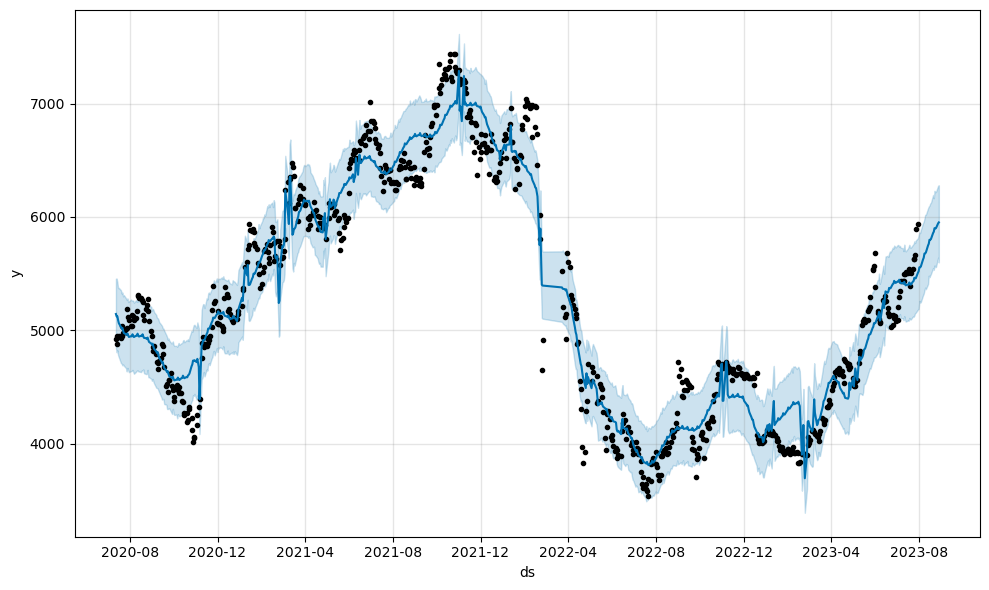

In [31]:
# Строим график
model.plot(forecast);

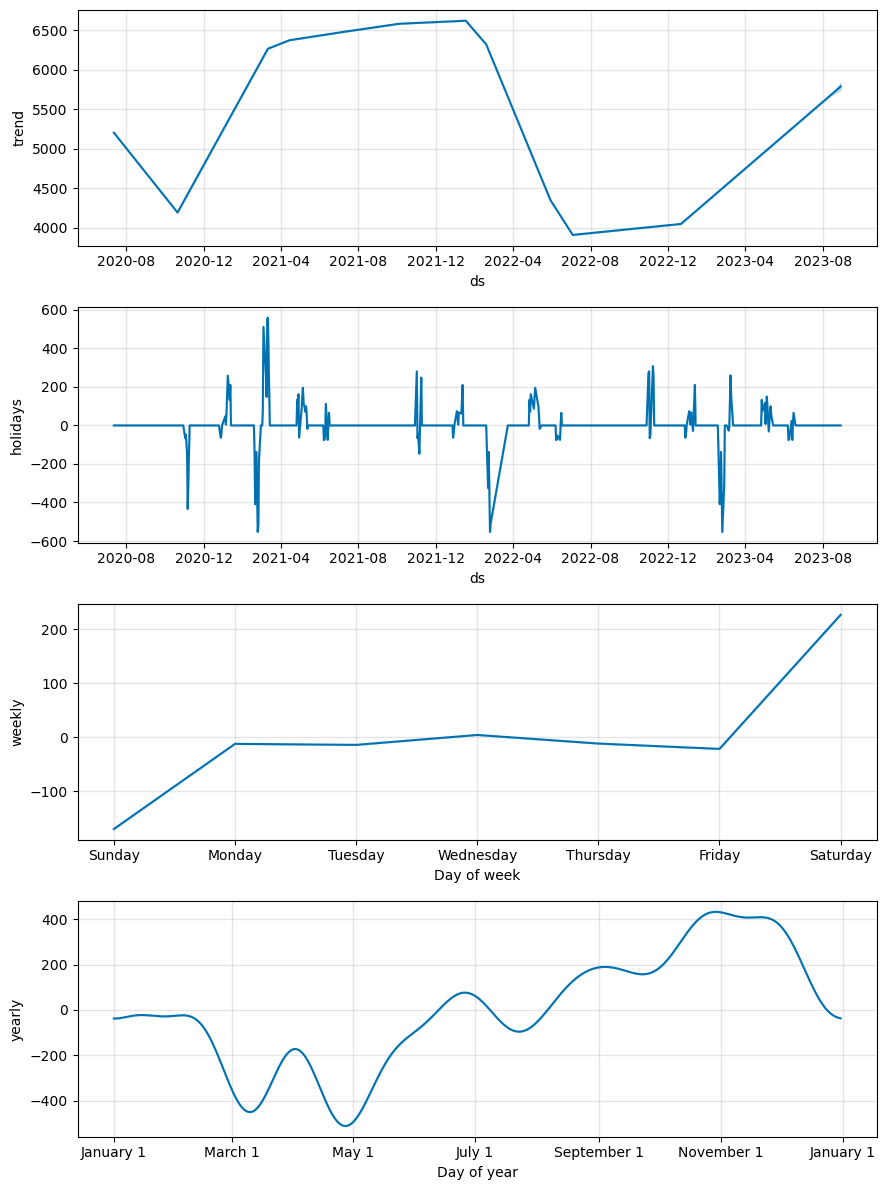

In [32]:
# Строим графики компонент
model.plot_components(forecast);

# ВЫВОДЫ

В приведенной выпускной работе была рассмотрена библиотека Prophet на предмет предсказания цены закрытия на акции российской компании ЛУКОЙЛ на период 1 месяц (21 торговый день).
Произведенные исследования показали, что: 
1. Большие горизонты прогнозирования дают относительно высокие значения ошибок. 
2. Модели в рассматриваемых условиях часто переобучались (значения метрик на валидационных выборках были лучше, чем на тестовых).
3. Подбор гиперпараметров в данной библиотеке не автоматизирован и требует значительных вычислительных ресурсов. 
4. Не всегда модели с подобранными несколькими оптимальными параметрами лучше моделей без настроенных параметров или с их небольшим количеством.
5. С целью уменьшения ошибки можно пробовать уменьшать горизонт прогнозирования и использовать технические индикаторы (оптимальным является предсказание на 1 торговую единицу времени, например, 1 день).